# Single Asset Trading

In [1]:
%run ../Code_Imports/Sig_transform_PK.ipynb import *
%run ../Code_Imports/WangZhengStationarisedIndicators.ipynb import *

In [2]:
import matplotlib.pyplot as plt

### 1) Load Dataset

In [3]:
Dataset_CSV_Directories = {'Commods': '../Datasets/ChineseCommodsData_020214_301224.csv', 'Equities': '../Datasets/EUROSTOXX_close_prices_040522_070325.csv', 'FX': '../Datasets/FX_60s_010824_300824.csv'}
Dataset_Datetime_Formats = {'Commods':  '%d/%m/%Y', 'Equities': '%Y-%m-%d %H:%M:%S%z', 'FX': '%d/%m/%Y %H:%M'}

In [4]:
def LoadDataset(AssetClass):
    '''
    AssetClass is in ['Commods', 'Equities', 'FX']
    '''
    # store raw prices
    df_raw = pd.read_csv(Dataset_CSV_Directories[AssetClass]).set_index('Datetime')
    df_raw.index = pd.to_datetime(df_raw.index, format=Dataset_Datetime_Formats[AssetClass])
    df_log = np.log(df_raw)
    
    return df_raw, df_log

In [5]:
def CreateTotalFeatureSet(asset_name, df_raw, df_log, indicators, sig_windows, max_trunc_level):
    '''
    Given the total df (raw and log), pick out a single asset and generate all technical indicator features and signature features
    '''
    # extract just asset data and its logarithm
    df_asset_raw, df_asset_log = df_raw.loc[:, asset_name], df_log.loc[:, asset_name]

    df_cols = {'raw_price': df_asset_raw, 'log_price': df_asset_log}
    
    # compute technical indicators for given parameters
    for indicator, parameters in indicators:
        df_cols[indicator+str(parameters)] = StationarisedIndicator(df_asset_raw, indicator, parameters)
    df_ret = pd.concat(df_cols, axis=1)
    
    # dimensionality of time-augmented Signature output
    M = sum([2**i for i in range(1, max_trunc_level+1)])

    # compute signature indicators
    for window in sig_windows:
        sig_col_names = [f'sig_window_{window}_{i}' for i in range(1, M + 1)]
        
        path = df_asset_log.to_numpy().reshape(-1, 1).T
        slidsig = SlidingWindowSignature(path, window=window, trunc_level=max_trunc_level, time_aug=True)
        
        df_sig = pd.DataFrame(slidsig.T, columns=sig_col_names)
        df_ret = pd.concat([df_ret, df_sig.set_index(df_ret.index)], axis=1)
        
    # drop rows so that some features do not generate larger datasets than others (different observation periods)
    df_ret.dropna(inplace=True)
    
    return df_ret

In [6]:
from sklearn.model_selection import train_test_split

def CreateTrainTestVal(df, feature_set, train_test_val_split):
    
    X, y = df.loc[:, feature_set].to_numpy(), df.loc[:, 'forecast_label'].to_numpy()

    # split data into train-test-val
    train_size, test_size, val_size = train_test_val_split  # 70% training

    # First, split into training and temp (validation + test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), shuffle=False)
    # Then, split temp into validation and test
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=val_size/(test_size + val_size), shuffle=False)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [7]:
import random
import tensorflow as tf
import os

def set_random_seed(seed=42):
    """
    Fixes the random seed across TensorFlow, NumPy, Python's random module, and OS-level randomness.
    """
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # NumPy
    tf.random.set_seed(seed)  # TensorFlow/Keras
    
    # Ensure TensorFlow does not introduce randomness due to parallel execution
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Ensures deterministic CuDNN operations (if using GPU)

In [8]:
def reshape_for_lstm(data, timesteps):
    samples = data.shape[0] - timesteps + 1
    return np.array([data[i:i+timesteps] for i in range(samples)])

In [9]:
# global lstm param variable
LSTM_TIMESTEPS = 10

In [10]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


def FitAndPredictModel(model_type, X_train, y_train, X_test, y_test):
    
    set_random_seed()
    # Define models in dictionary
    model_map = {
        'XGB': xgb.XGBClassifier(objective="binary:logistic", n_estimators=200),
        
        'LogReg': LogisticRegression(solver='lbfgs'),

        'FeedForward': Sequential([
            tf.keras.Input(shape=(X_train.shape[1],)),  # Use Input instead of input_shape in Dense
            Dense(64),  
            Dense(20, activation='relu'),
            Dropout(0.3),
            Dense(10, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')]),

        'LSTM': Sequential([
            tf.keras.Input(shape=(LSTM_TIMESTEPS, X_train.shape[1])),  # Use Input instead of input_shape in LSTM
            LSTM(32, activation='relu', return_sequences=True),
            Dropout(0.3),
            LSTM(20, activation='relu', return_sequences=False),
            Dropout(0.3),
            Dense(1, activation='sigmoid')  # Output layer for binary classification
        ]) 
    }

    model = model_map[model_type]
    
    # scale inputs
    # Apply Expanding Window Scaler
    scaler = IdentityScaler()
    #scaler = ExpandingWindowScaler(min_periods=5)  # Start normalizing after 5 observations
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    if model_type in ['XGB', 'LogReg']:
        # fit model
        model.fit(X_train, y_train)        
        y_outsample_pred = model.predict(X_test)
    
    if model_type == 'FeedForward':
        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001),  # Initial learning rate
                      loss=BinaryCrossentropy(),
                      metrics=['accuracy'])

        # Callbacks
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
        model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)

        # Train the model
        history = model.fit(X_train, y_train, 
                            epochs=25, batch_size=128, 
                            validation_data=(X_test, y_test), 
                            callbacks=[lr_scheduler, model_checkpoint], verbose=0)

        # Load the best model
        model = tf.keras.models.load_model('best_model.keras')
        
        # Convert probabilities to class predictions (threshold = 0.5)
        y_outsample_pred_prob = model.predict(X_test, verbose=0)

        # Apply threshold to get binary class predictions
        y_outsample_pred = (y_outsample_pred_prob > 0.5).astype(int)
        
    if model_type == 'LSTM':
        
        # Reshape data for LSTM (samples, timesteps, features)
        X_train_lstm = reshape_for_lstm(X_train, LSTM_TIMESTEPS)
        X_test_lstm = reshape_for_lstm(X_test, LSTM_TIMESTEPS)

        # Adjust y labels to match reshaped sequences
        y_train_lstm = y_train[LSTM_TIMESTEPS - 1:]
        y_test_lstm = y_test[LSTM_TIMESTEPS - 1:]

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001),  # Initial learning rate
                      loss=BinaryCrossentropy(),
                      metrics=['accuracy'])

        # Callbacks
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
        model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)

        # Train the model
        history = model.fit(X_train_lstm, y_train_lstm, 
                            epochs=20, batch_size=128, 
                            validation_data=(X_test_lstm, y_test_lstm), 
                            callbacks=[lr_scheduler, model_checkpoint], verbose=0)

        # Load the best model
        model = tf.keras.models.load_model('best_lstm_model.keras')

        # Convert probabilities to class predictions (threshold = 0.5)
        y_outsample_pred_prob = model.predict(X_test_lstm, verbose=0)

        # Apply threshold to get binary class predictions
        y_outsample_pred = (y_outsample_pred_prob > 0.5).astype(int) 
        
        # replace generic y_test with shape-modified y_test
        y_test = y_test_lstm
    
    # evalute test accuracy
    outsample_accuracy = accuracy_score(y_outsample_pred, y_test)
    
    return (model, scaler, outsample_accuracy)


In [11]:
def SelectBestModelAndPredict(ResultsDict, X_val_dict):
    """
    Selects the best model for each feature set based on test accuracy and 
    predicts on the validation set.

    Parameters:
        ResultsDict (dict): A dictionary containing trained models, scalers, and accuracy scores.
        X_val_dict (dict): A dictionary containing validation feature sets.

    Returns:
        dict: A dictionary containing predictions on the validation set for each feature set.
    """
    best_models = {}
    val_predictions = {}

    for feature_set_name, models in ResultsDict.items():
        # Find the best model (highest accuracy)
        best_model_name = max(models, key=lambda model: models[model][2])  # Third element is accuracy
        best_model, best_scaler, best_accuracy = models[best_model_name]

        # Retrieve validation data
        X_val = X_val_dict[feature_set_name]

        # Apply scaling if necessary
        if best_scaler is not None:
            X_val_scaled = best_scaler.transform(X_val)
        else:
            X_val_scaled = X_val
            
        # reshape if LSTM model
        if best_model_name == 'LSTM':
            print('LSTM IS BEST!')
            X_val_scaled = reshape_for_lstm(X_val_scaled, LSTM_TIMESTEPS)

        # Generate predictions
        y_val_pred = (best_model.predict(X_val_scaled) > 0.5).astype("int32")

        # Store results
        best_models[feature_set_name] = (best_model_name, best_accuracy)
        val_predictions[feature_set_name] = y_val_pred

    return best_models, val_predictions

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class ExpandingWindowScaler(BaseEstimator, TransformerMixin):
    def __init__(self, min_periods=10):
        """
        Expanding window scaler with controlled information leakage for early observations.
        
        Parameters:
        - min_periods (int): Number of observations before switching to pure expanding window.
        """
        self.min_periods = min_periods
        self.global_mean = None
        self.global_std = None

    def fit(self, X, y=None):
        """Computes the global mean and std based on the first `min_periods` observations."""
        X = np.asarray(X).flatten()
        self.global_mean = np.mean(X[:self.min_periods])
        self.global_std = np.std(X[:self.min_periods]) if np.std(X[:self.min_periods]) > 0 else 1
        return self

    def transform(self, X):
        """Applies standardization with global stats for early values and expanding stats afterward."""
        X = pd.DataFrame(X)  # Ensure it's a DataFrame for expanding operations
        expanding_mean = X.expanding(min_periods=self.min_periods).mean()
        expanding_std = X.expanding(min_periods=self.min_periods).std()

        # Use global mean & std for first `min_periods` observations
        X_scaled = (X - expanding_mean) / (expanding_std + 1e-8)
        X_scaled.iloc[:self.min_periods] = (X.iloc[:self.min_periods] - self.global_mean) / self.global_std
        
        return X_scaled.values

    def fit_transform(self, X, y=None):
        """Fits and transforms in one step."""
        self.fit(X)
        return self.transform(X)


class IdentityScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

In [18]:
def TrainModels(df_features, indicators_col_names, sig_col_names, forecast_tau, forecast_threshold=0):

    df_classification = df_features.copy()
    df_classification['forecast_return'] =  -df_classification.log_price.diff(-forecast_tau)

    # for classification tasks, classes are labelled 0, 1 (0 is short and 1 is long)
    df_classification['forecast_label'] = np.where(df_classification.forecast_return > 0, 1, 0)

    feature_sets = [(indicators_col_names, 'TI'), (sig_col_names, 'Sig'), (indicators_col_names + sig_col_names, 'TI_and_Sig')]
    ResultsDict = {'TI':{}, 'Sig':{}, 'TI_and_Sig':{}}
    model_types = ['FeedForward', 'LSTM', 'XGB', 'LogReg', 'FeedForward']# 'LSTM']
    
    X_val_dict = {}
    y_val_dict = {}

    for feature_set, feature_set_name in feature_sets:

        #print(f'features used: {feature_set_name}', '-'*40)

        # extract correct feature set and classification labels
        X_train, X_test, X_val, y_train, y_test, y_val = CreateTrainTestVal(df_classification, feature_set, train_test_val_split)
        
        X_val_dict[feature_set_name] = X_val
        y_val_dict[feature_set_name] = y_val
        
        for model_type in model_types:
            # fit models 

            #print(f'training {model_type}...')
            ResultsDict[feature_set_name][model_type] = FitAndPredictModel(model_type, X_train, y_train, X_test, y_test)
    
    # pick the best model for each feature_set and plot the validation backtest...
    best_models, val_predictions = SelectBestModelAndPredict(ResultsDict, X_val_dict)
    #print('done!')
    
    # Calculate accuracy on validation set
#     val_accuracies = {
#         feature_set: accuracy_score(y_val_dict[feature_set], val_predictions[feature_set])
#         for feature_set in val_predictions
#     }
    val_accuracies = {}
    for feature_set in val_predictions:
        if best_models[feature_set][0] == 'LSTM':
            y_val_dict[feature_set] = y_val_dict[feature_set][LSTM_TIMESTEPS - 1:]
        
        val_accuracies[feature_set] = accuracy_score(y_val_dict[feature_set], val_predictions[feature_set])
    

    print("Validation Accuracy Scores:", val_accuracies)
    
    for feature_set in val_predictions:
        df_classification[feature_set+'_preds'] = np.nan
        
        y_preds = val_predictions[feature_set]
        if len(y_preds.shape) == 2:
            y_preds = y_preds.squeeze()
        
        
        df_classification.loc[df_classification.index[-len(y_preds):], feature_set+'_preds'] = y_preds

    
    return ResultsDict, df_classification, best_models

In [19]:
import matplotlib.pyplot as plt
def PlotValidationPnL(df_val_pnl):

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 4))

    # Plot the data
    (100 * df_val_pnl.loc[:, ['TI_Cum_PnL', 'Sig_Cum_PnL', 'TI_and_Sig_Cum_PnL']]).plot(ax=ax)

    # Customization
    ax.set_facecolor("#f0f0f0")  # Light grey background
    fig.patch.set_facecolor("#f0f0f0")  # Set figure background

    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Gridlines
    ax.spines['top'].set_visible(False)  # Hide top spine
    ax.spines['right'].set_visible(False)  # Hide right spine

    # Set labels and title
    ax.set_ylabel("Cumulative PnL (%)")
    ax.set_title("Performance Comparison", fontsize=14, fontweight='bold')

    # Custom legend
    ax.legend(['CI', 'RTAS', 'CI + RTAS'], fontsize=10)

    # Show the plot
    plt.show()

In [15]:
# 10

n = 20
m, k = 10, 5
sig_windows = [20]

technical_indicators = ['EMA', 'BB', 'ROC', 'RSI']
indicators = [(TI, [n]) for TI in technical_indicators] + [('MACD', [m, n, k])]

max_trunc_level = 4

In [16]:
indicators_col_names = [x + str(y) for x,y in indicators]

M = sum([2**i for i in range(1, max_trunc_level+1)])
sig_col_names = [f'sig_window_{window}_{i}' for i in range(1, M + 1) for window in sig_windows]

forecast_tau = 1
forecast_threshold = 0
train_test_val_split = [0.5, 0.3, 0.2]

In [17]:
import pickle

FX
AUDUSD
LSTM IS BEST!
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation Accuracy Scores: {'TI': 0.5275966279624622, 'Sig': 0.5206480304955527, 'TI_and_Sig': 0.5206480304955527}



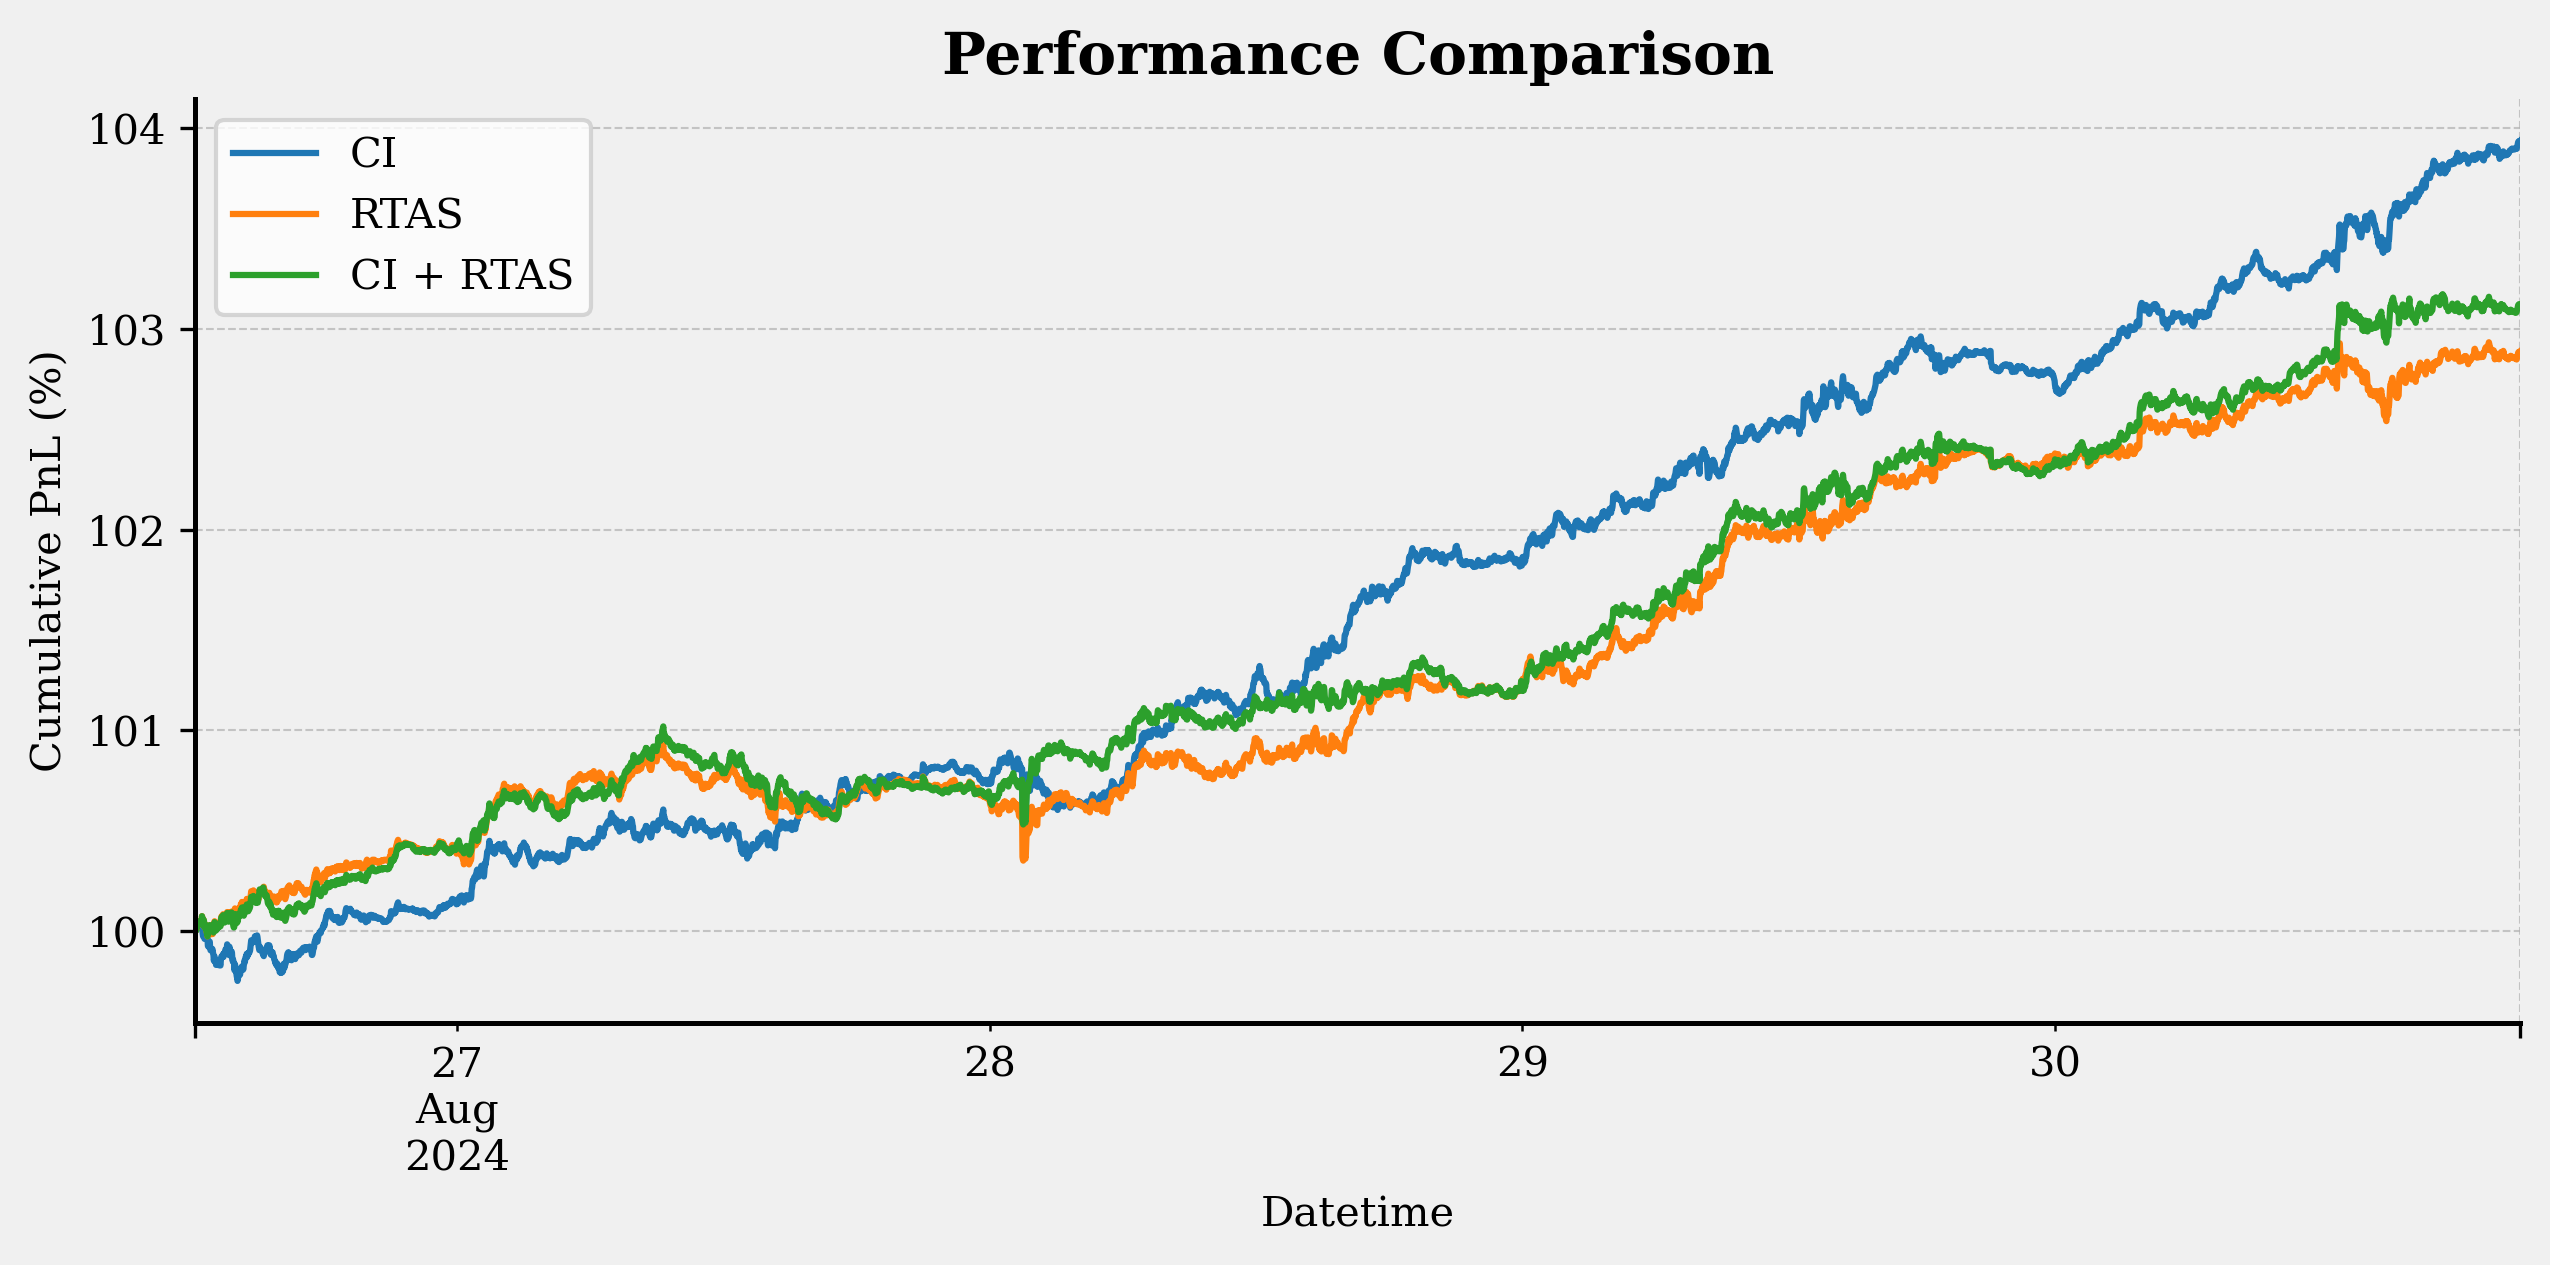

[{'Sharpe Ratio': 18.445127984247904, 'Sortino Ratio': 24.89839660381928, 'Max Drawdown': -0.00300645062583893, 'Frequency': 'minute'}, {'Sharpe Ratio': 13.5871542596768, 'Sortino Ratio': 18.575615683240766, 'Max Drawdown': -0.005692898615829778, 'Frequency': 'minute'}, {'Sharpe Ratio': 14.66461316956253, 'Sortino Ratio': 20.052739119932344, 'Max Drawdown': -0.004831205385289583, 'Frequency': 'minute'}]
EURUSD
Validation Accuracy Scores: {'TI': 0.5436785260482846, 'Sig': 0.5408195679796697, 'TI_and_Sig': 0.5428843710292249}



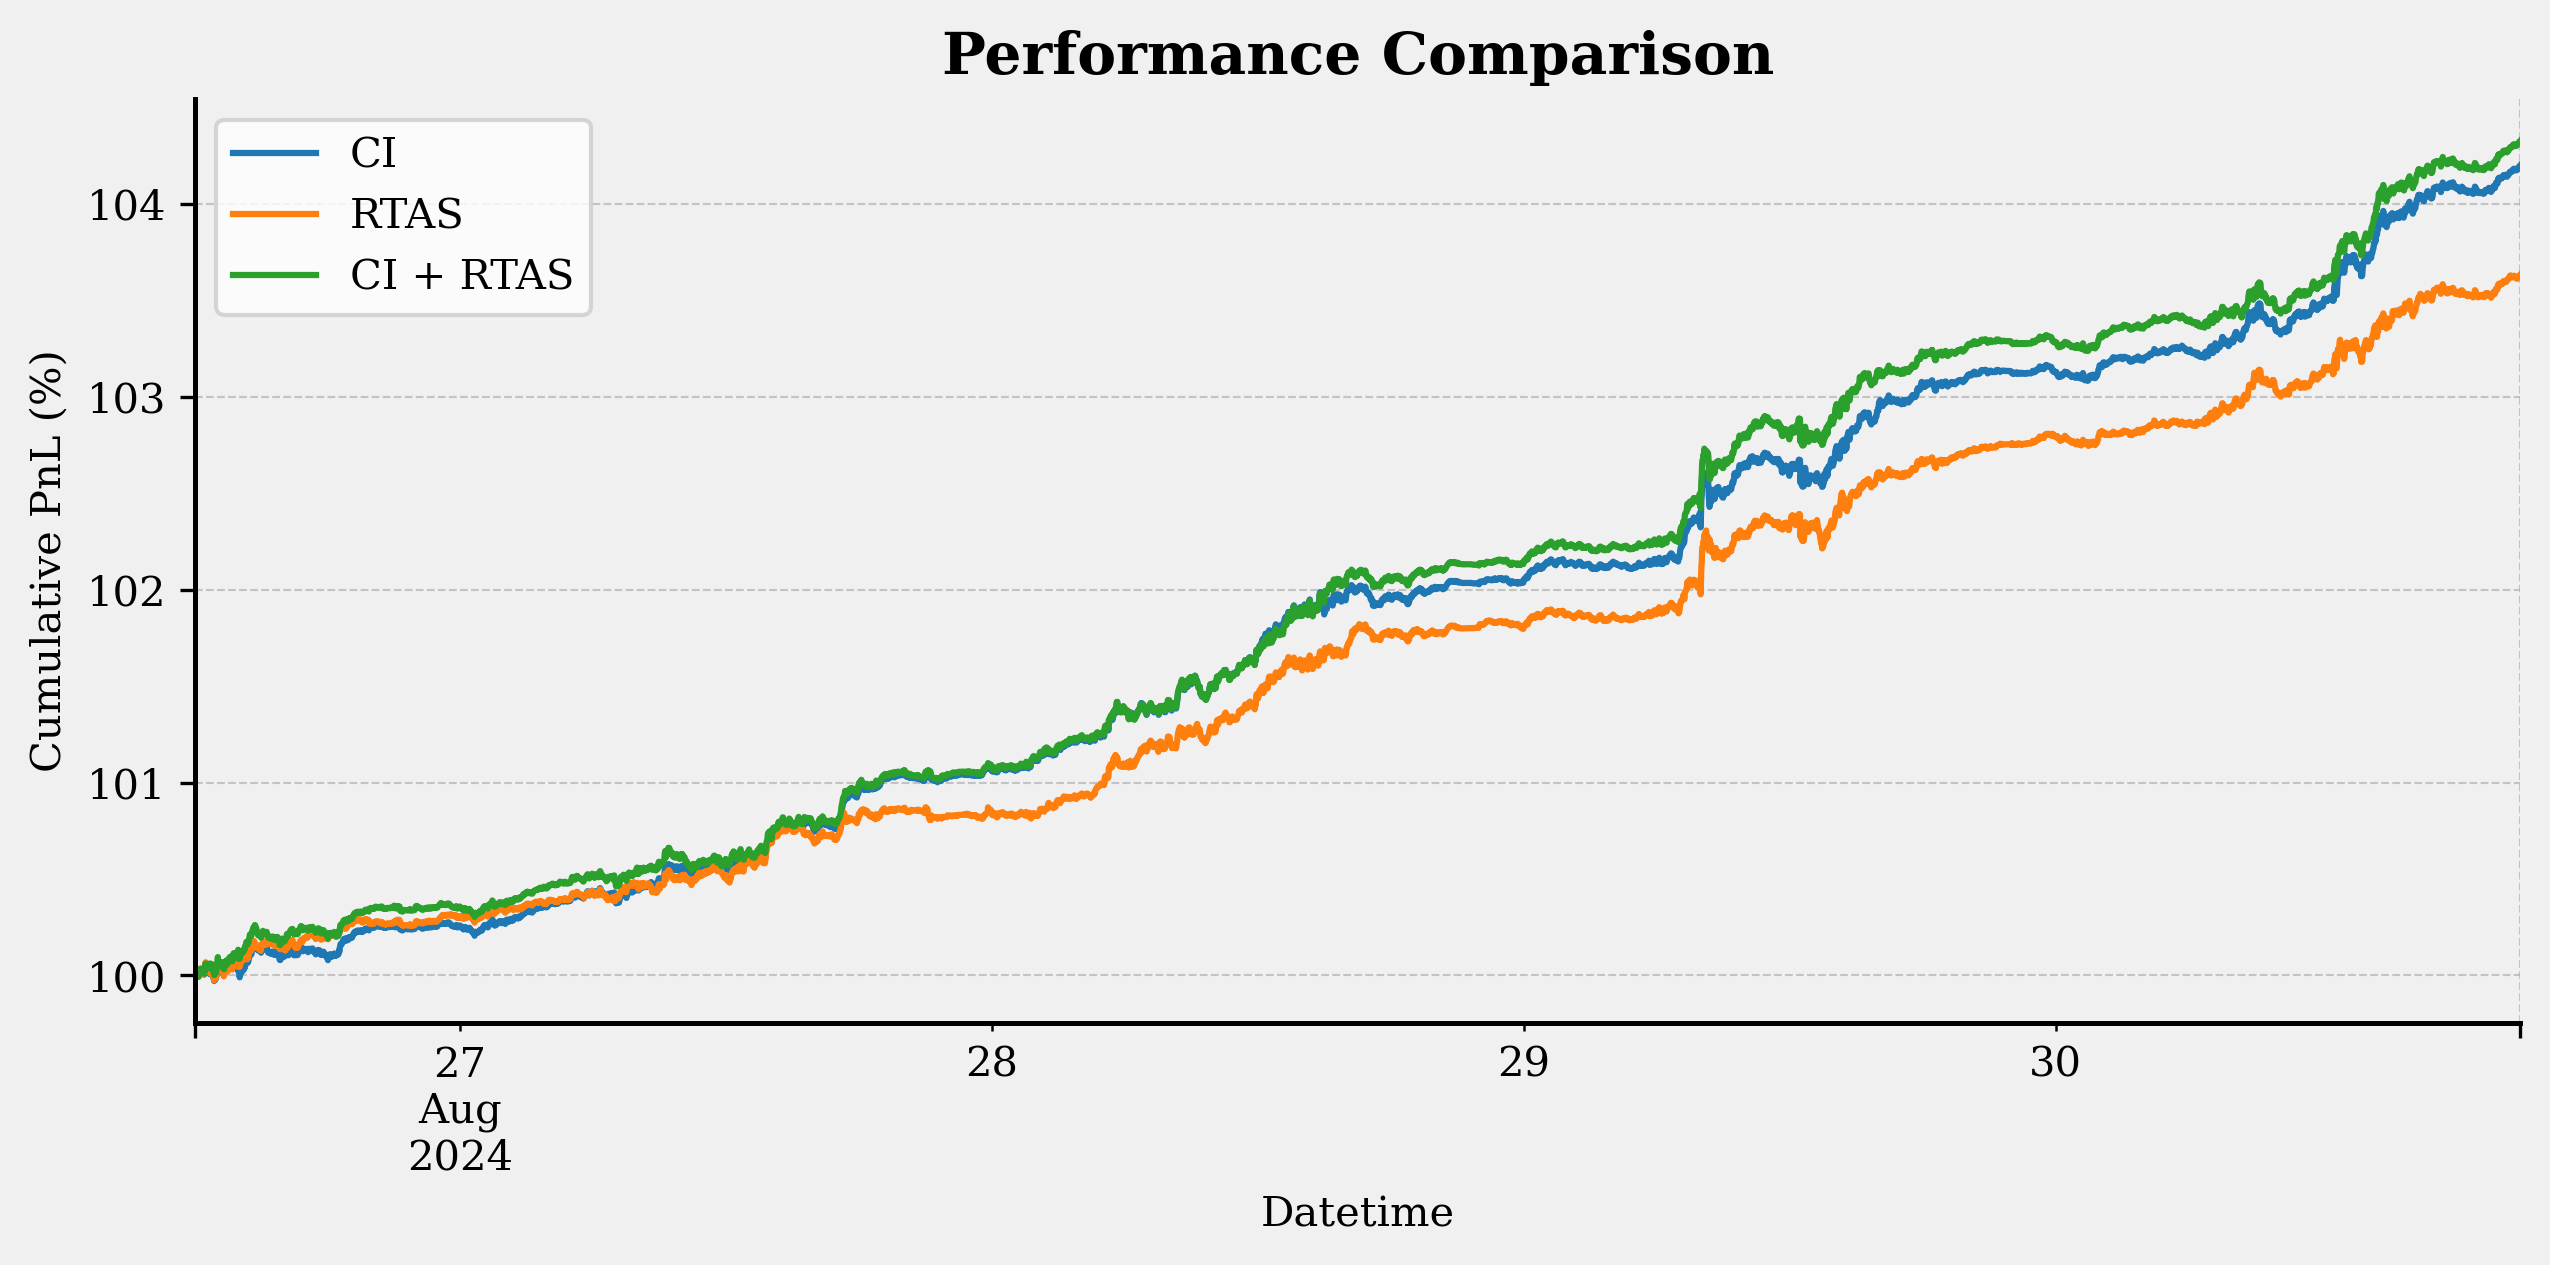

[{'Sharpe Ratio': 26.558554104852487, 'Sortino Ratio': 34.81787446763295, 'Max Drawdown': -0.0017336370126251888, 'Frequency': 'minute'}, {'Sharpe Ratio': 23.018541778632347, 'Sortino Ratio': 30.345601291834708, 'Max Drawdown': -0.0017409310216984775, 'Frequency': 'minute'}, {'Sharpe Ratio': 27.349612122846892, 'Sortino Ratio': 36.245313470524245, 'Max Drawdown': -0.0015615522859148134, 'Frequency': 'minute'}]
GBPUSD
LSTM IS BEST!
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation Accuracy Scores: {'TI': 0.564816287577541, 'Sig': 0.5265247776365947, 'TI_and_Sig': 0.5432020330368488}



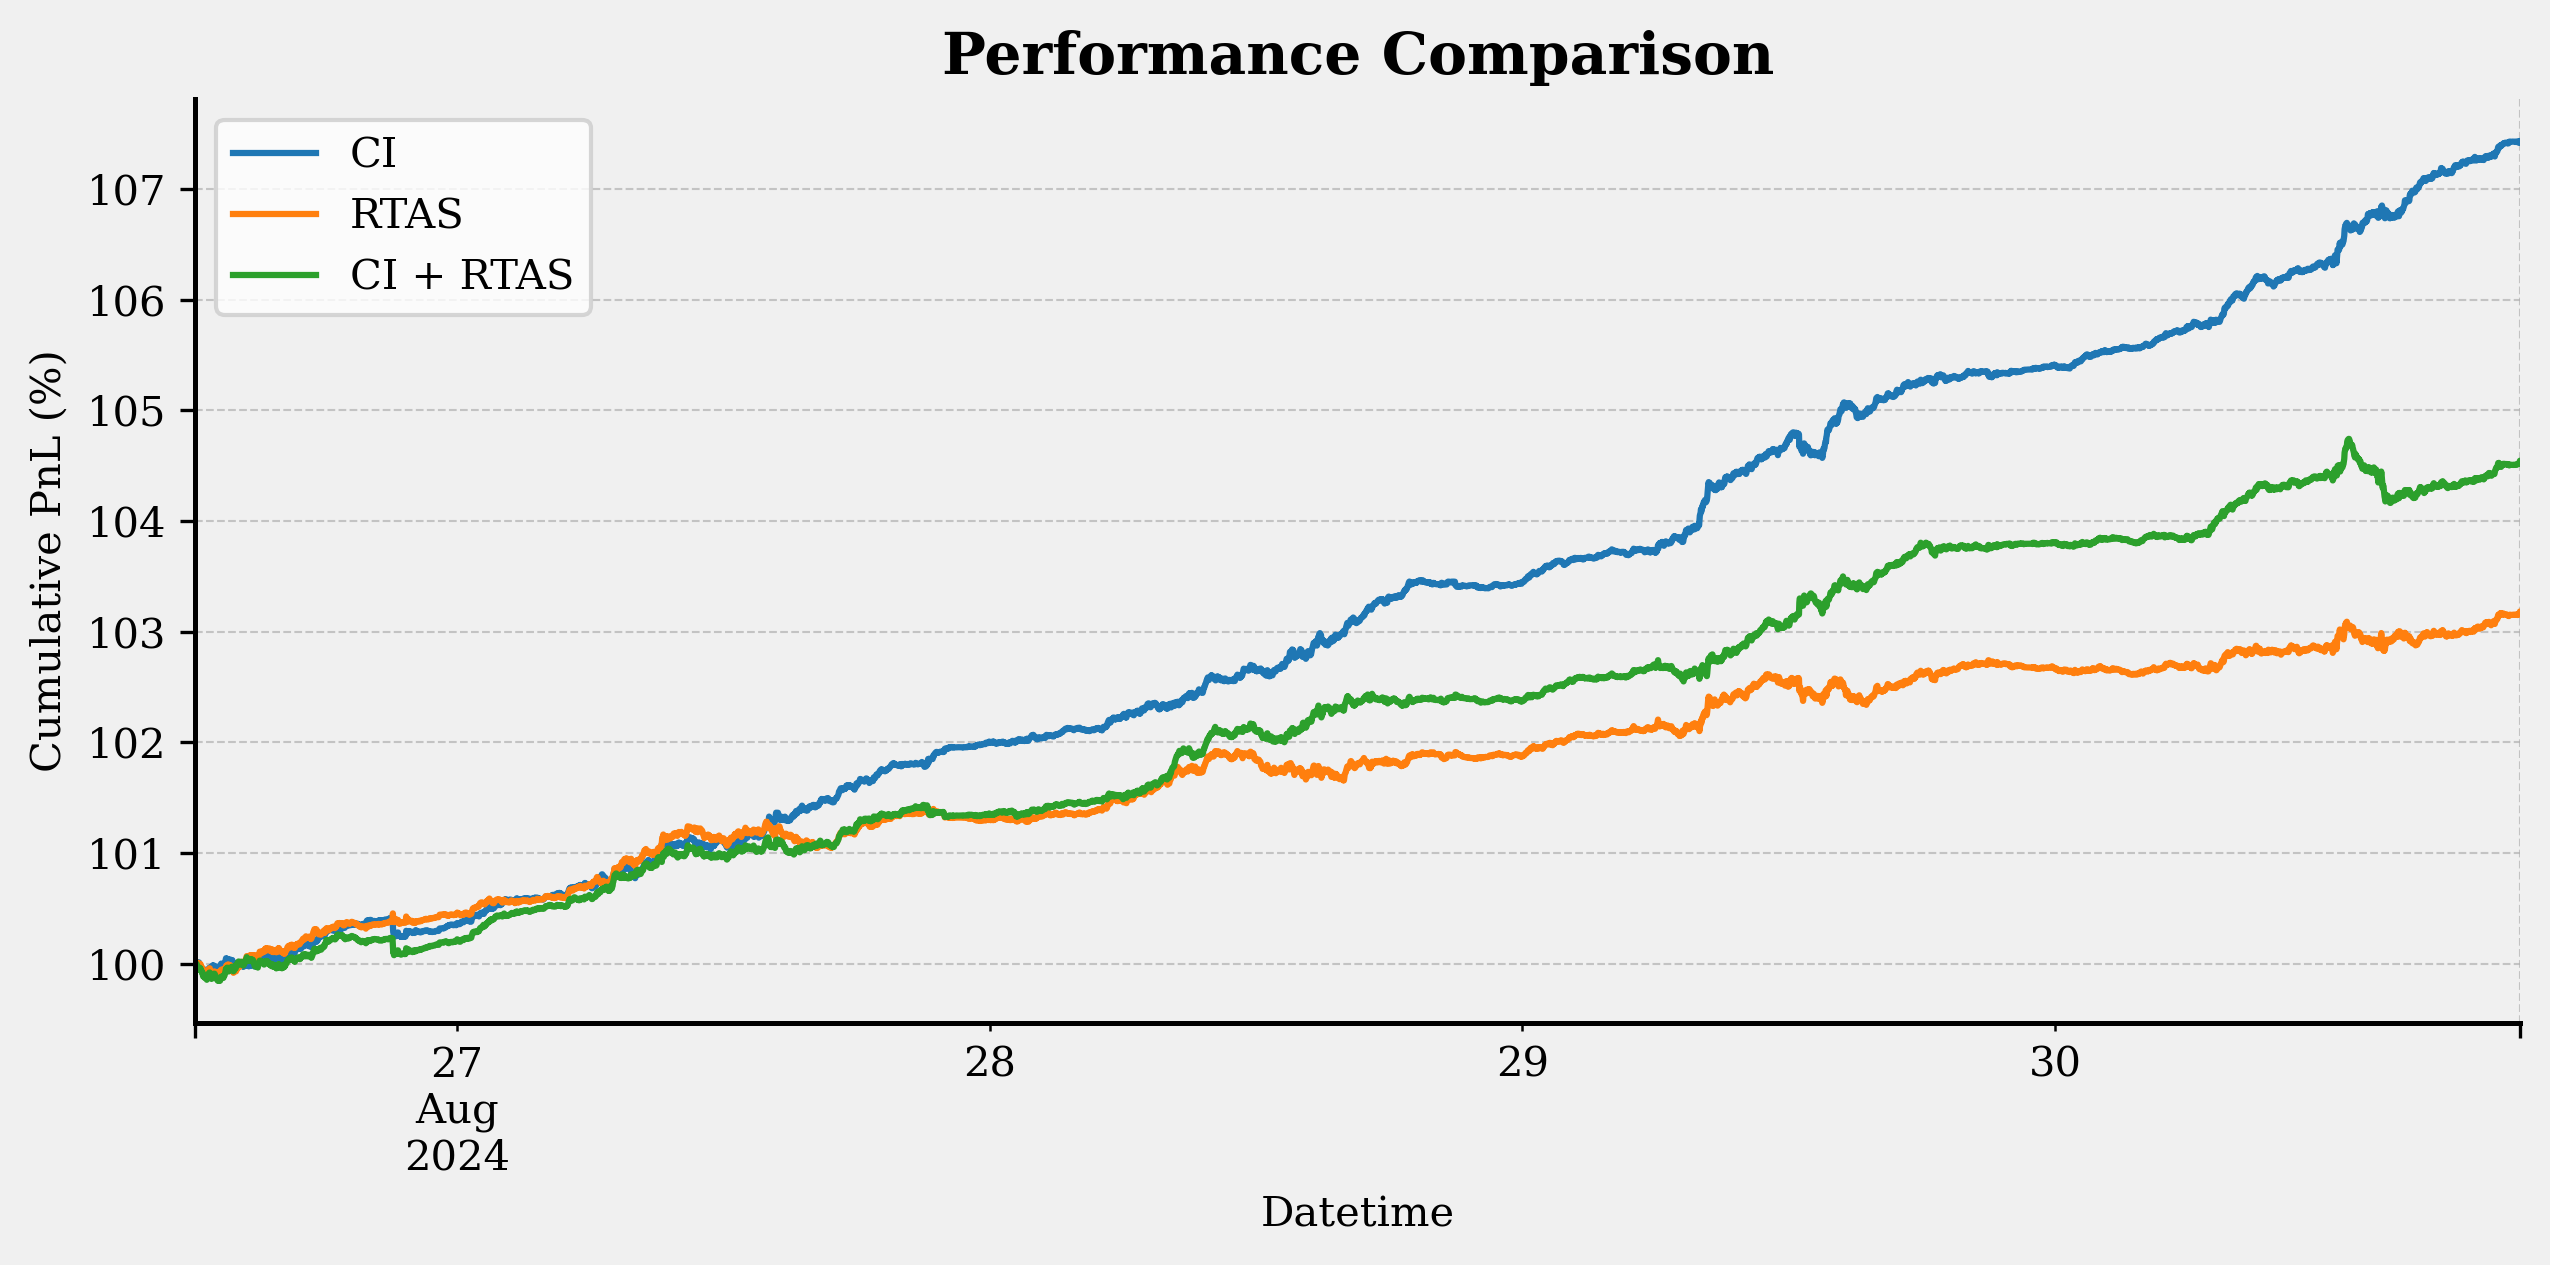

[{'Sharpe Ratio': 40.70269738009164, 'Sortino Ratio': 55.22215727885614, 'Max Drawdown': -0.0022018645983237217, 'Frequency': 'minute'}, {'Sharpe Ratio': 17.666476655450516, 'Sortino Ratio': 24.184519626508592, 'Max Drawdown': -0.00268989698074662, 'Frequency': 'minute'}, {'Sharpe Ratio': 25.100962314631037, 'Sortino Ratio': 34.40685933377269, 'Max Drawdown': -0.005524494414808734, 'Frequency': 'minute'}]
NZDUSD
LSTM IS BEST!
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation Accuracy Scores: {'TI': 0.550182917130587, 'Sig': 0.5216010165184244, 'TI_and_Sig': 0.5265247776365947}



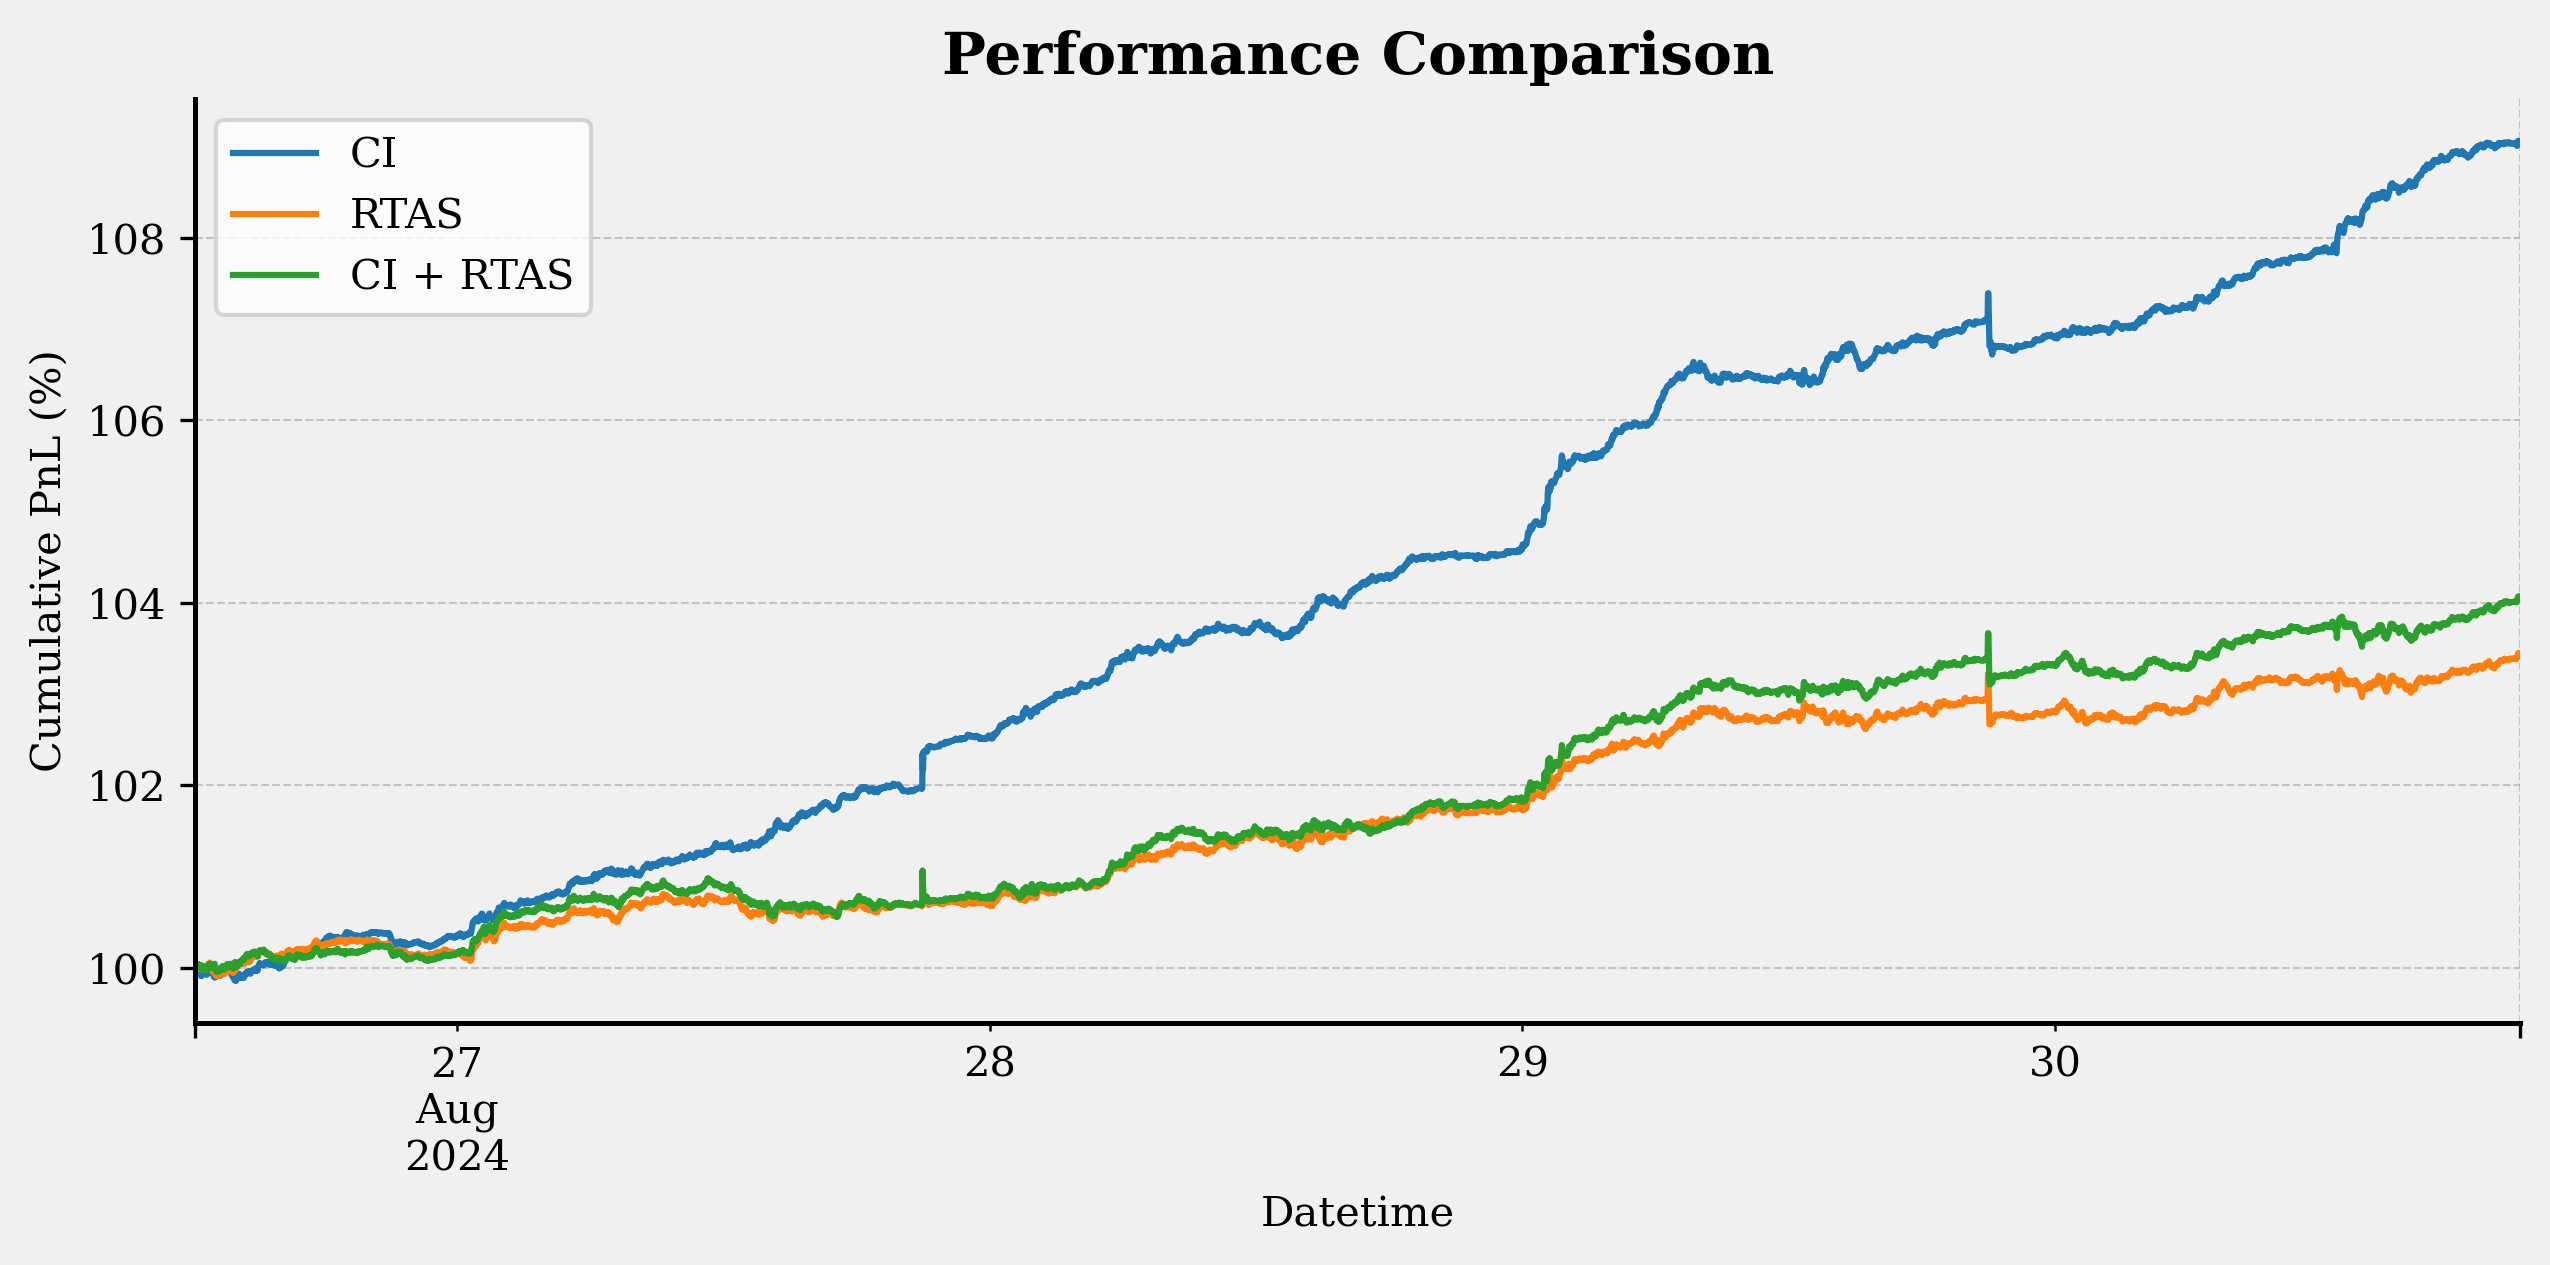

[{'Sharpe Ratio': 32.50751181158608, 'Sortino Ratio': 44.98363231661356, 'Max Drawdown': -0.006253564611680362, 'Frequency': 'minute'}, {'Sharpe Ratio': 12.62709547489263, 'Sortino Ratio': 16.613058620143686, 'Max Drawdown': -0.005397983876633261, 'Frequency': 'minute'}, {'Sharpe Ratio': 14.864544394361507, 'Sortino Ratio': 19.614330021140738, 'Max Drawdown': -0.005397983876633483, 'Frequency': 'minute'}]
USDCAD
LSTM IS BEST!
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation Accuracy Scores: {'TI': 0.5485923333863528, 'Sig': 0.5330368487928844, 'TI_and_Sig': 0.5289072426937739}



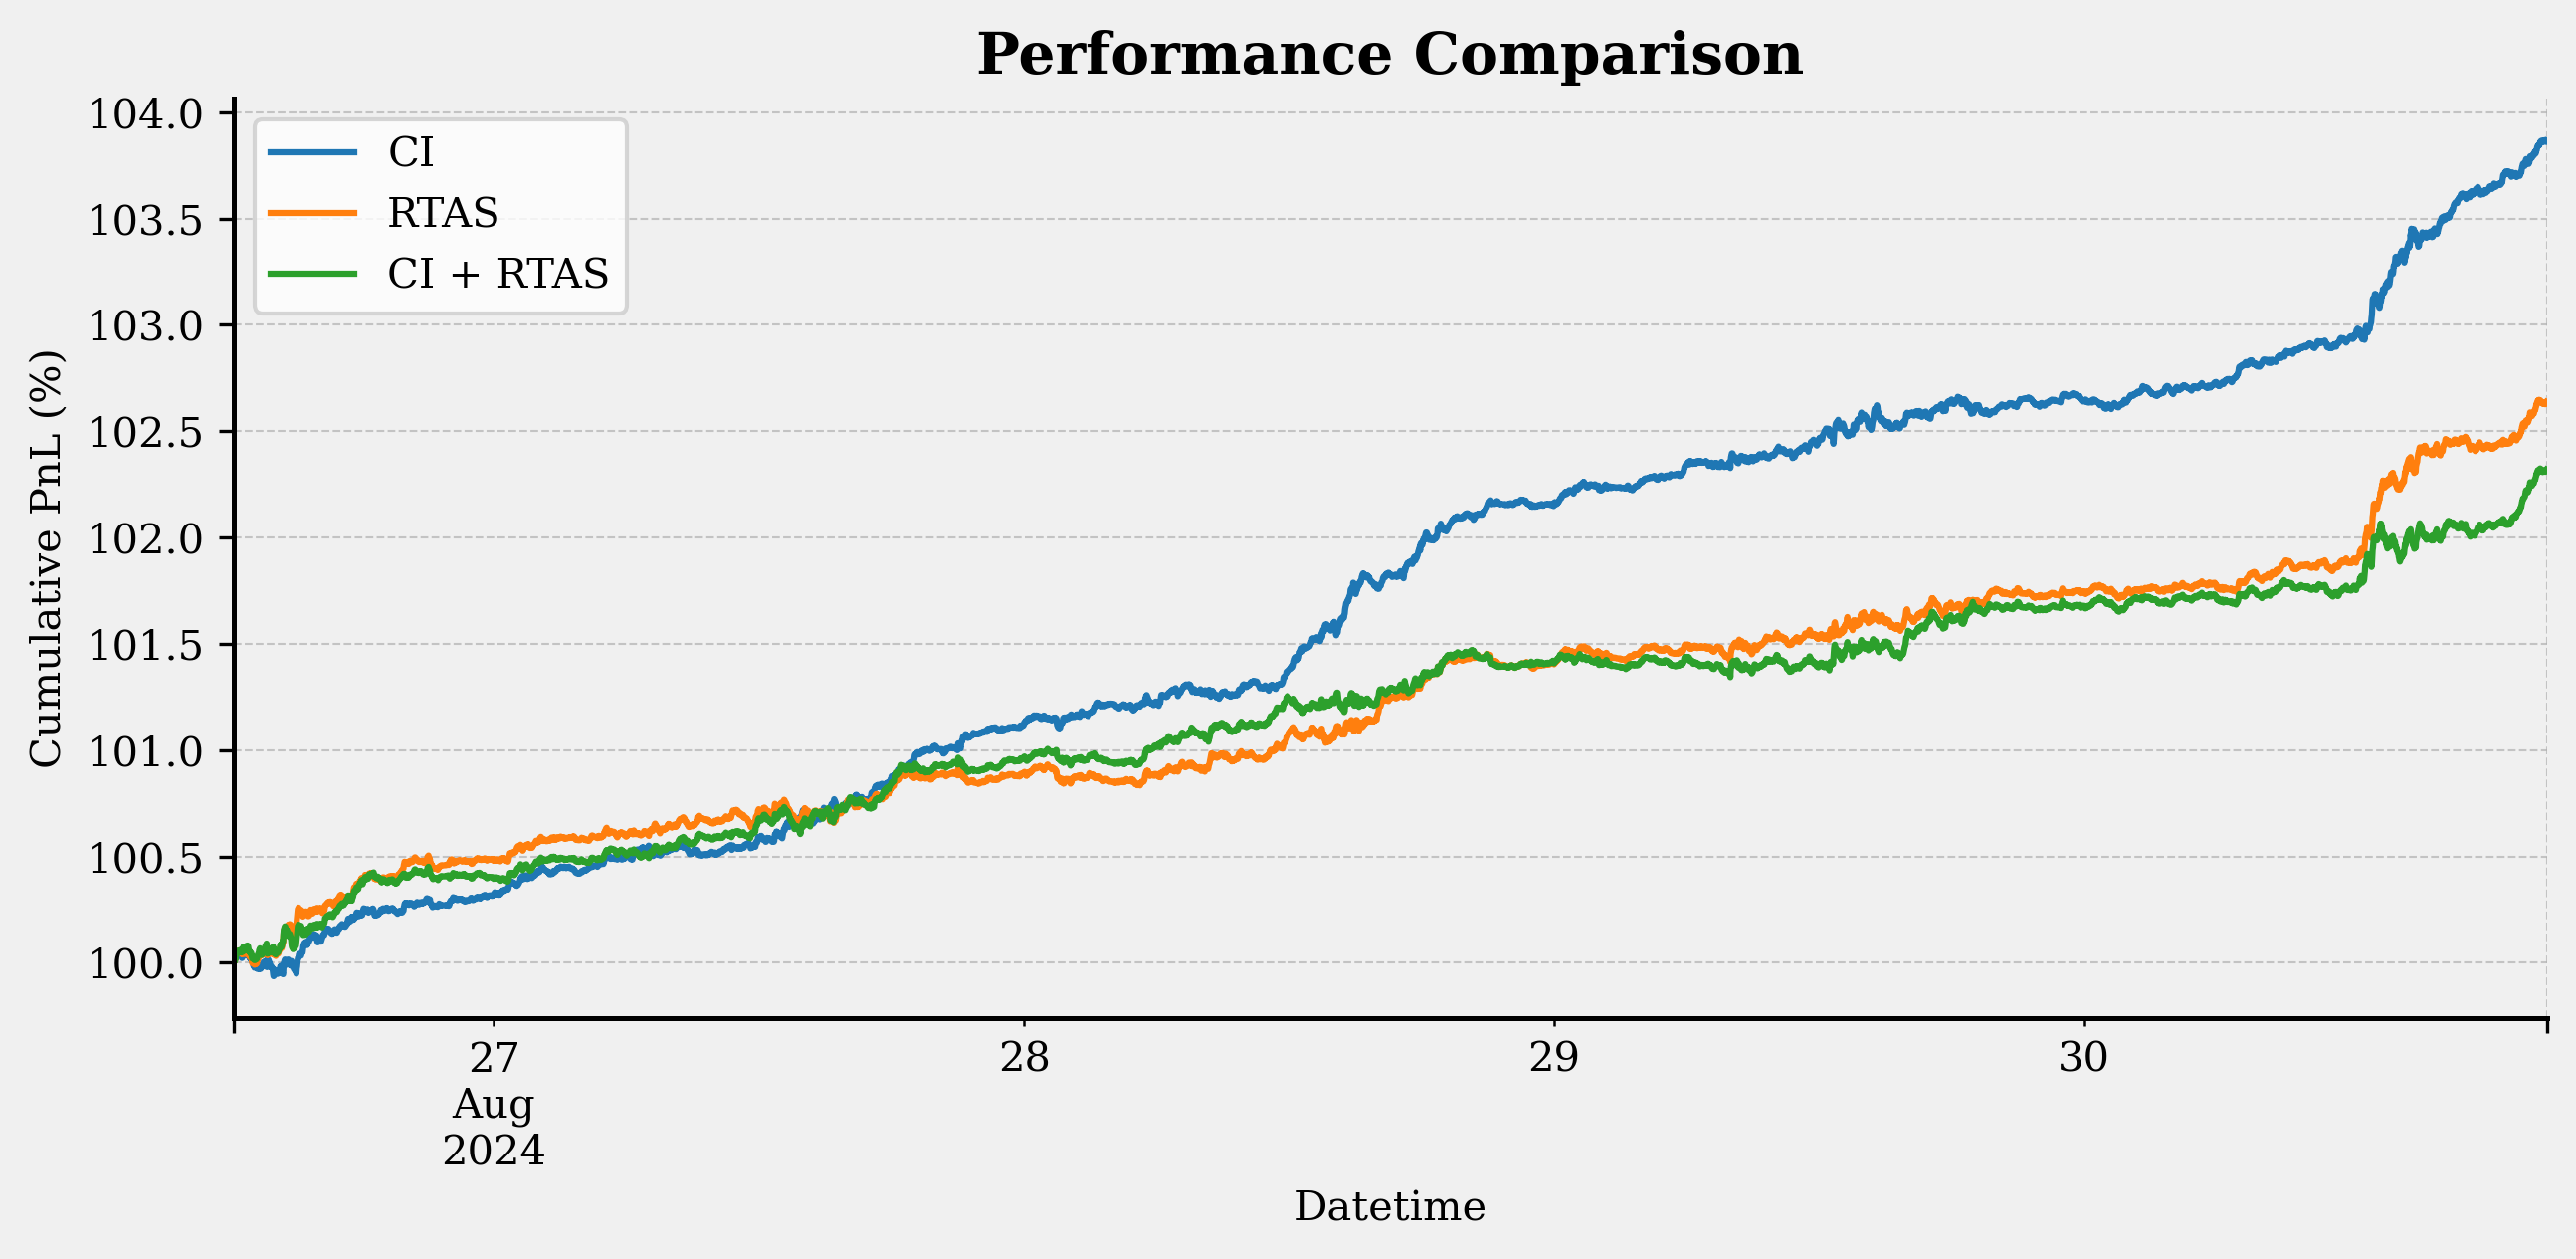

[{'Sharpe Ratio': 34.28253779693572, 'Sortino Ratio': 50.32186627254019, 'Max Drawdown': -0.0012128169280489765, 'Frequency': 'minute'}, {'Sharpe Ratio': 23.463750553052023, 'Sortino Ratio': 33.73504381757104, 'Max Drawdown': -0.001117913599726017, 'Frequency': 'minute'}, {'Sharpe Ratio': 20.654254192265597, 'Sortino Ratio': 29.454803417920424, 'Max Drawdown': -0.0017556278258406, 'Frequency': 'minute'}]
USDCHF
LSTM IS BEST!
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation Accuracy Scores: {'TI': 0.5308622335348393, 'Sig': 0.5377283558379666, 'TI_and_Sig': 0.5162827640984908}



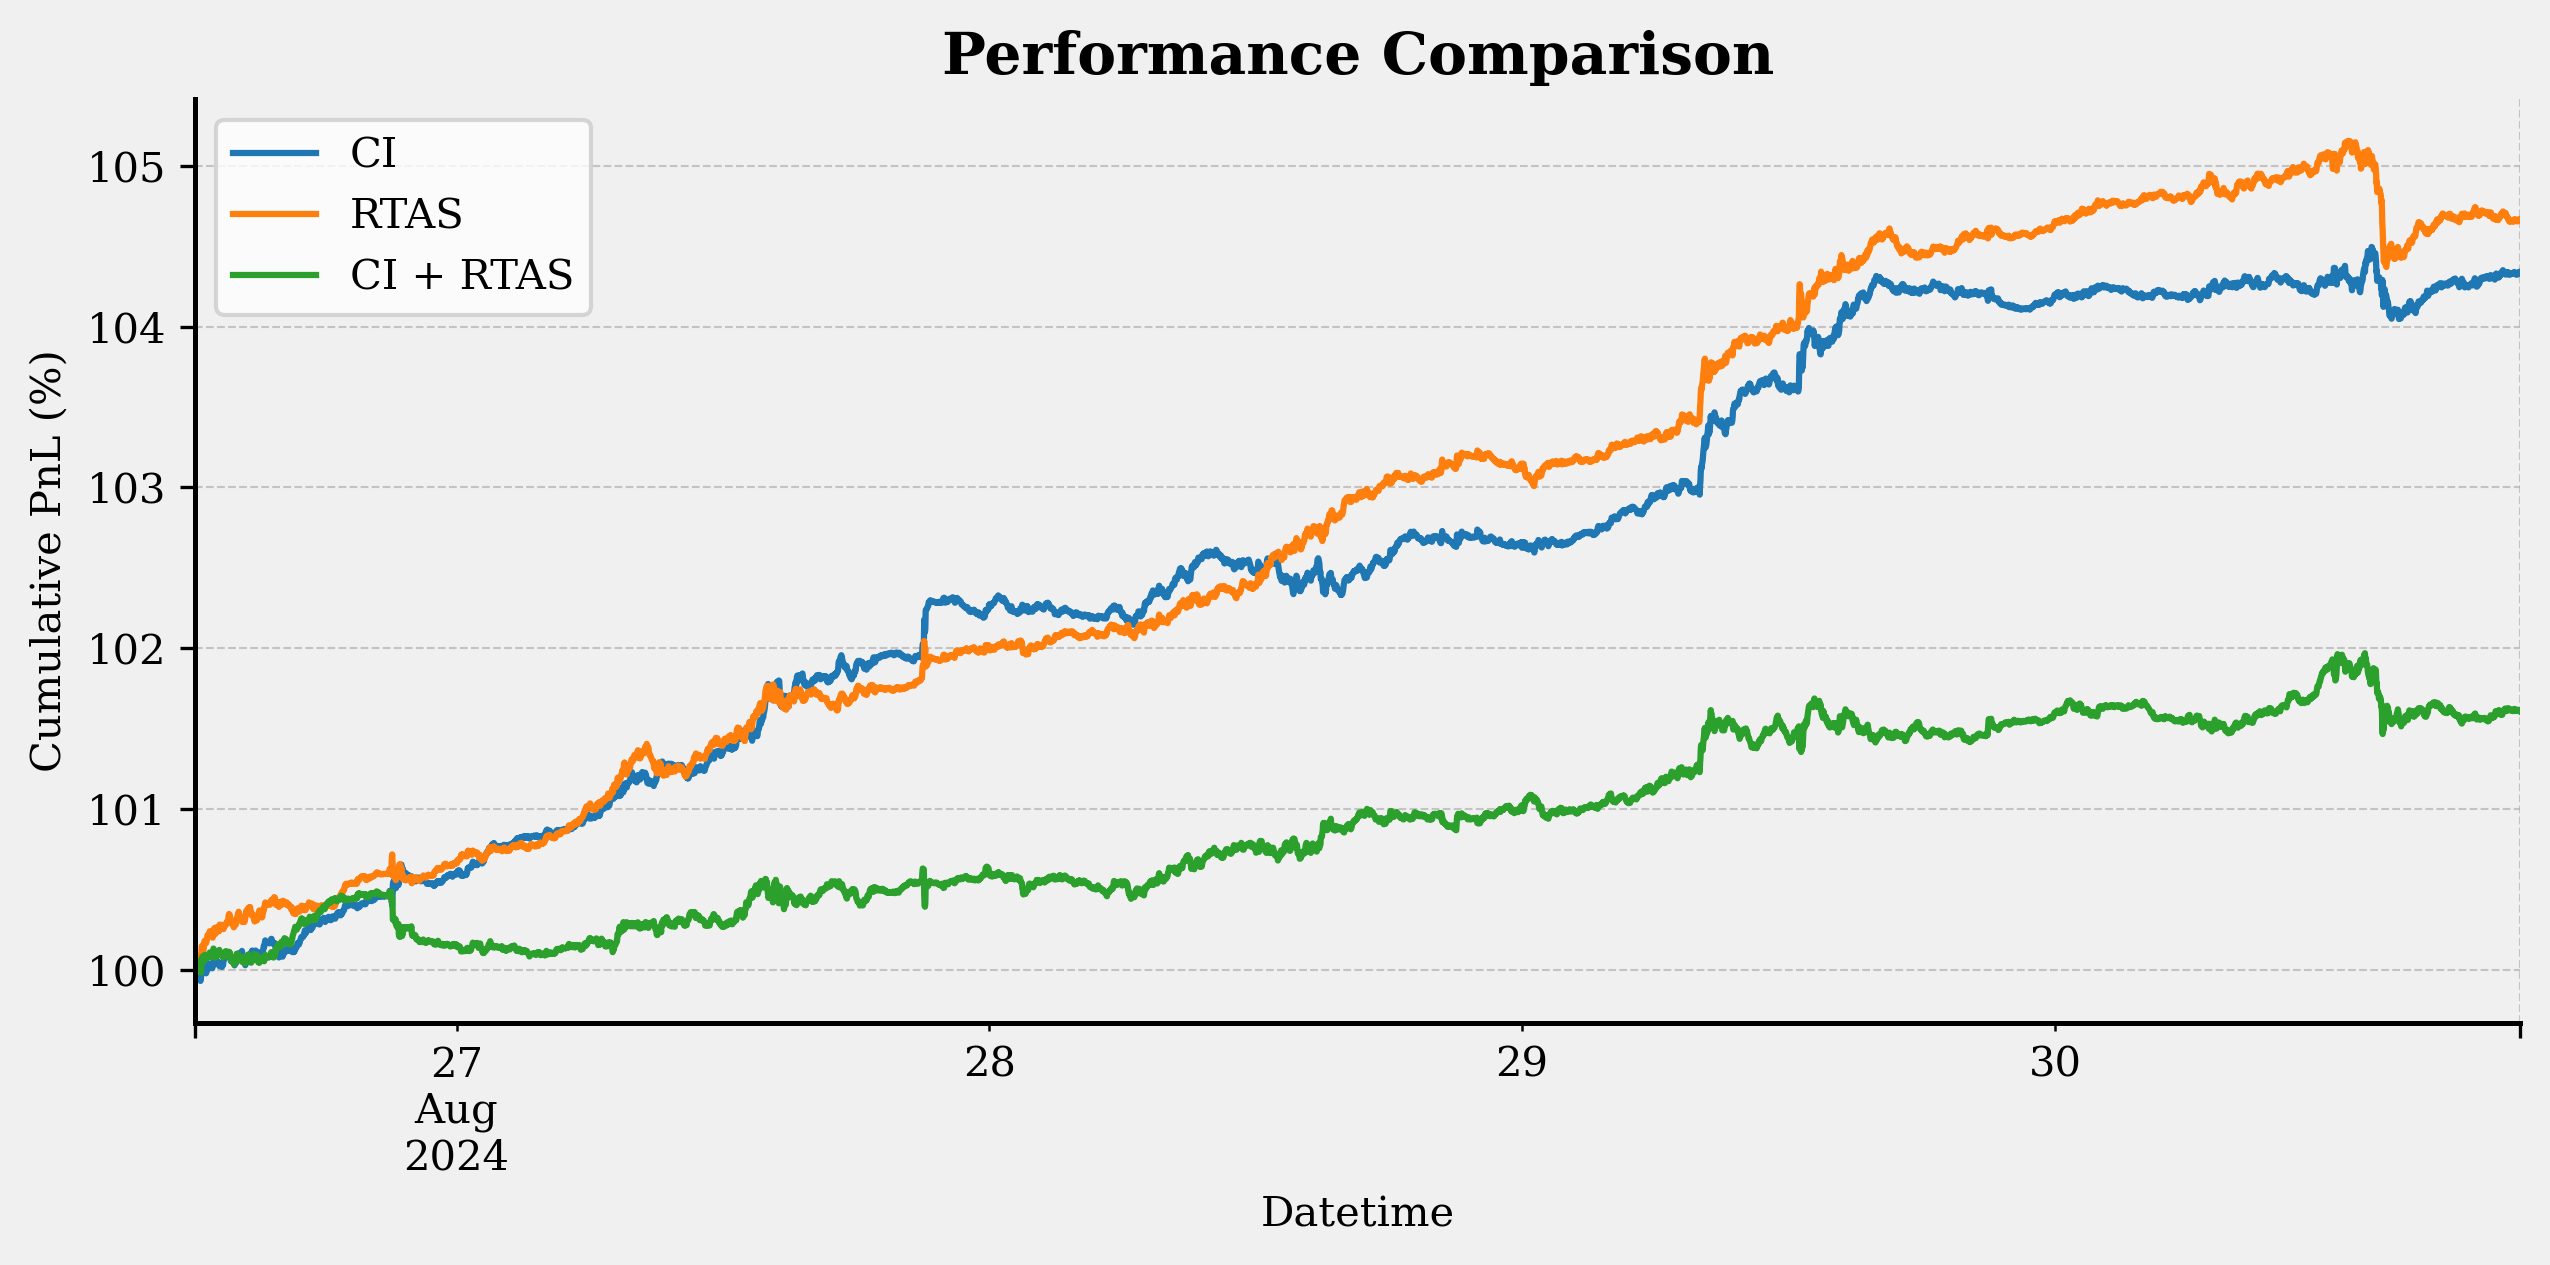

[{'Sharpe Ratio': 20.045274837425314, 'Sortino Ratio': 28.723732164076658, 'Max Drawdown': -0.004284310820012793, 'Frequency': 'minute'}, {'Sharpe Ratio': 21.53163586361533, 'Sortino Ratio': 28.36800699301247, 'Max Drawdown': -0.007455332845857643, 'Frequency': 'minute'}, {'Sharpe Ratio': 7.5229582769400904, 'Sortino Ratio': 9.399657917070508, 'Max Drawdown': -0.004930651356837901, 'Frequency': 'minute'}]
USDJPY
LSTM IS BEST!
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation Accuracy Scores: {'TI': 0.5498648003817401, 'Sig': 0.5478081321473952, 'TI_and_Sig': 0.5317662007623888}



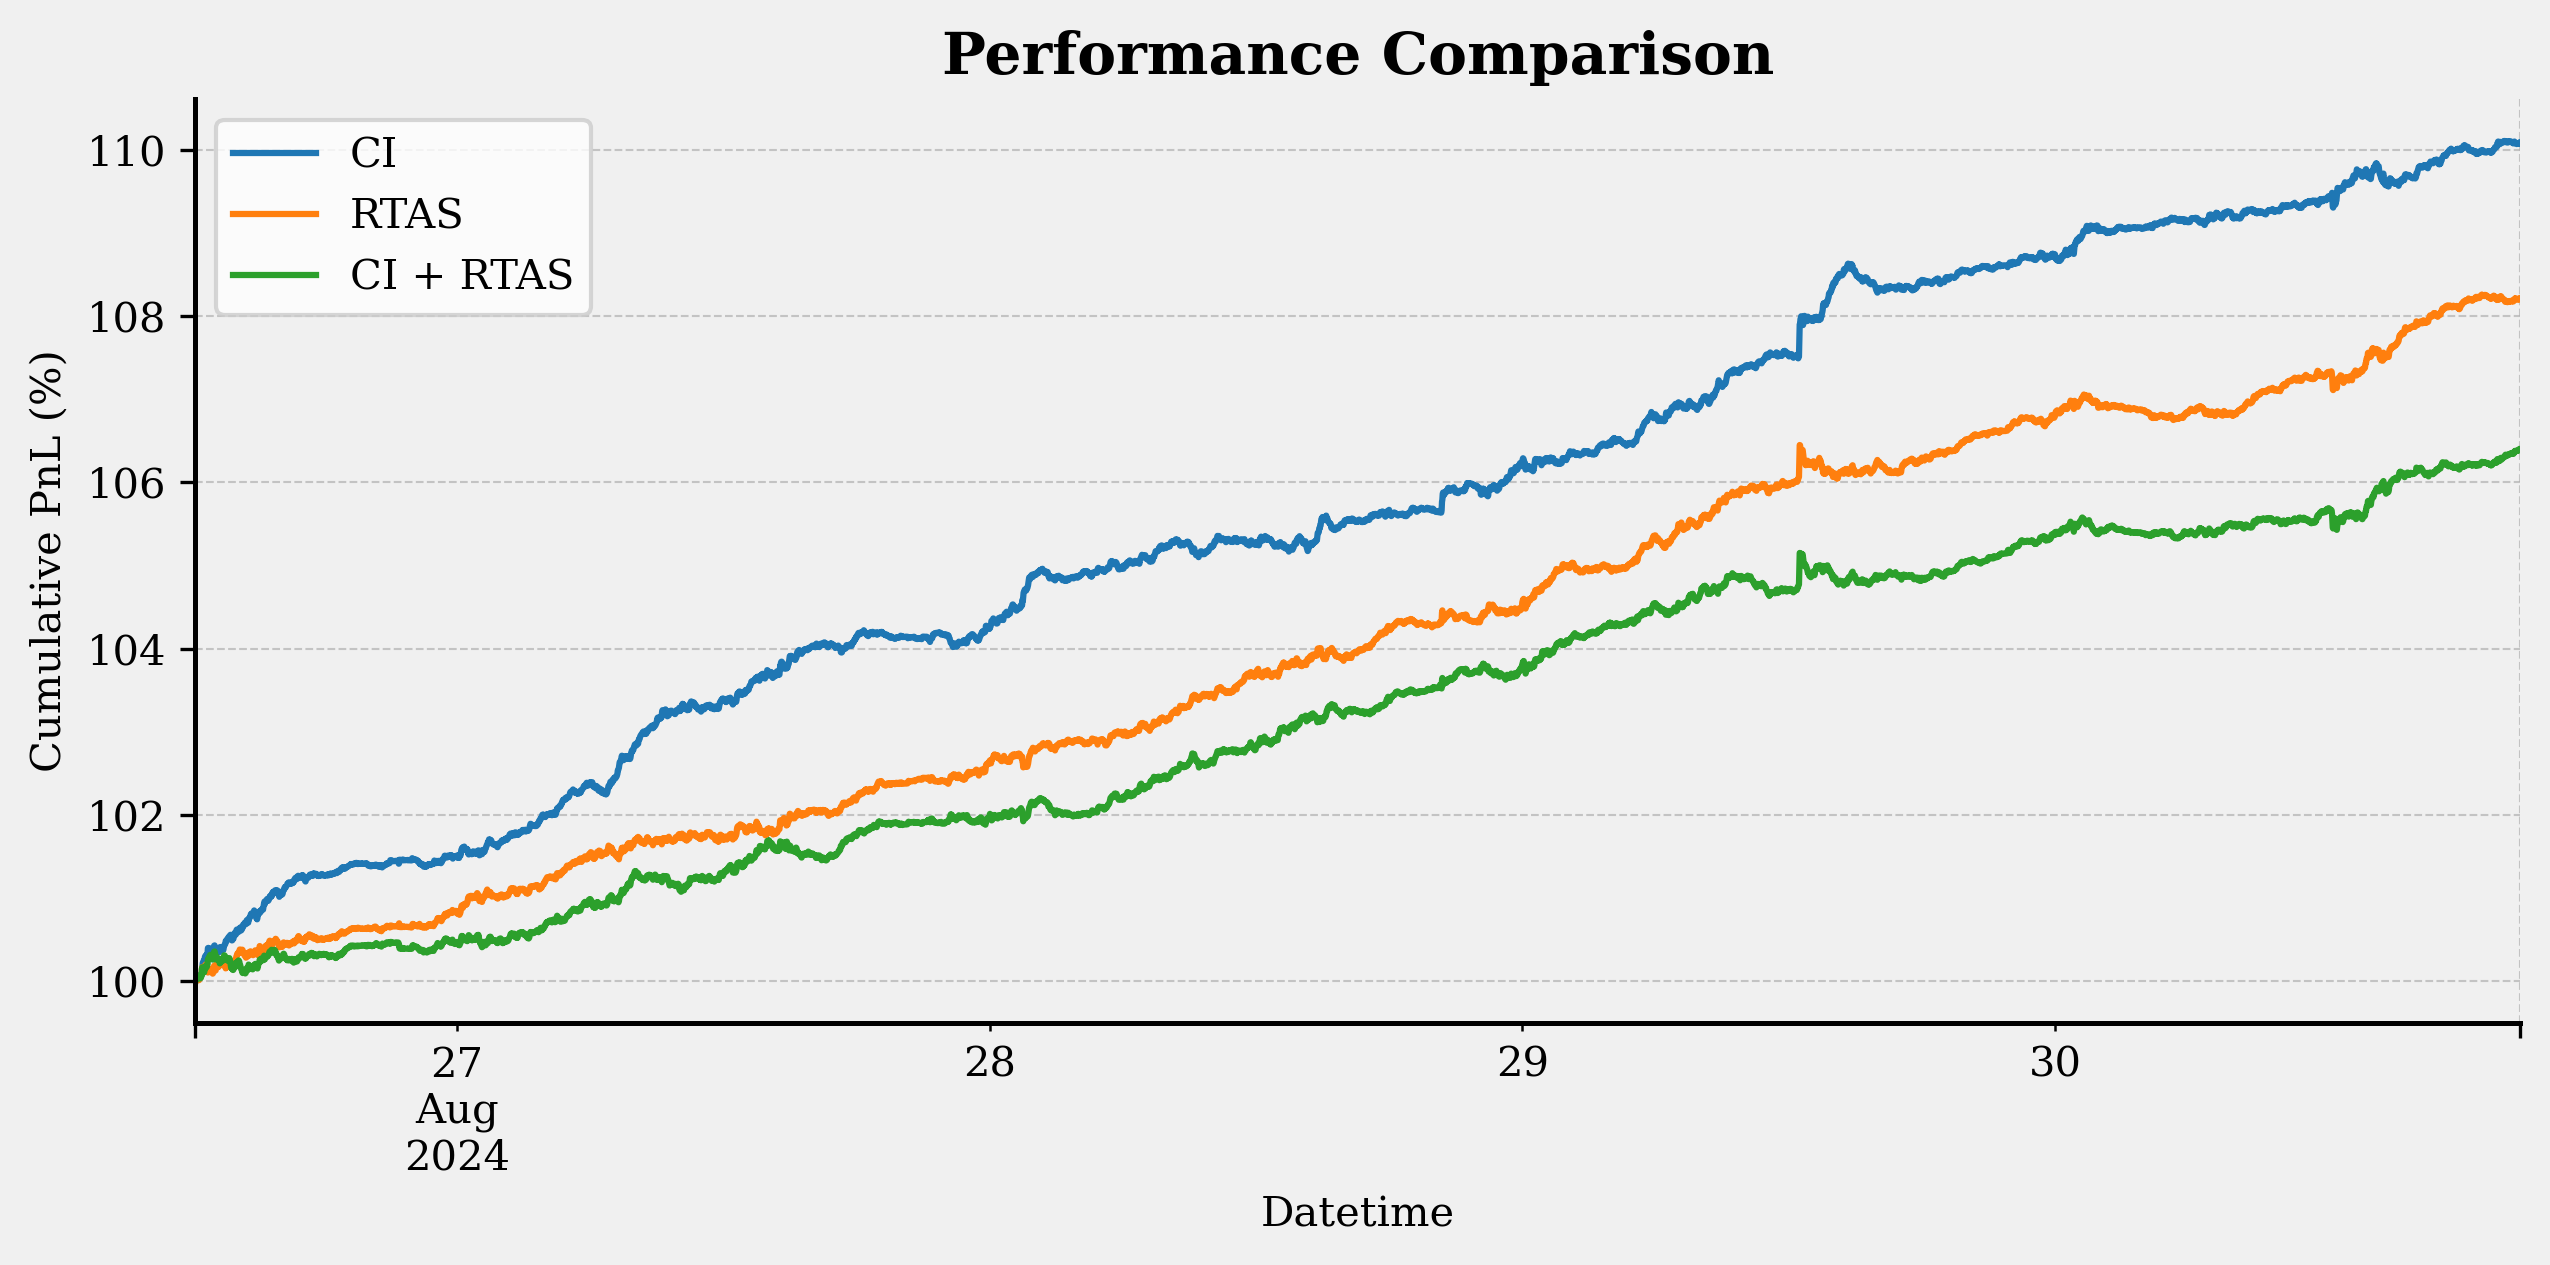

[{'Sharpe Ratio': 37.94070879430473, 'Sortino Ratio': 60.496185043050964, 'Max Drawdown': -0.003211780691541488, 'Frequency': 'minute'}, {'Sharpe Ratio': 31.079946736887567, 'Sortino Ratio': 46.222449324206565, 'Max Drawdown': -0.0037759915293459345, 'Frequency': 'minute'}, {'Sharpe Ratio': 24.3793072805158, 'Sortino Ratio': 36.465114271784444, 'Max Drawdown': -0.00373494024469323, 'Frequency': 'minute'}]
Commods
AG
LSTM IS BEST!
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM IS BEST!
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Validation Accuracy Scores: {'TI': 0.4894433781190019, 'Sig': 0.4679245283018868, 'TI_and_Sig': 0.508637236084453}



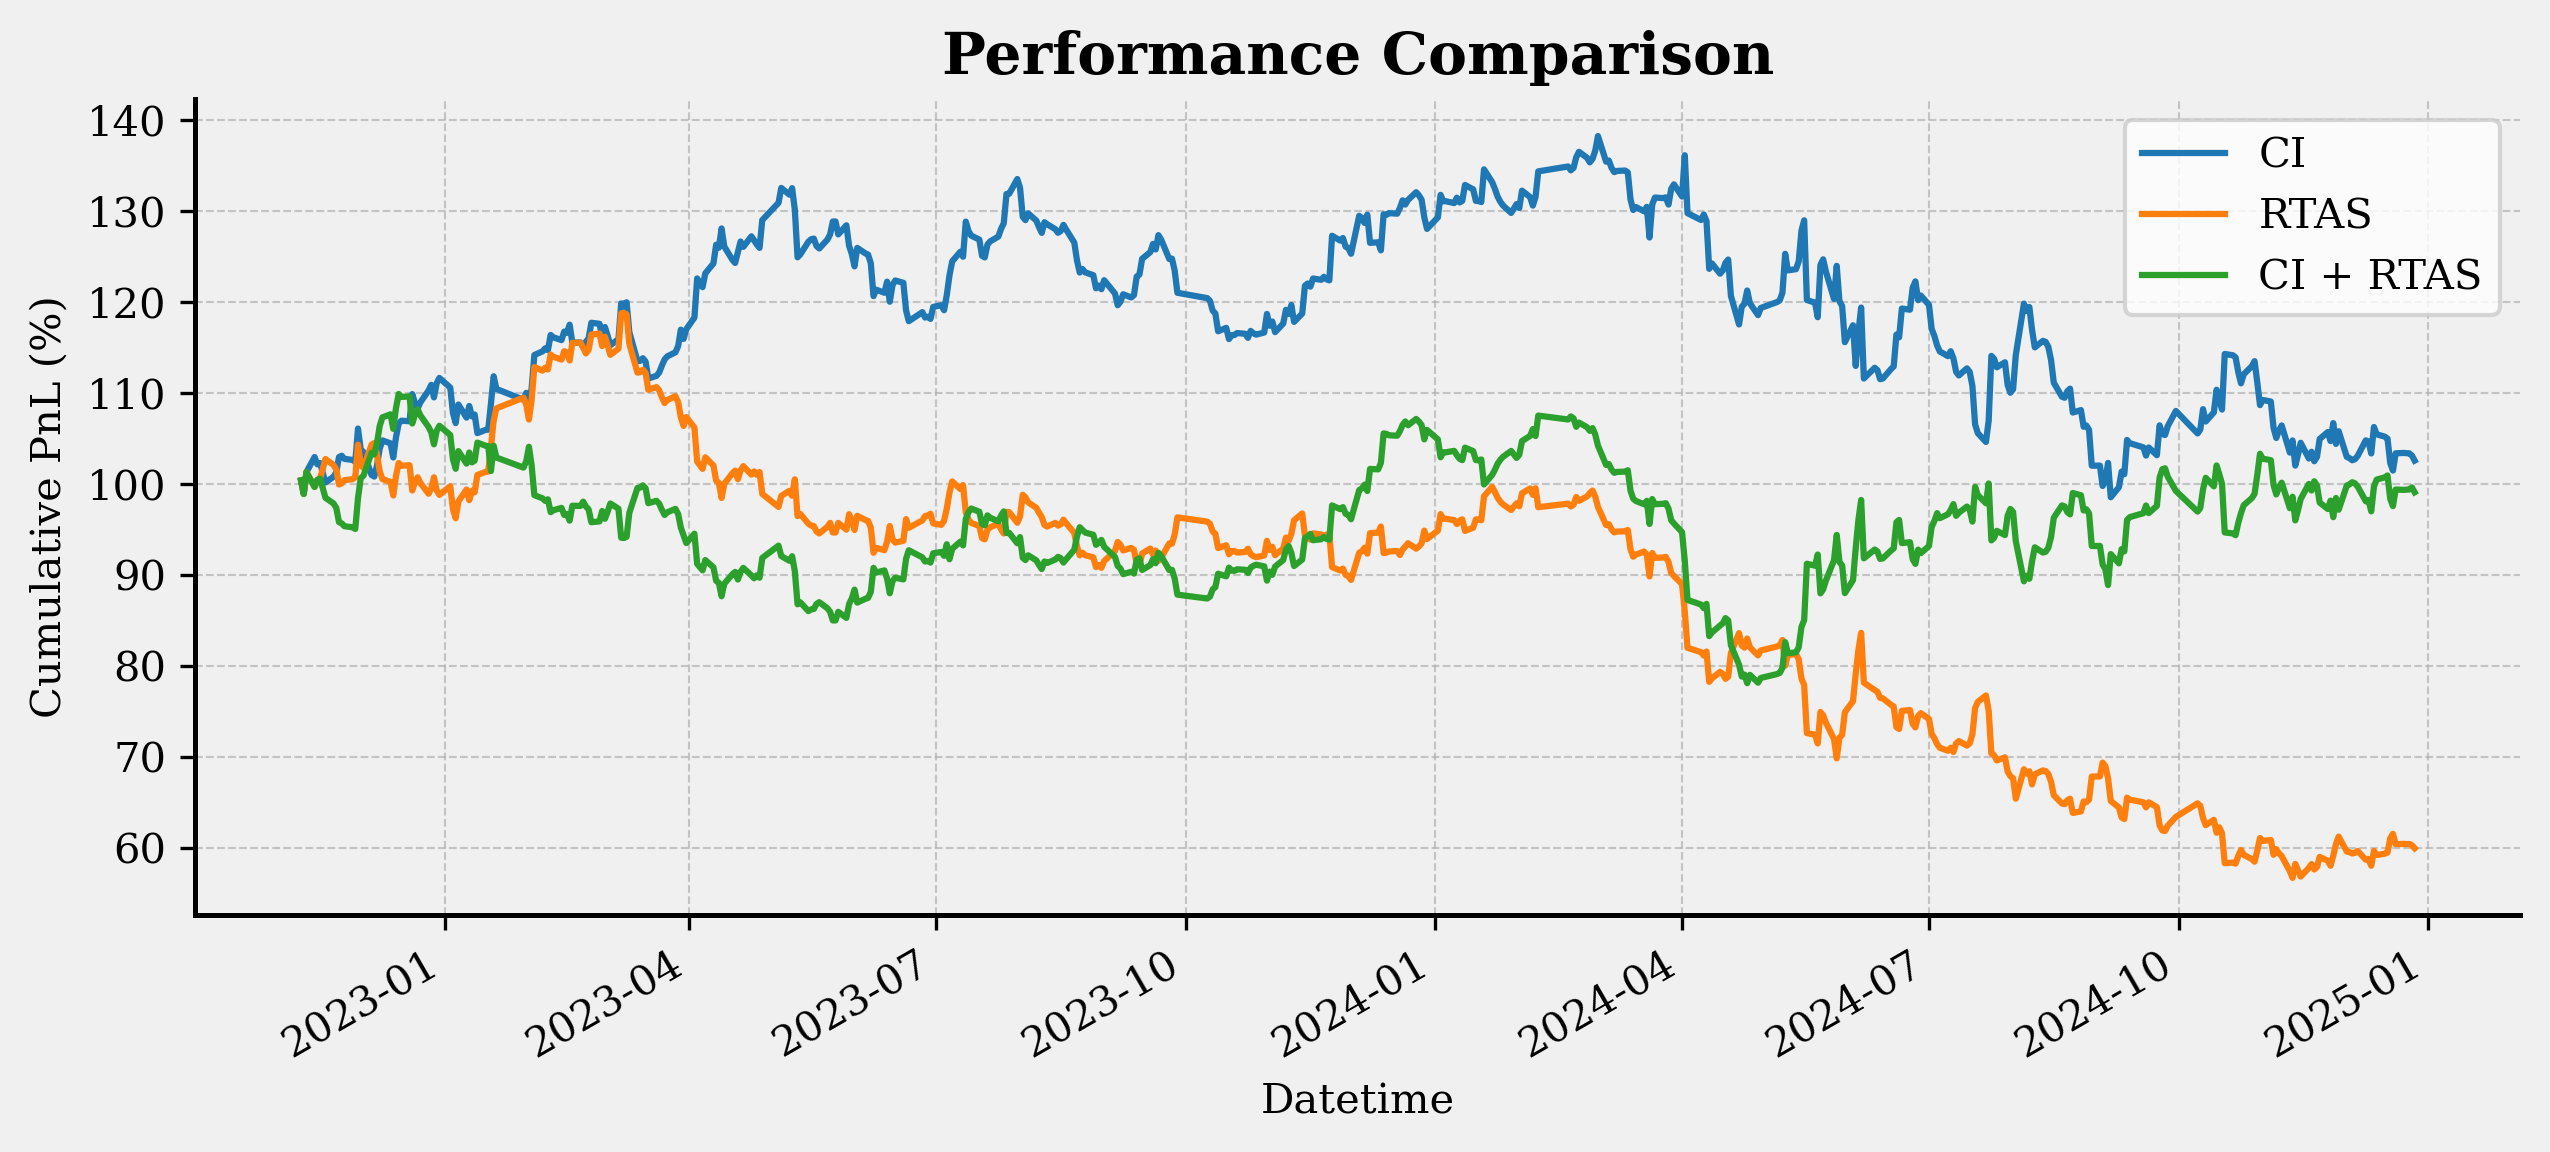

[{'Sharpe Ratio': 0.051974609325470086, 'Sortino Ratio': 0.07382397012529865, 'Max Drawdown': -0.2869061178969684, 'Frequency': 'daily'}, {'Sharpe Ratio': -1.0508963895426917, 'Sortino Ratio': -1.4086655842922329, 'Max Drawdown': -0.5221141467653897, 'Frequency': 'daily'}, {'Sharpe Ratio': -0.018839405471914334, 'Sortino Ratio': -0.025259891492247007, 'Max Drawdown': -0.28892027687329924, 'Frequency': 'daily'}]
AL
Validation Accuracy Scores: {'TI': 0.5, 'Sig': 0.4962264150943396, 'TI_and_Sig': 0.5037735849056604}



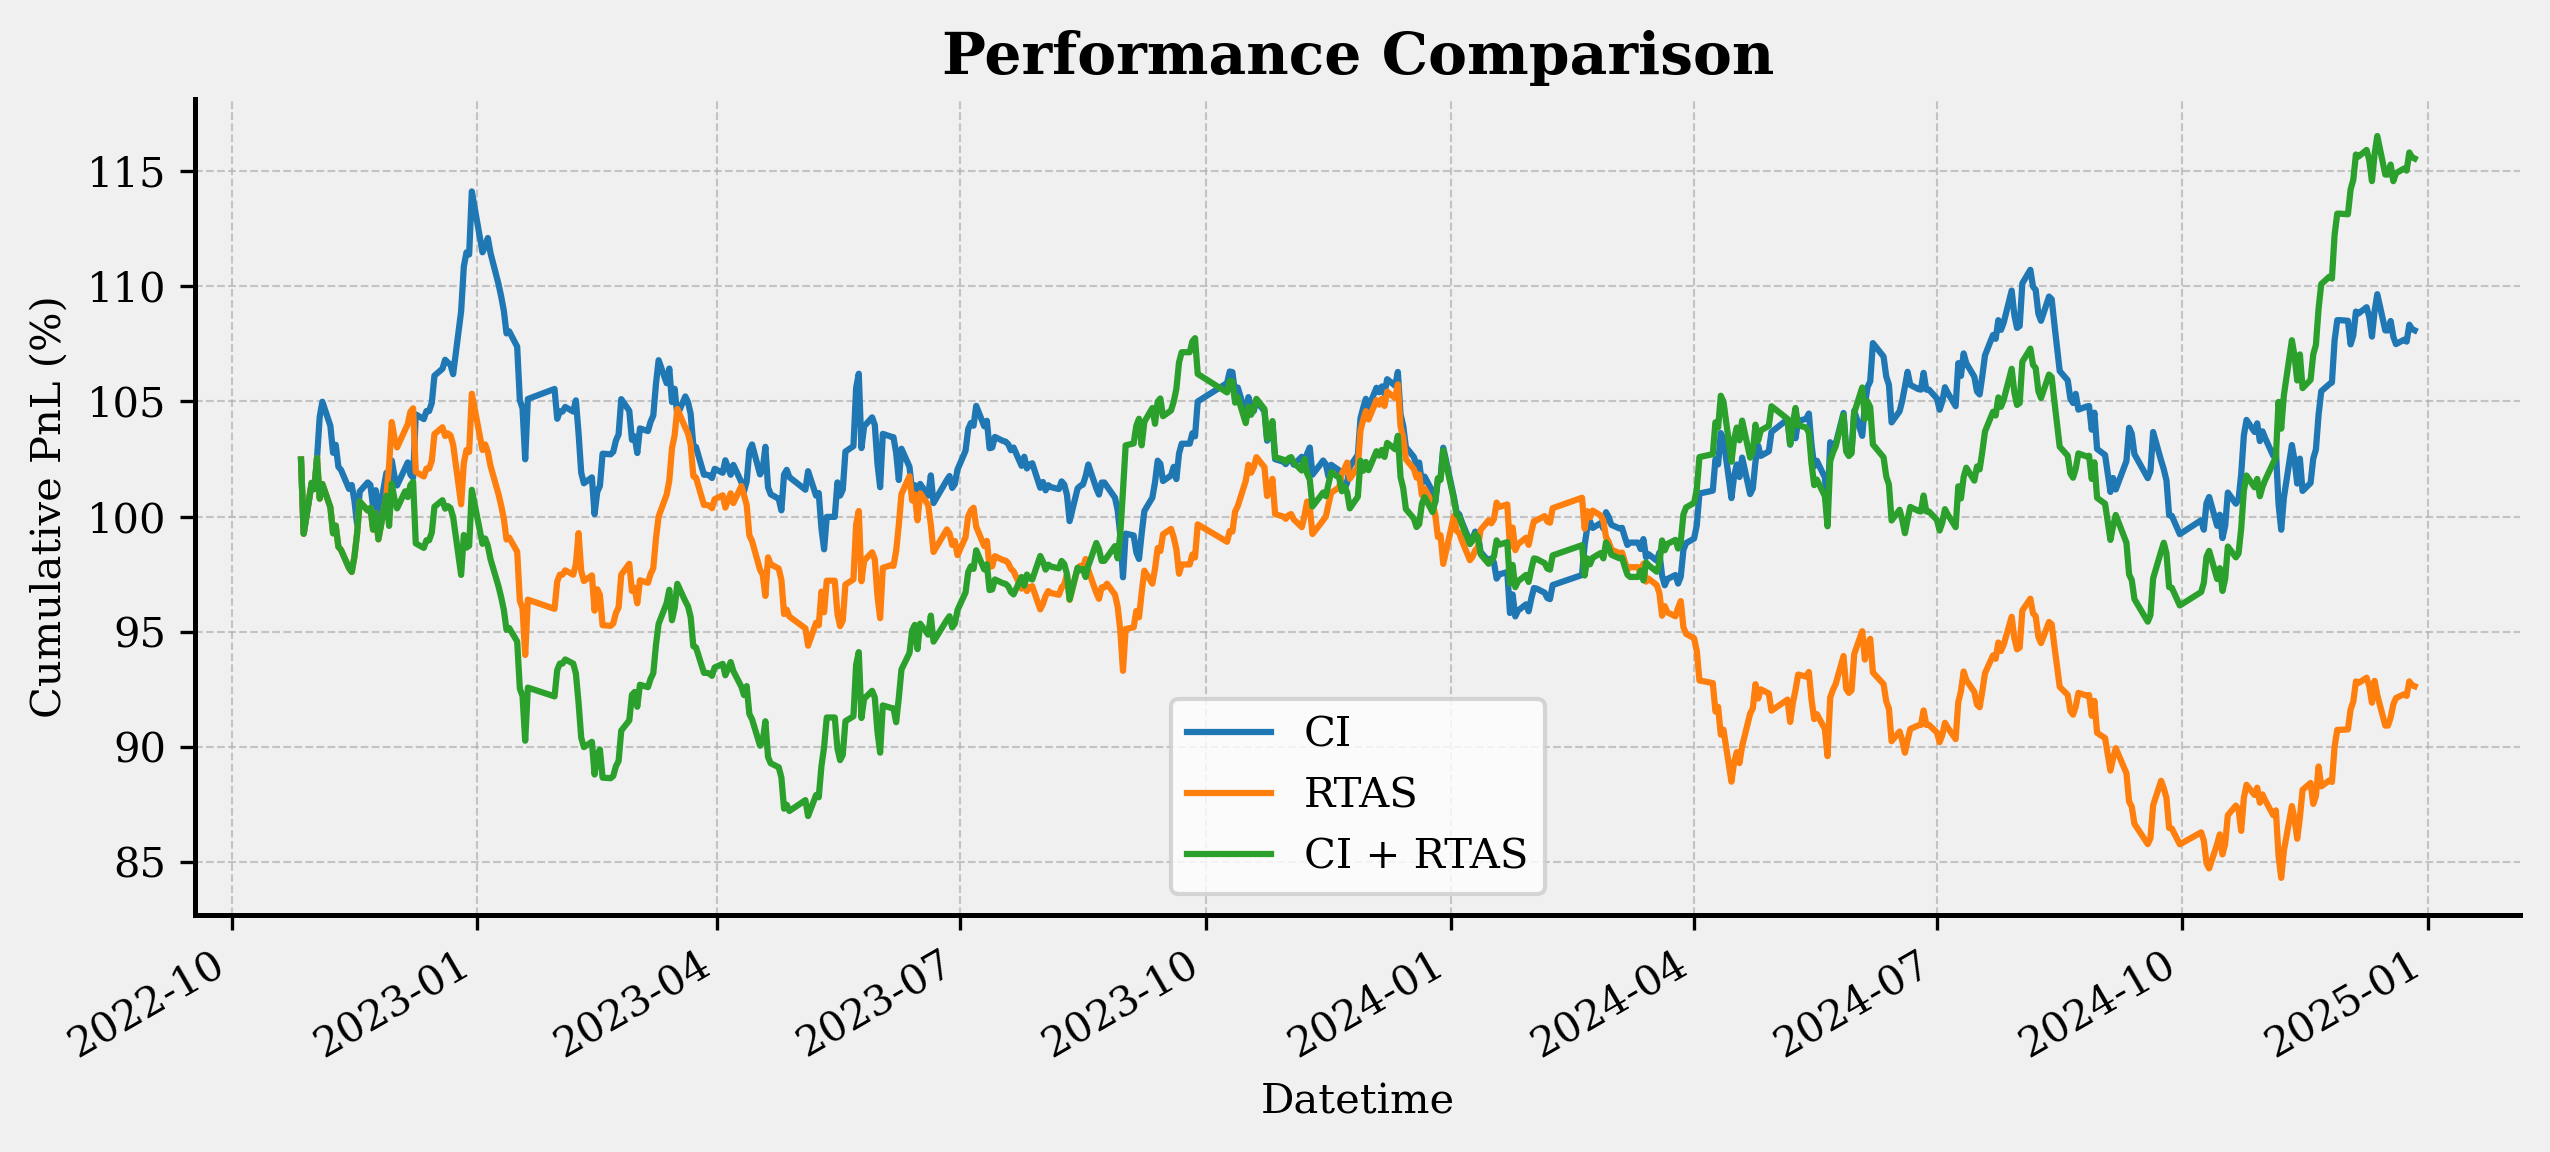

[{'Sharpe Ratio': 0.26605674054969264, 'Sortino Ratio': 0.4264888689404723, 'Max Drawdown': -0.1616747856355335, 'Frequency': 'daily'}, {'Sharpe Ratio': -0.2620193292610642, 'Sortino Ratio': -0.4041451973598854, 'Max Drawdown': -0.20260026115364482, 'Frequency': 'daily'}, {'Sharpe Ratio': 0.494709456904384, 'Sortino Ratio': 0.7488963156703908, 'Max Drawdown': -0.1515389176892883, 'Frequency': 'daily'}]
AU
LSTM IS BEST!
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Validation Accuracy Scores: {'TI': 0.49245283018867925, 'Sig': 0.5508637236084453, 'TI_and_Sig': 0.4849056603773585}



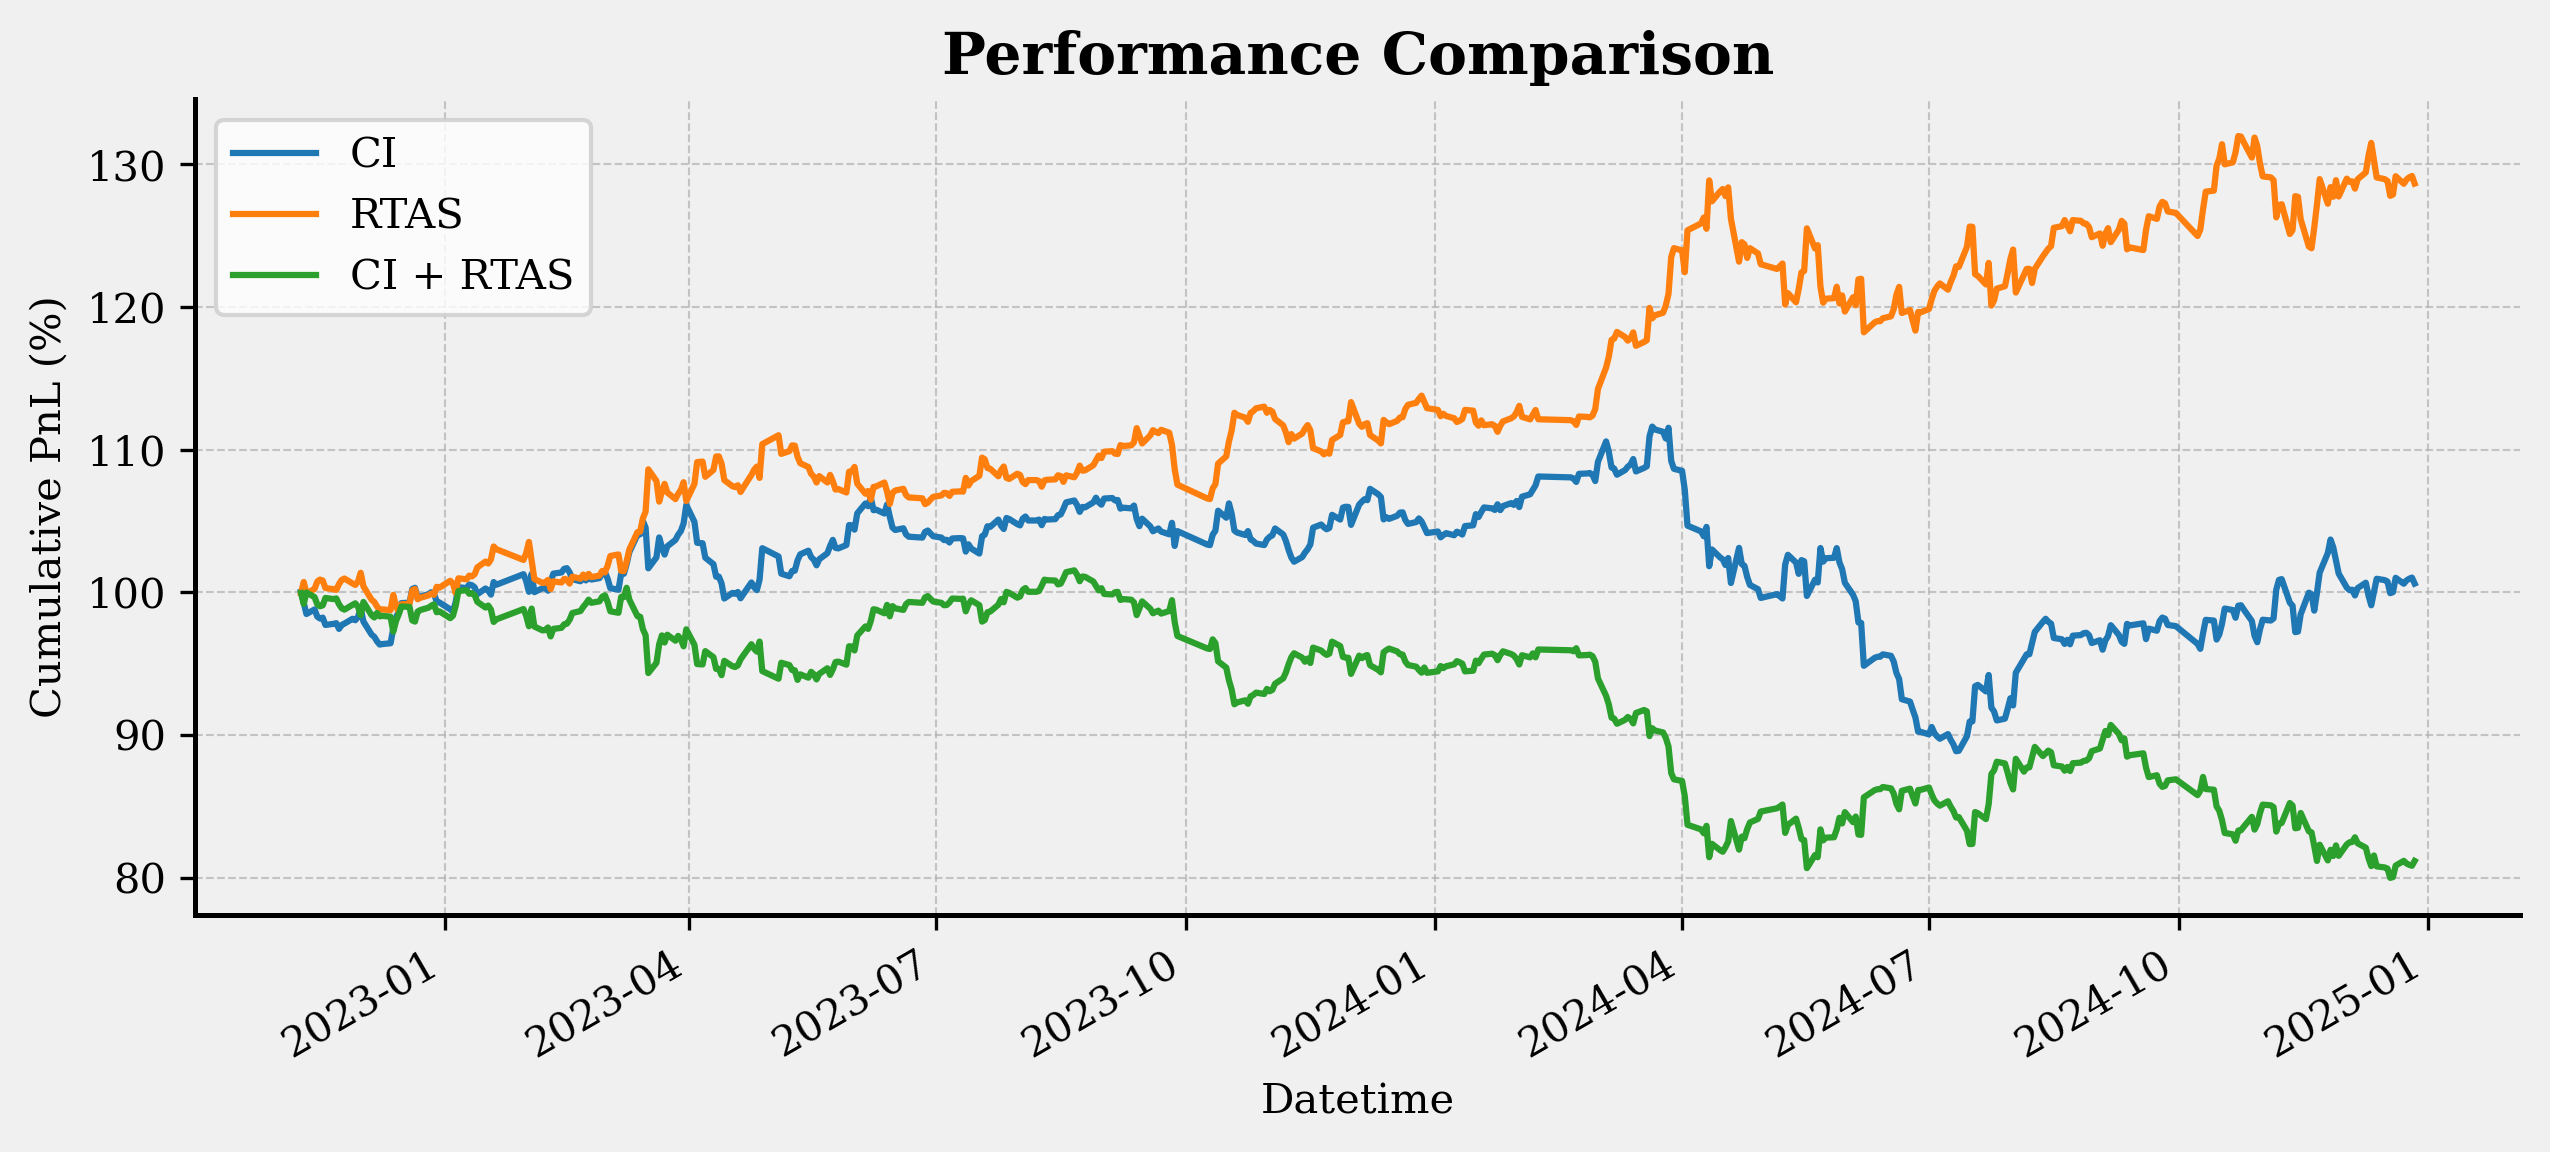

[{'Sharpe Ratio': 0.02629104643971276, 'Sortino Ratio': 0.0370415754604755, 'Max Drawdown': -0.20391602684689647, 'Frequency': 'daily'}, {'Sharpe Ratio': 1.0809281676213824, 'Sortino Ratio': 1.4176209625583114, 'Max Drawdown': -0.0826359928475815, 'Frequency': 'daily'}, {'Sharpe Ratio': -0.8944743091388249, 'Sortino Ratio': -1.2228737318529475, 'Max Drawdown': -0.21234953193548944, 'Frequency': 'daily'}]
A


C:\Users\prane\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation Accuracy Scores: {'TI': 0.5509433962264151, 'Sig': 0.5358490566037736, 'TI_and_Sig': 0.5471698113207547}



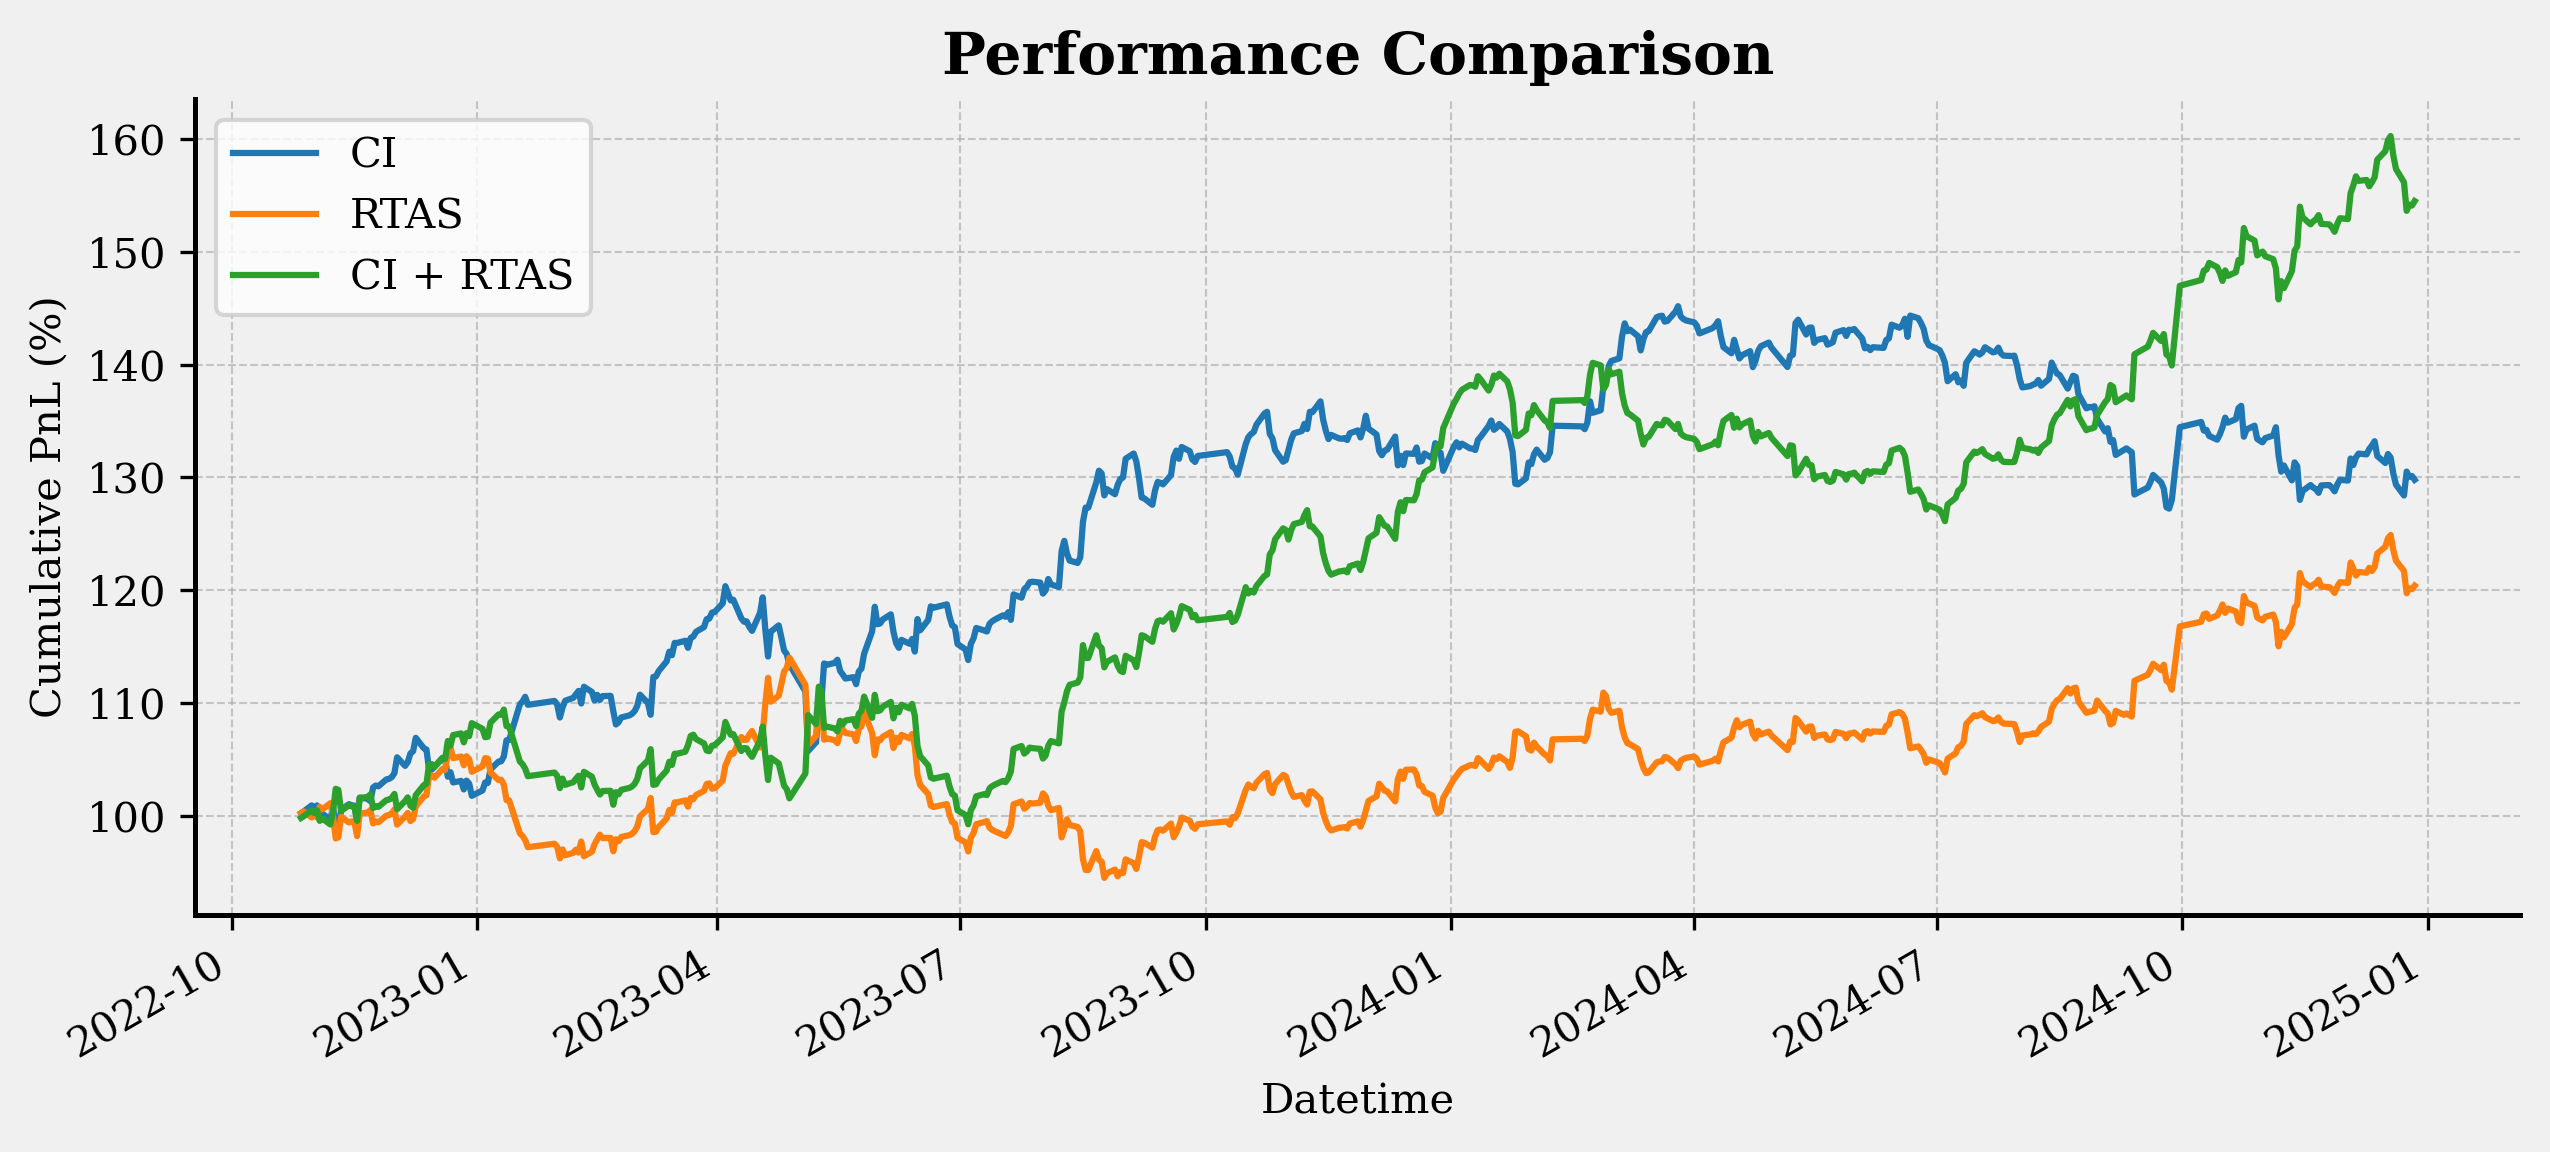

[{'Sharpe Ratio': 0.9334889498531755, 'Sortino Ratio': 1.3465370272678479, 'Max Drawdown': -0.12368624554898489, 'Frequency': 'daily'}, {'Sharpe Ratio': 0.6639646505320795, 'Sortino Ratio': 0.9189511463058431, 'Max Drawdown': -0.17137319975901777, 'Frequency': 'daily'}, {'Sharpe Ratio': 1.5626711784946277, 'Sortino Ratio': 2.4418483051693127, 'Max Drawdown': -0.10953632791088386, 'Frequency': 'daily'}]
CF
LSTM IS BEST!
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
LSTM IS BEST!
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Validation Accuracy Scores: {'TI': 0.4990403071017274, 'Sig': 0.5547169811320755, 'TI_and_Sig': 0.5067178502879078}



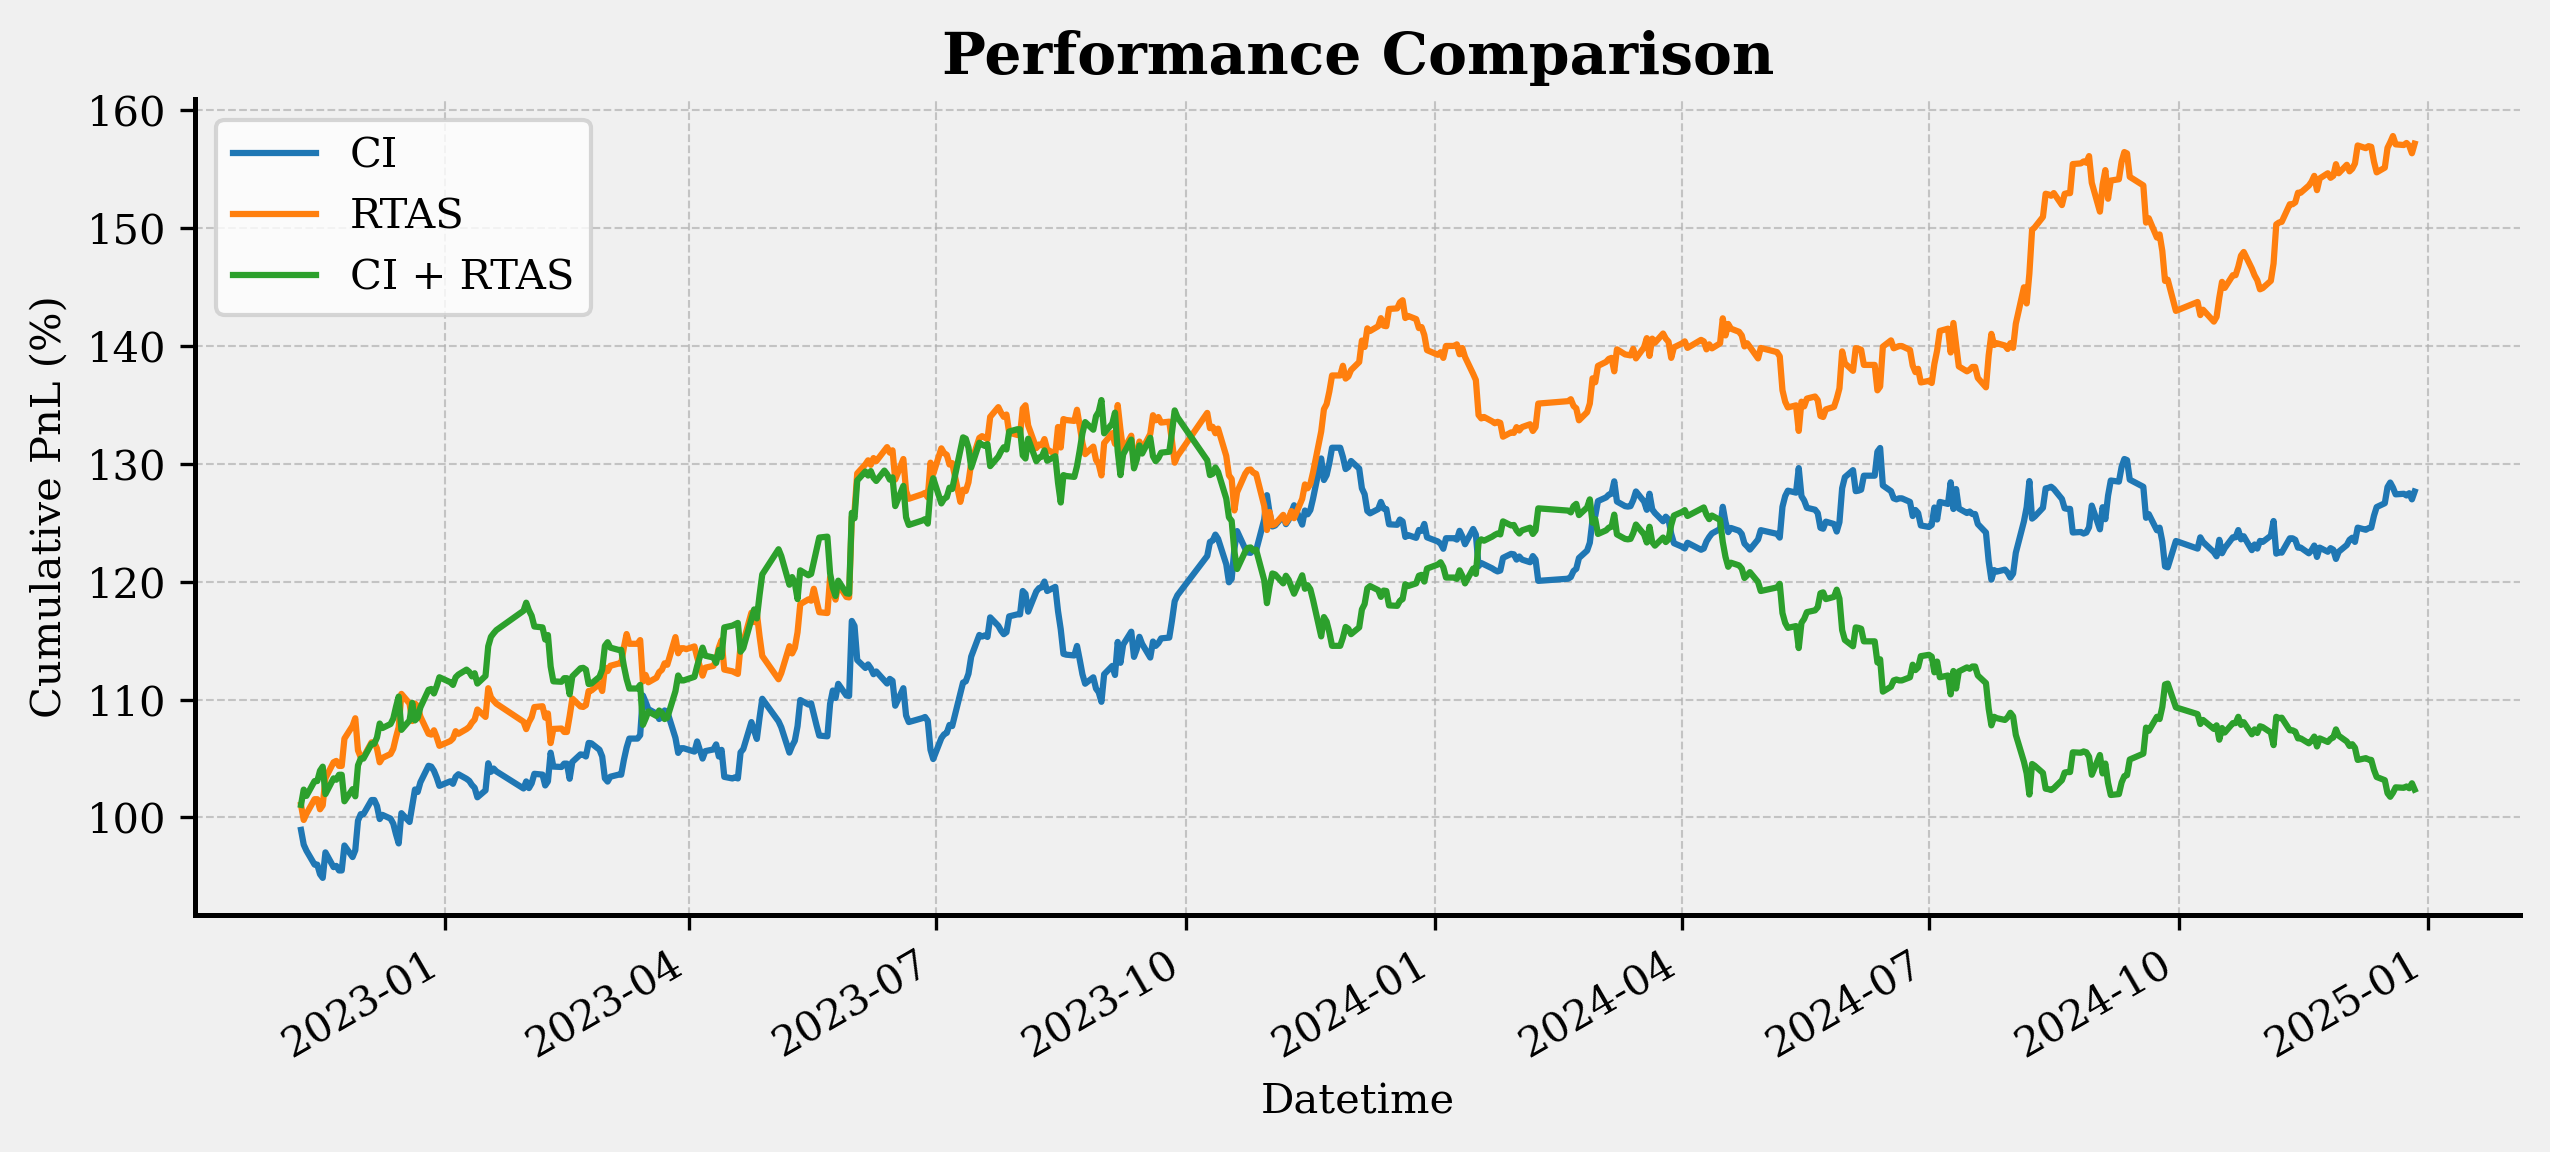

[{'Sharpe Ratio': 0.782717647548526, 'Sortino Ratio': 1.2885859435774958, 'Max Drawdown': -0.10037943305287111, 'Frequency': 'daily'}, {'Sharpe Ratio': 1.453957799774551, 'Sortino Ratio': 2.3251764189552446, 'Max Drawdown': -0.09192795149492661, 'Frequency': 'daily'}, {'Sharpe Ratio': 0.07479789647403907, 'Sortino Ratio': 0.10662440636153728, 'Max Drawdown': -0.24852237545736044, 'Frequency': 'daily'}]
CU
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM IS BEST!
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Validation Accuracy Scores: {'TI': 0.49056603773584906, 'Sig': 0.5124760076775432, 'TI_and_Sig': 0.4981132075471698}



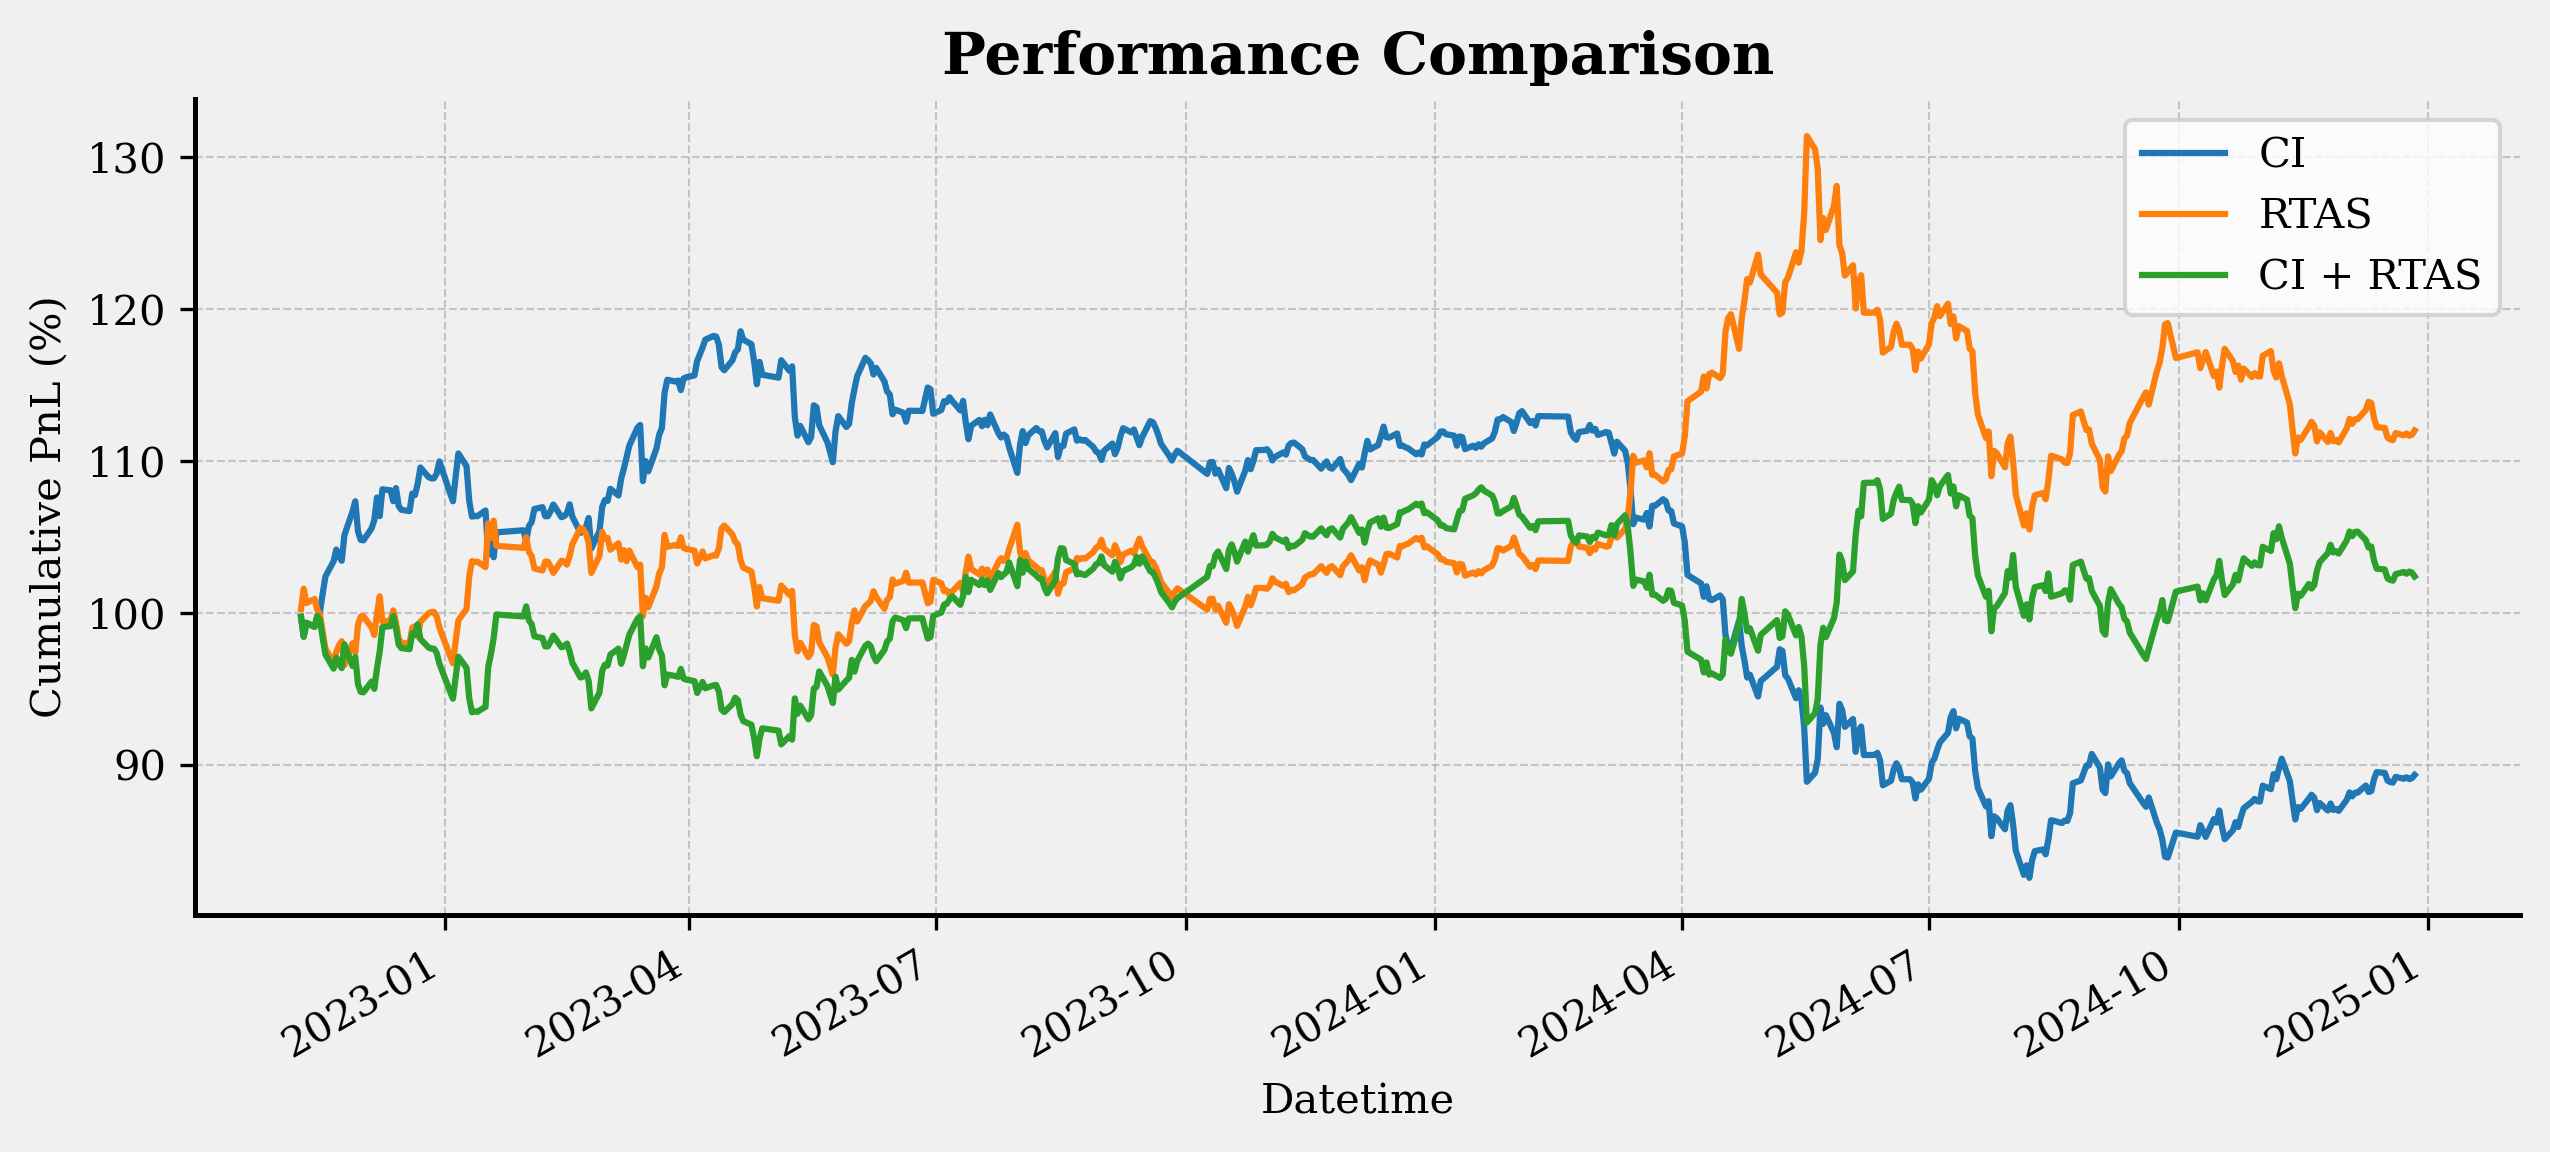

[{'Sharpe Ratio': -0.3896250231206871, 'Sortino Ratio': -0.5322100525042458, 'Max Drawdown': -0.3032228635761691, 'Frequency': 'daily'}, {'Sharpe Ratio': 0.392070477422688, 'Sortino Ratio': 0.5732505045762477, 'Max Drawdown': -0.1968923670182613, 'Frequency': 'daily'}, {'Sharpe Ratio': 0.08210164063599859, 'Sortino Ratio': 0.12573405348017735, 'Max Drawdown': -0.14287527611807194, 'Frequency': 'daily'}]
C
LSTM IS BEST!
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
LSTM IS BEST!
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Validation Accuracy Scores: {'TI': 0.46641074856046066, 'Sig': 0.4811320754716981, 'TI_and_Sig': 0.5566218809980806}



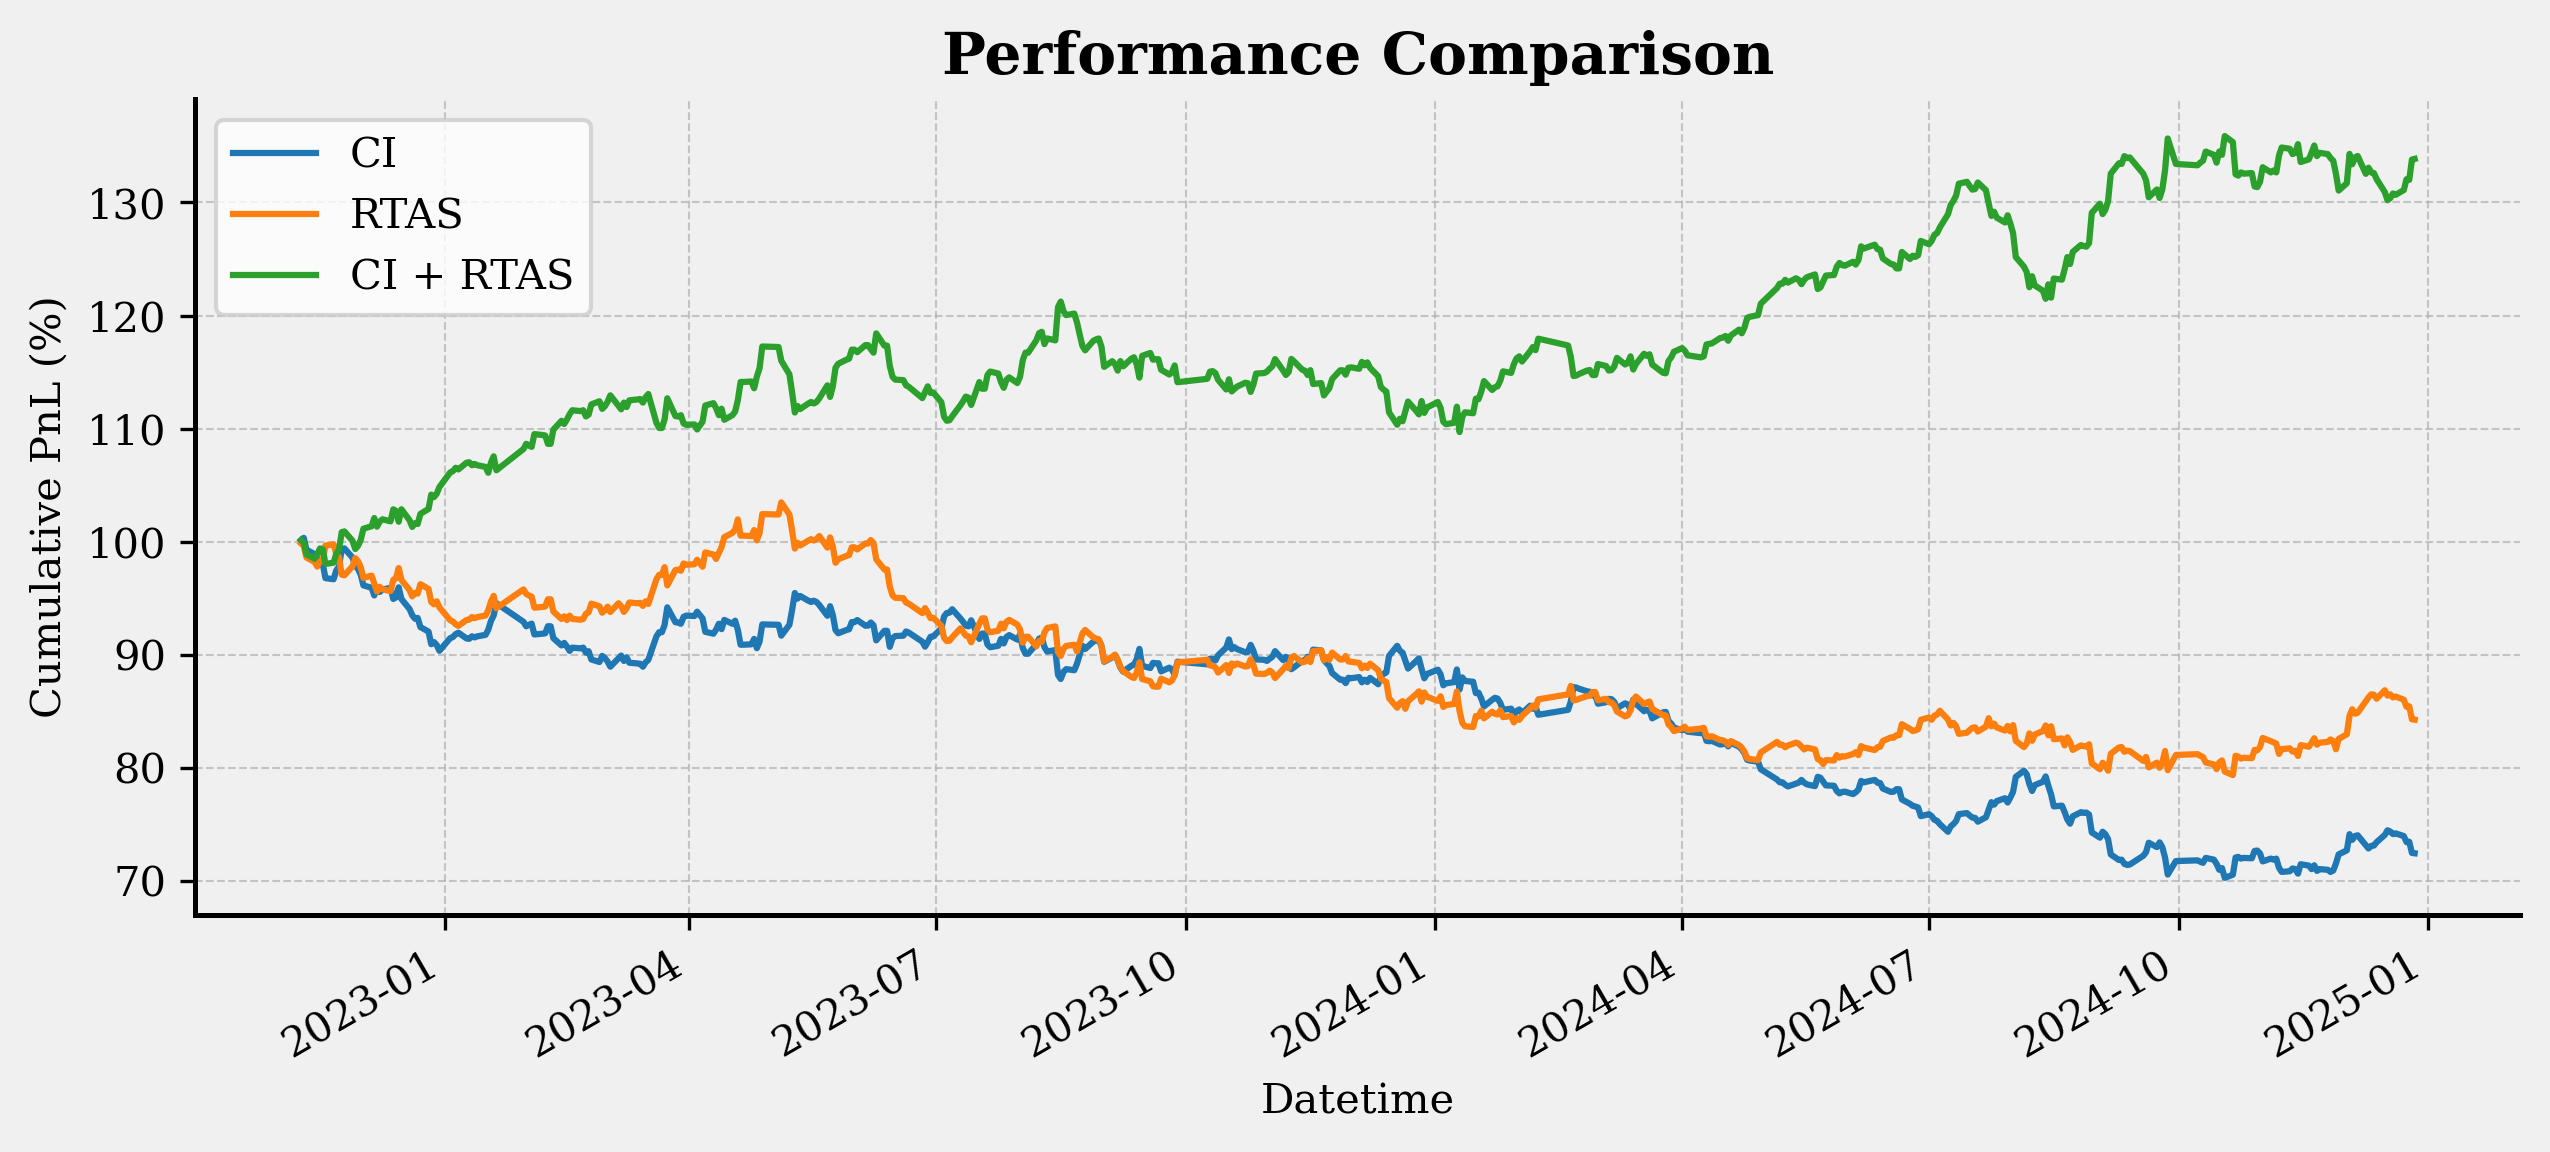

[{'Sharpe Ratio': -1.468488463563819, 'Sortino Ratio': -2.2328576126241706, 'Max Drawdown': -0.2995970210502359, 'Frequency': 'daily'}, {'Sharpe Ratio': -0.7777368127913957, 'Sortino Ratio': -1.158179589612134, 'Max Drawdown': -0.2329886584101576, 'Frequency': 'daily'}, {'Sharpe Ratio': 1.3281350694756837, 'Sortino Ratio': 2.0565596887665, 'Max Drawdown': -0.09514291626187599, 'Frequency': 'daily'}]
MA
An error occurred: With n_samples=0, test_size=0.5 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.
PM
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Validation Accuracy Scores: {'TI': 0.8626198083067093, 'Sig': 0.8626198083067093, 'TI_and_Sig': 0.8626198083067093}



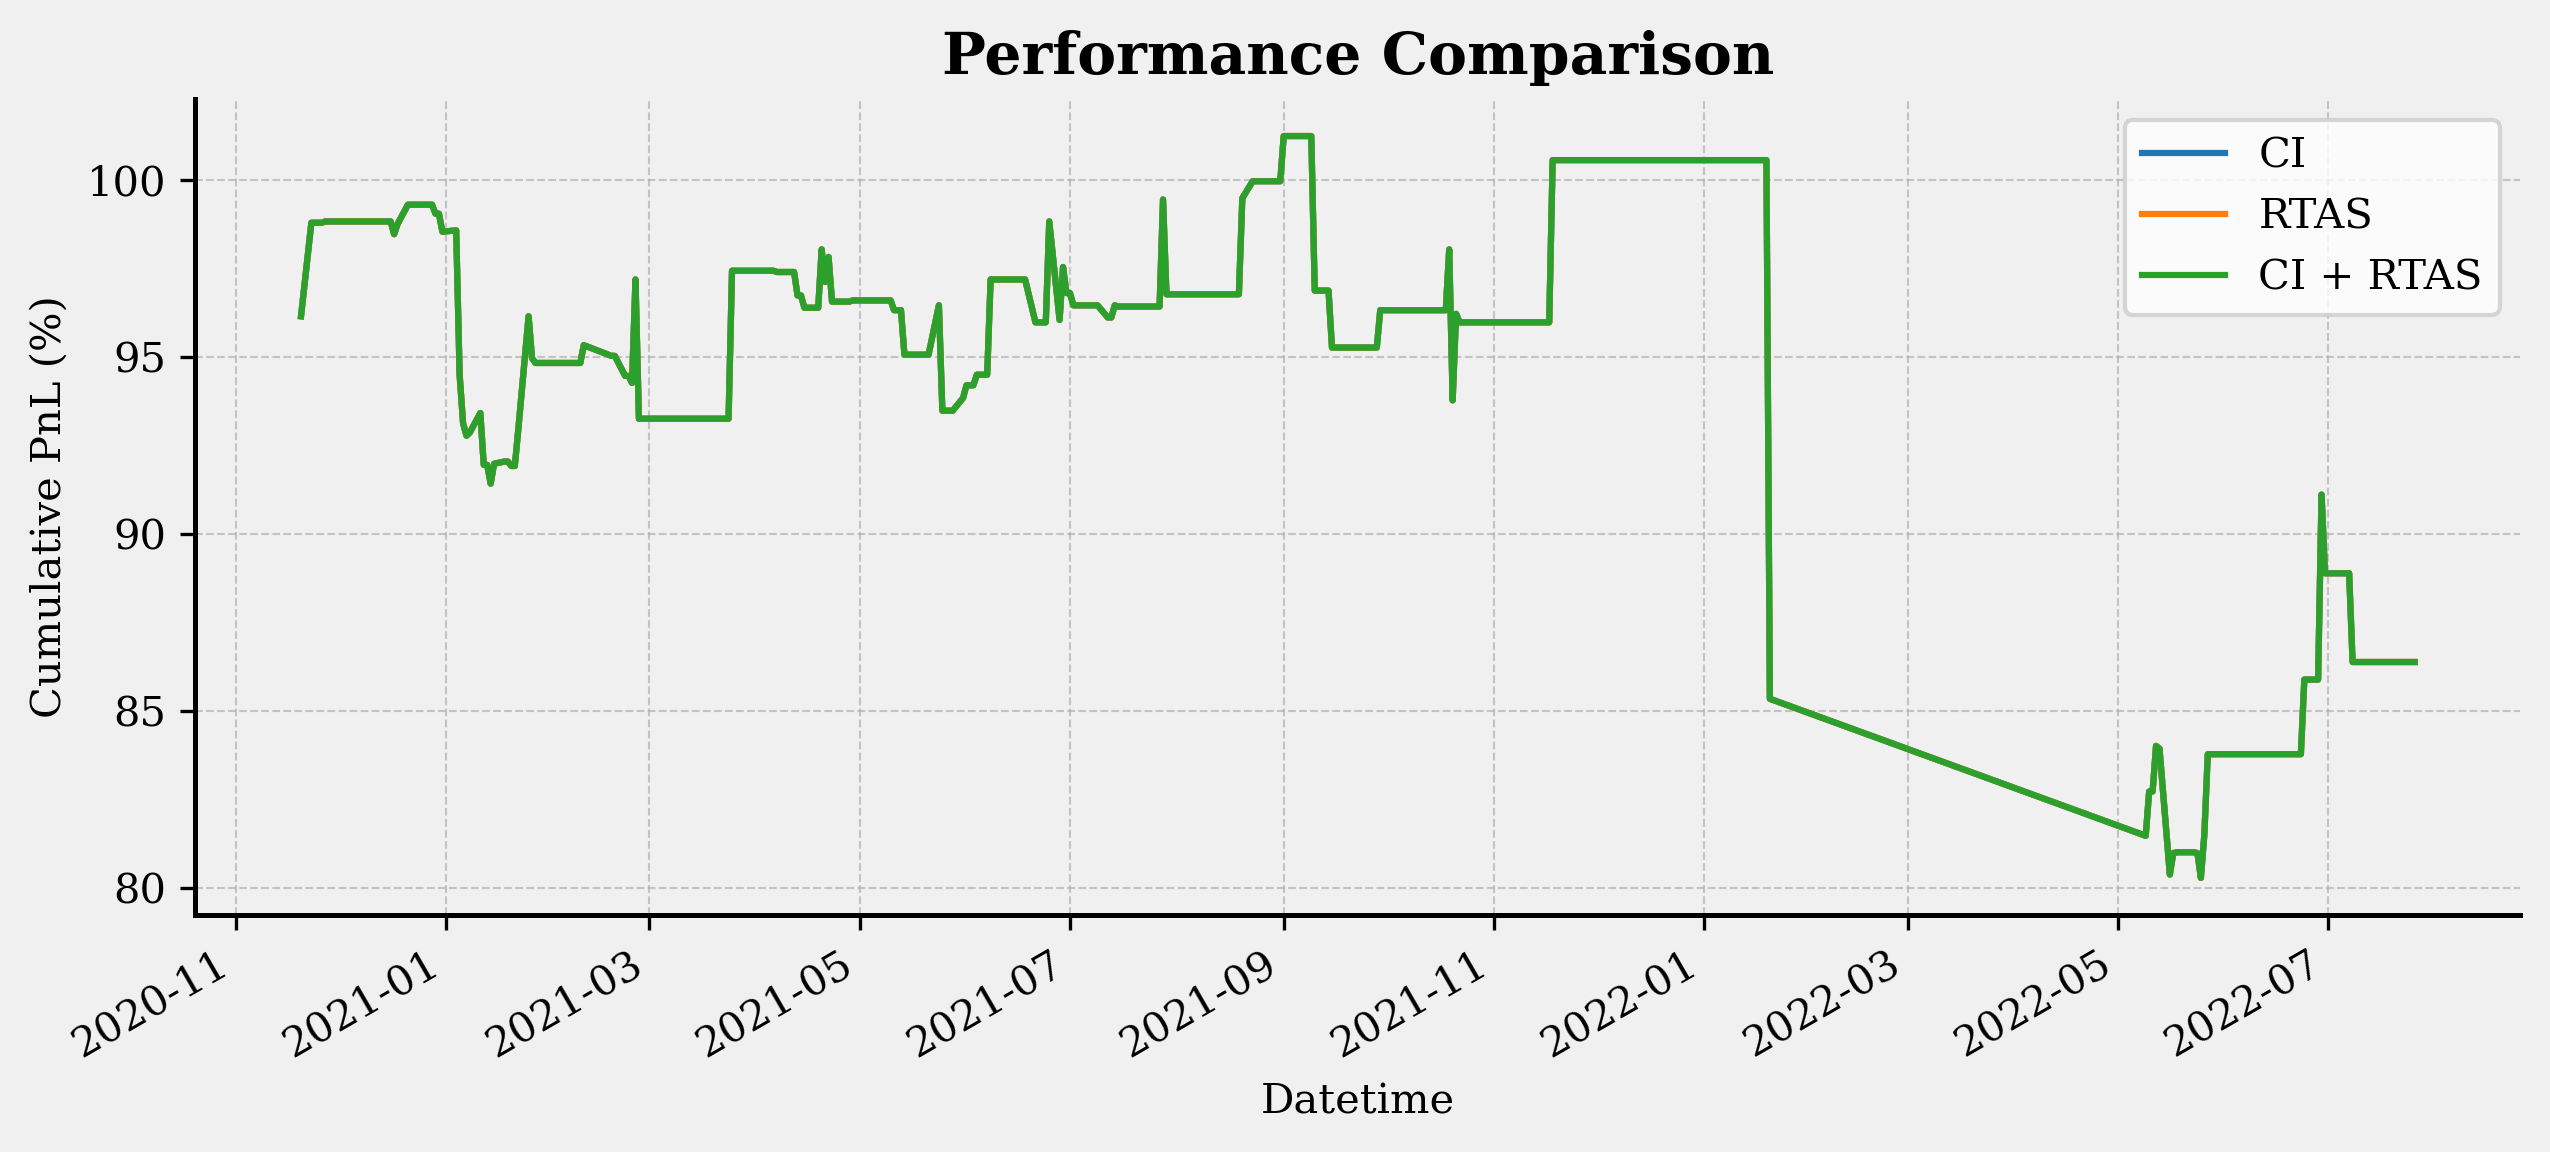

[{'Sharpe Ratio': -0.5194201240013043, 'Sortino Ratio': -0.27308288829153105, 'Max Drawdown': -0.20690681750521023, 'Frequency': 'daily'}, {'Sharpe Ratio': -0.5194201240013043, 'Sortino Ratio': -0.27308288829153105, 'Max Drawdown': -0.20690681750521023, 'Frequency': 'daily'}, {'Sharpe Ratio': -0.5194201240013043, 'Sortino Ratio': -0.27308288829153105, 'Max Drawdown': -0.20690681750521023, 'Frequency': 'daily'}]
RU
Validation Accuracy Scores: {'TI': 0.5264150943396226, 'Sig': 0.5056603773584906, 'TI_and_Sig': 0.5132075471698113}



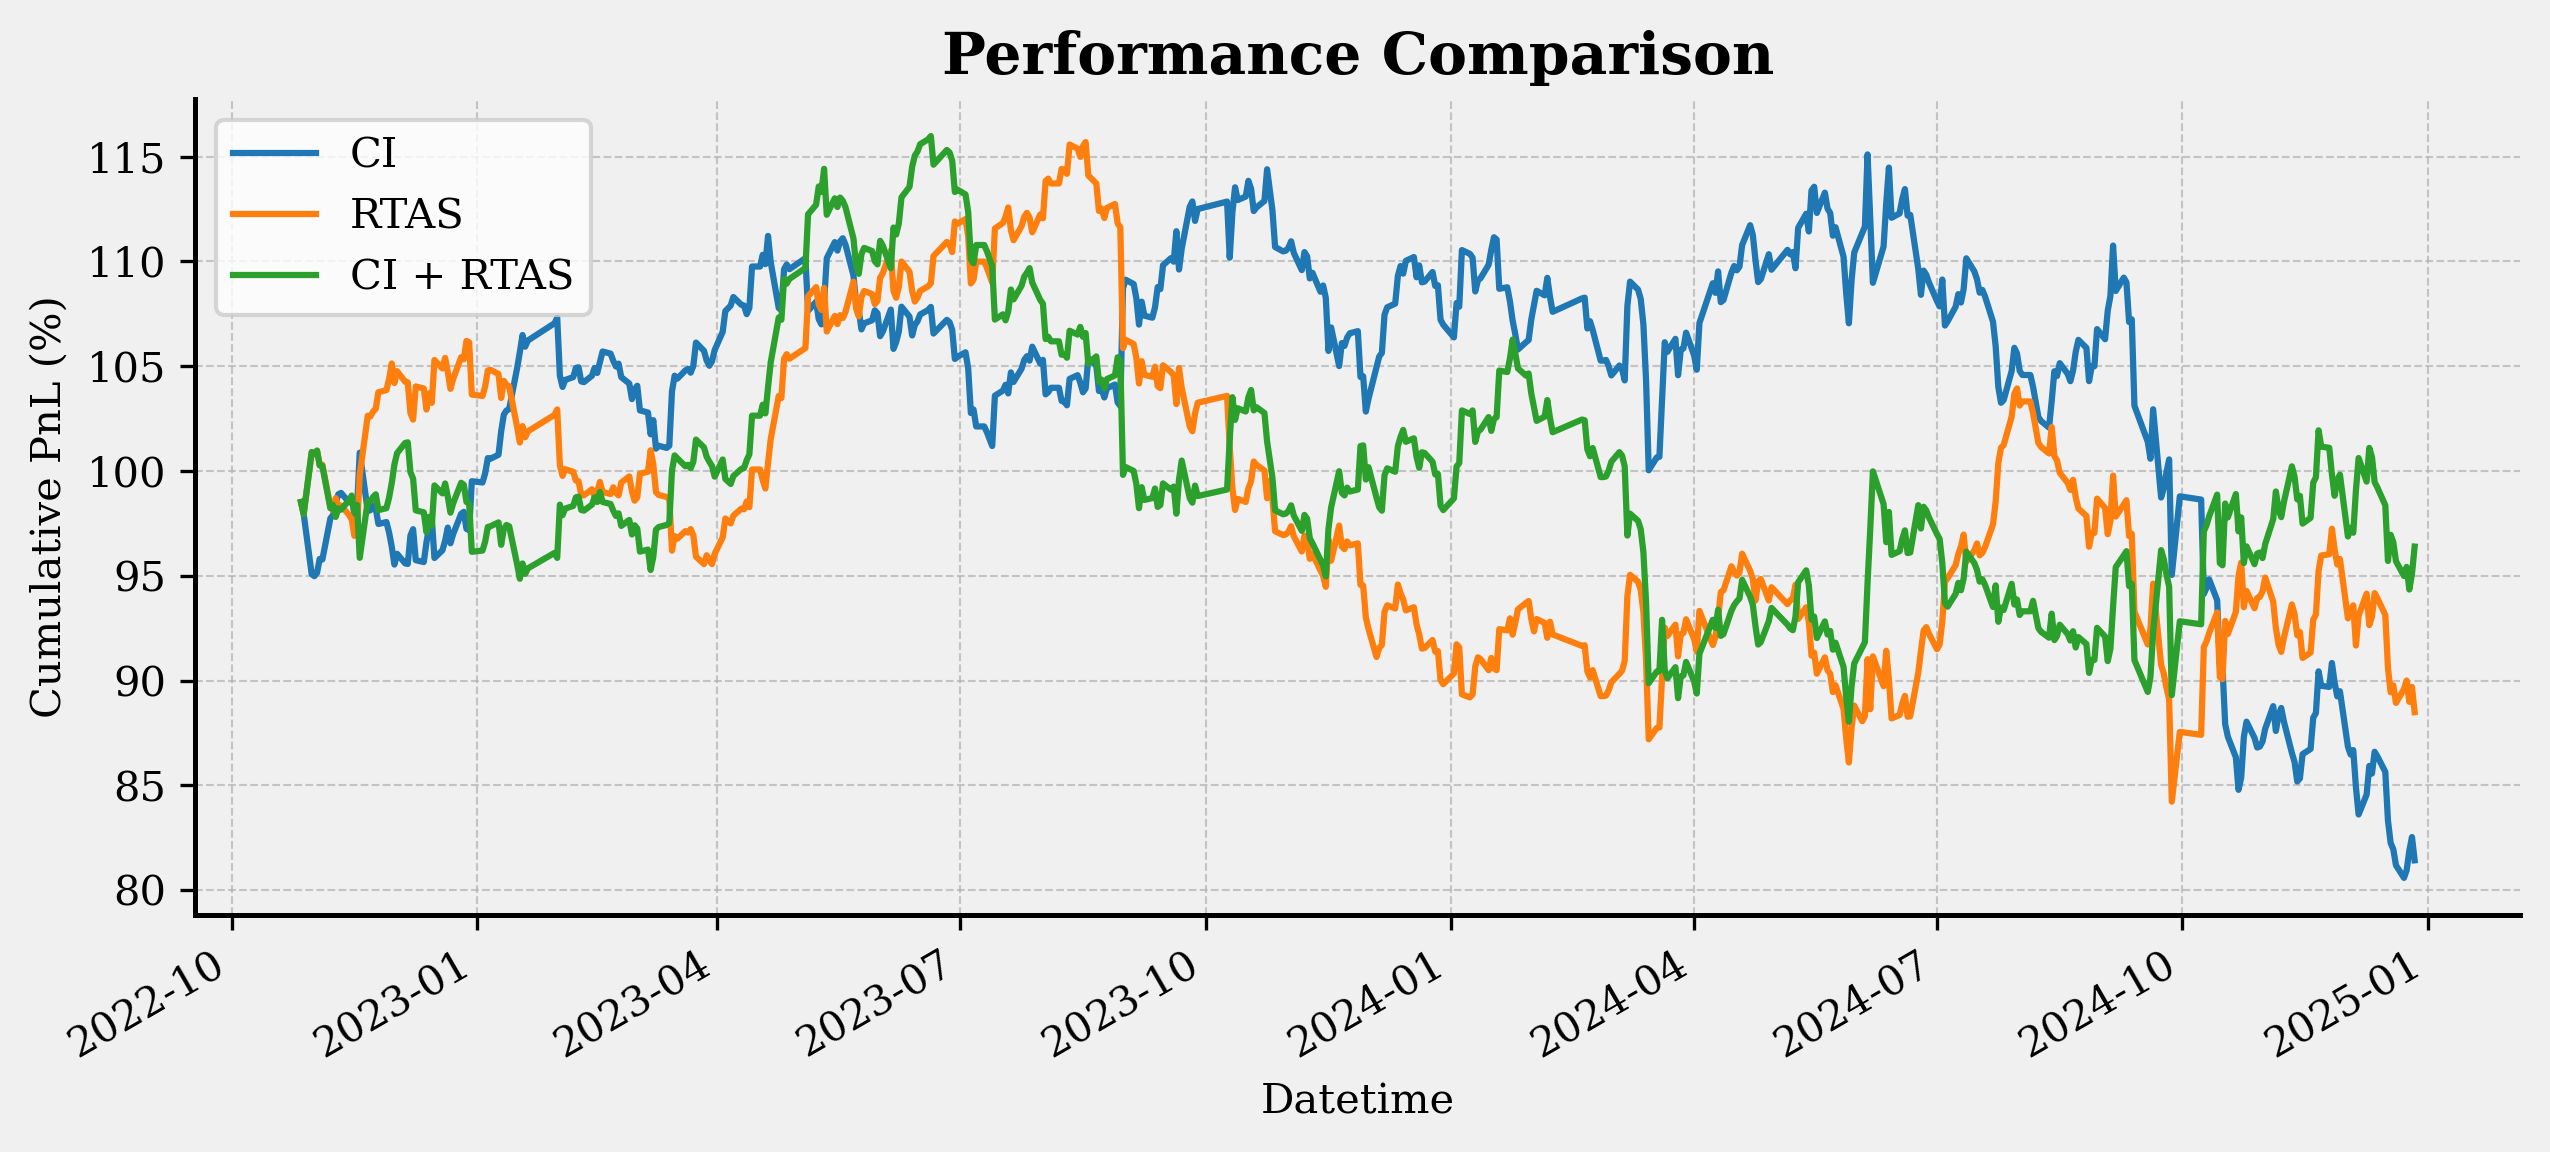

[{'Sharpe Ratio': -0.5452967511676368, 'Sortino Ratio': -0.7079159268542512, 'Max Drawdown': -0.29981421337856506, 'Frequency': 'daily'}, {'Sharpe Ratio': -0.32423150383878263, 'Sortino Ratio': -0.4331296724454694, 'Max Drawdown': -0.2719365546320349, 'Frequency': 'daily'}, {'Sharpe Ratio': -0.09737519214686267, 'Sortino Ratio': -0.13577937974983426, 'Max Drawdown': -0.240885034335801, 'Frequency': 'daily'}]
SC
An error occurred: With n_samples=0, test_size=0.5 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.
SN
An error occurred: With n_samples=0, test_size=0.5 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.
SR
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Validation Accuracy Scores: {'TI': 0.4962264150943396, 'Sig': 0.5094339622641509, 'TI_and_Sig': 0.5150943396226415}



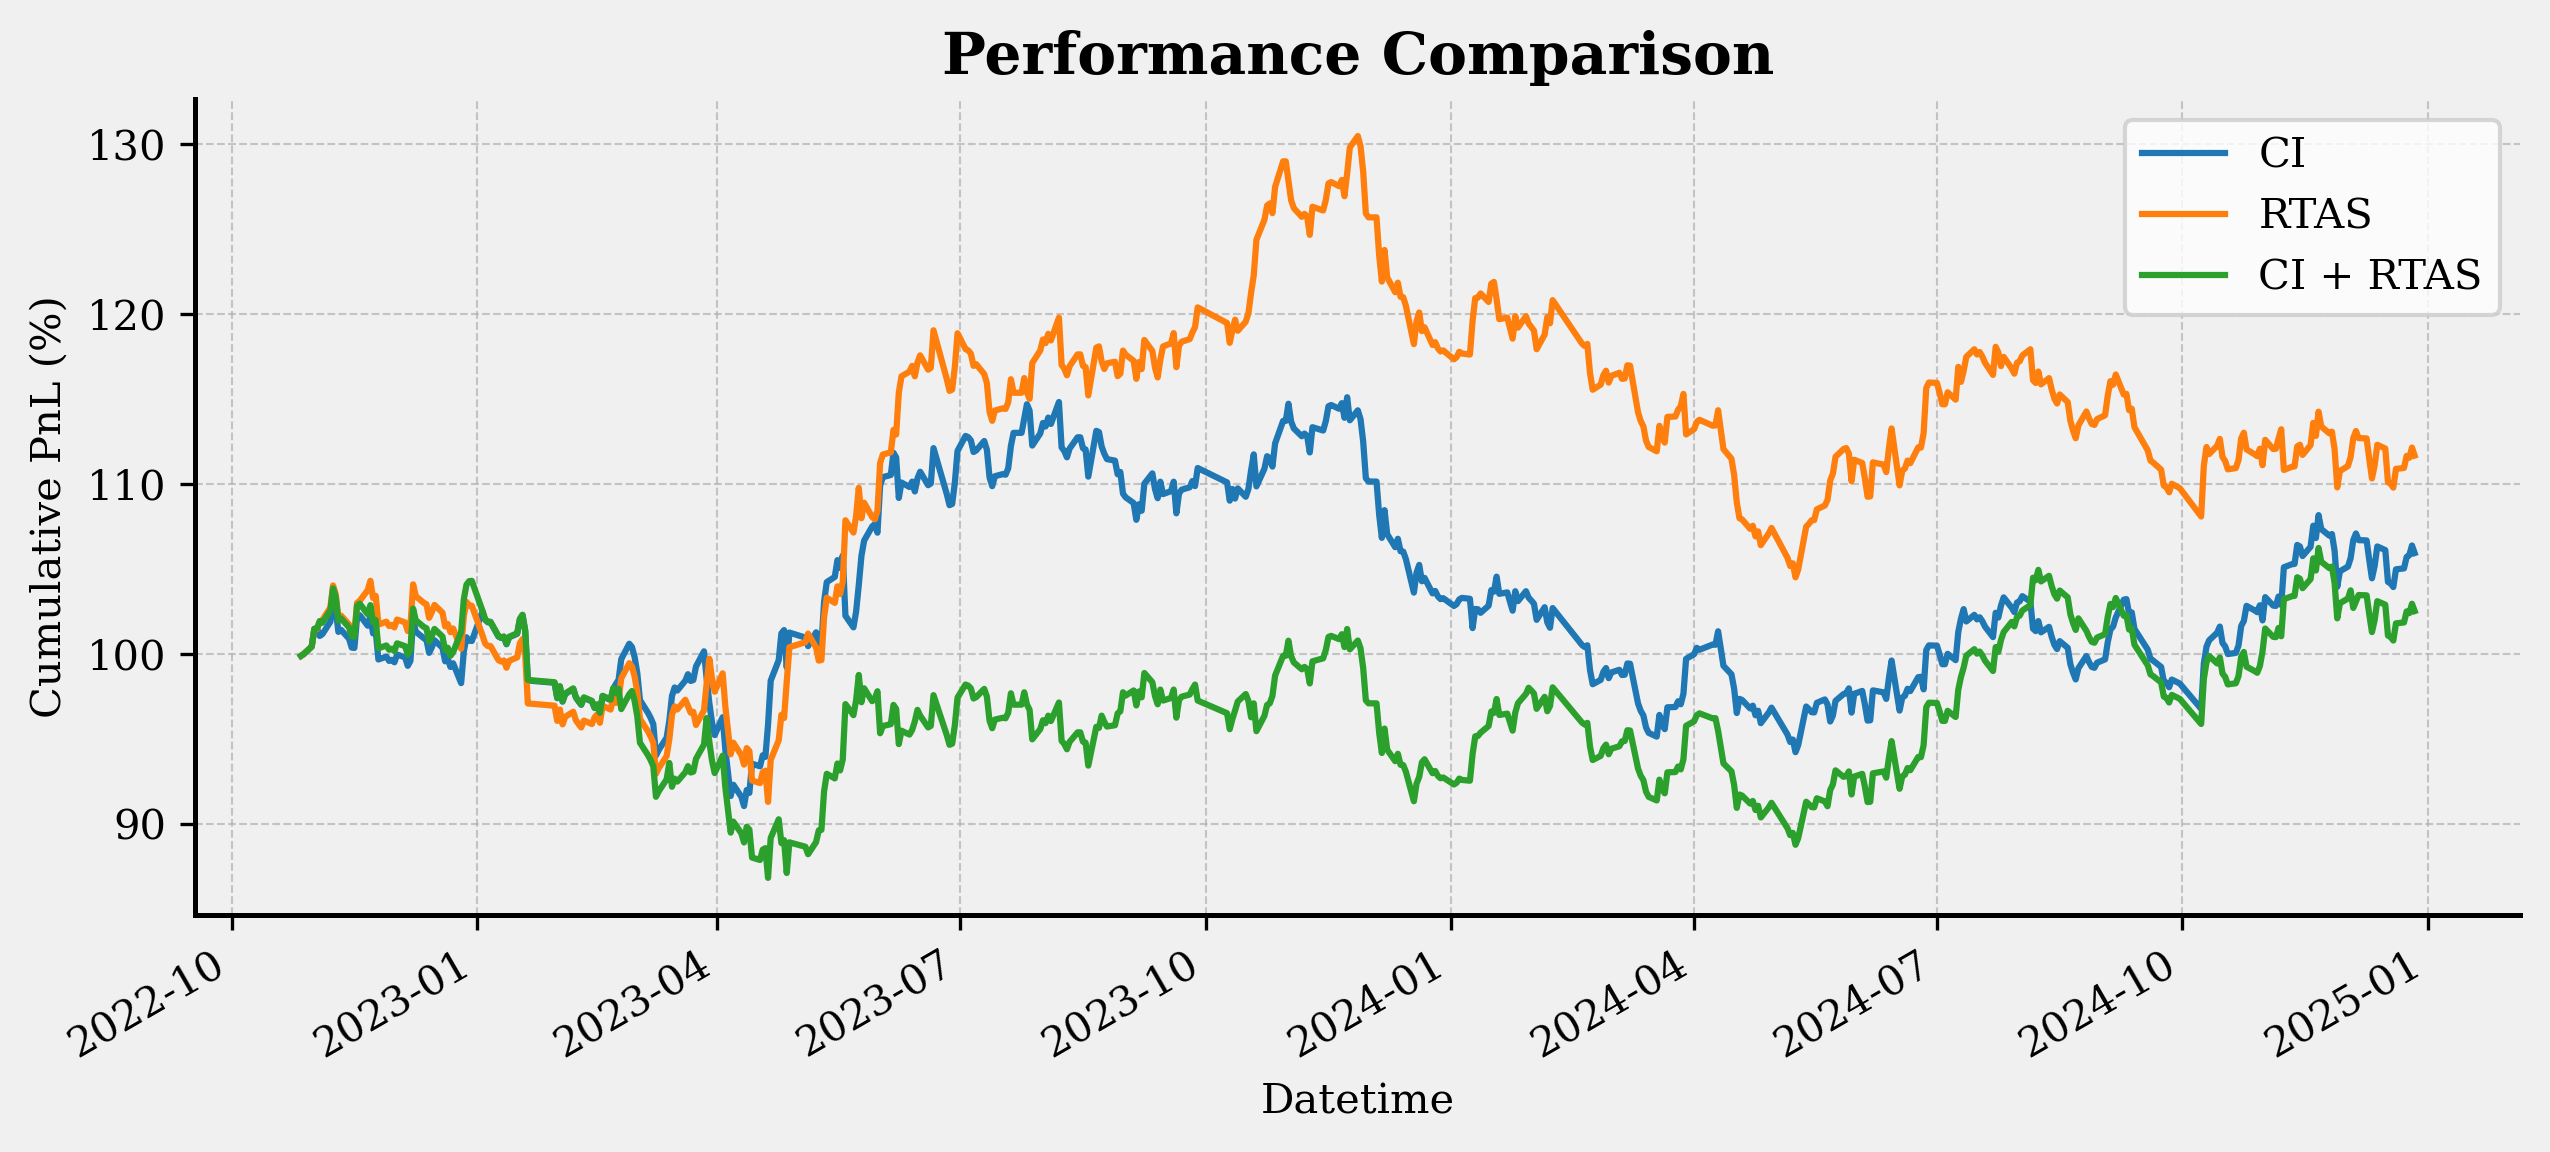

[{'Sharpe Ratio': 0.19521725432654535, 'Sortino Ratio': 0.2869874246295148, 'Max Drawdown': -0.18136856688869873, 'Frequency': 'daily'}, {'Sharpe Ratio': 0.37362574870864257, 'Sortino Ratio': 0.5751162960345697, 'Max Drawdown': -0.19894172887759254, 'Frequency': 'daily'}, {'Sharpe Ratio': 0.08444879603057392, 'Sortino Ratio': 0.12353809871773479, 'Max Drawdown': -0.16749390727226143, 'Frequency': 'daily'}]
Y
LSTM IS BEST!
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
LSTM IS BEST!
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation Accuracy Scores: {'TI': 0.45873320537428025, 'Sig': 0.5124760076775432, 'TI_and_Sig': 0.5075471698113208}



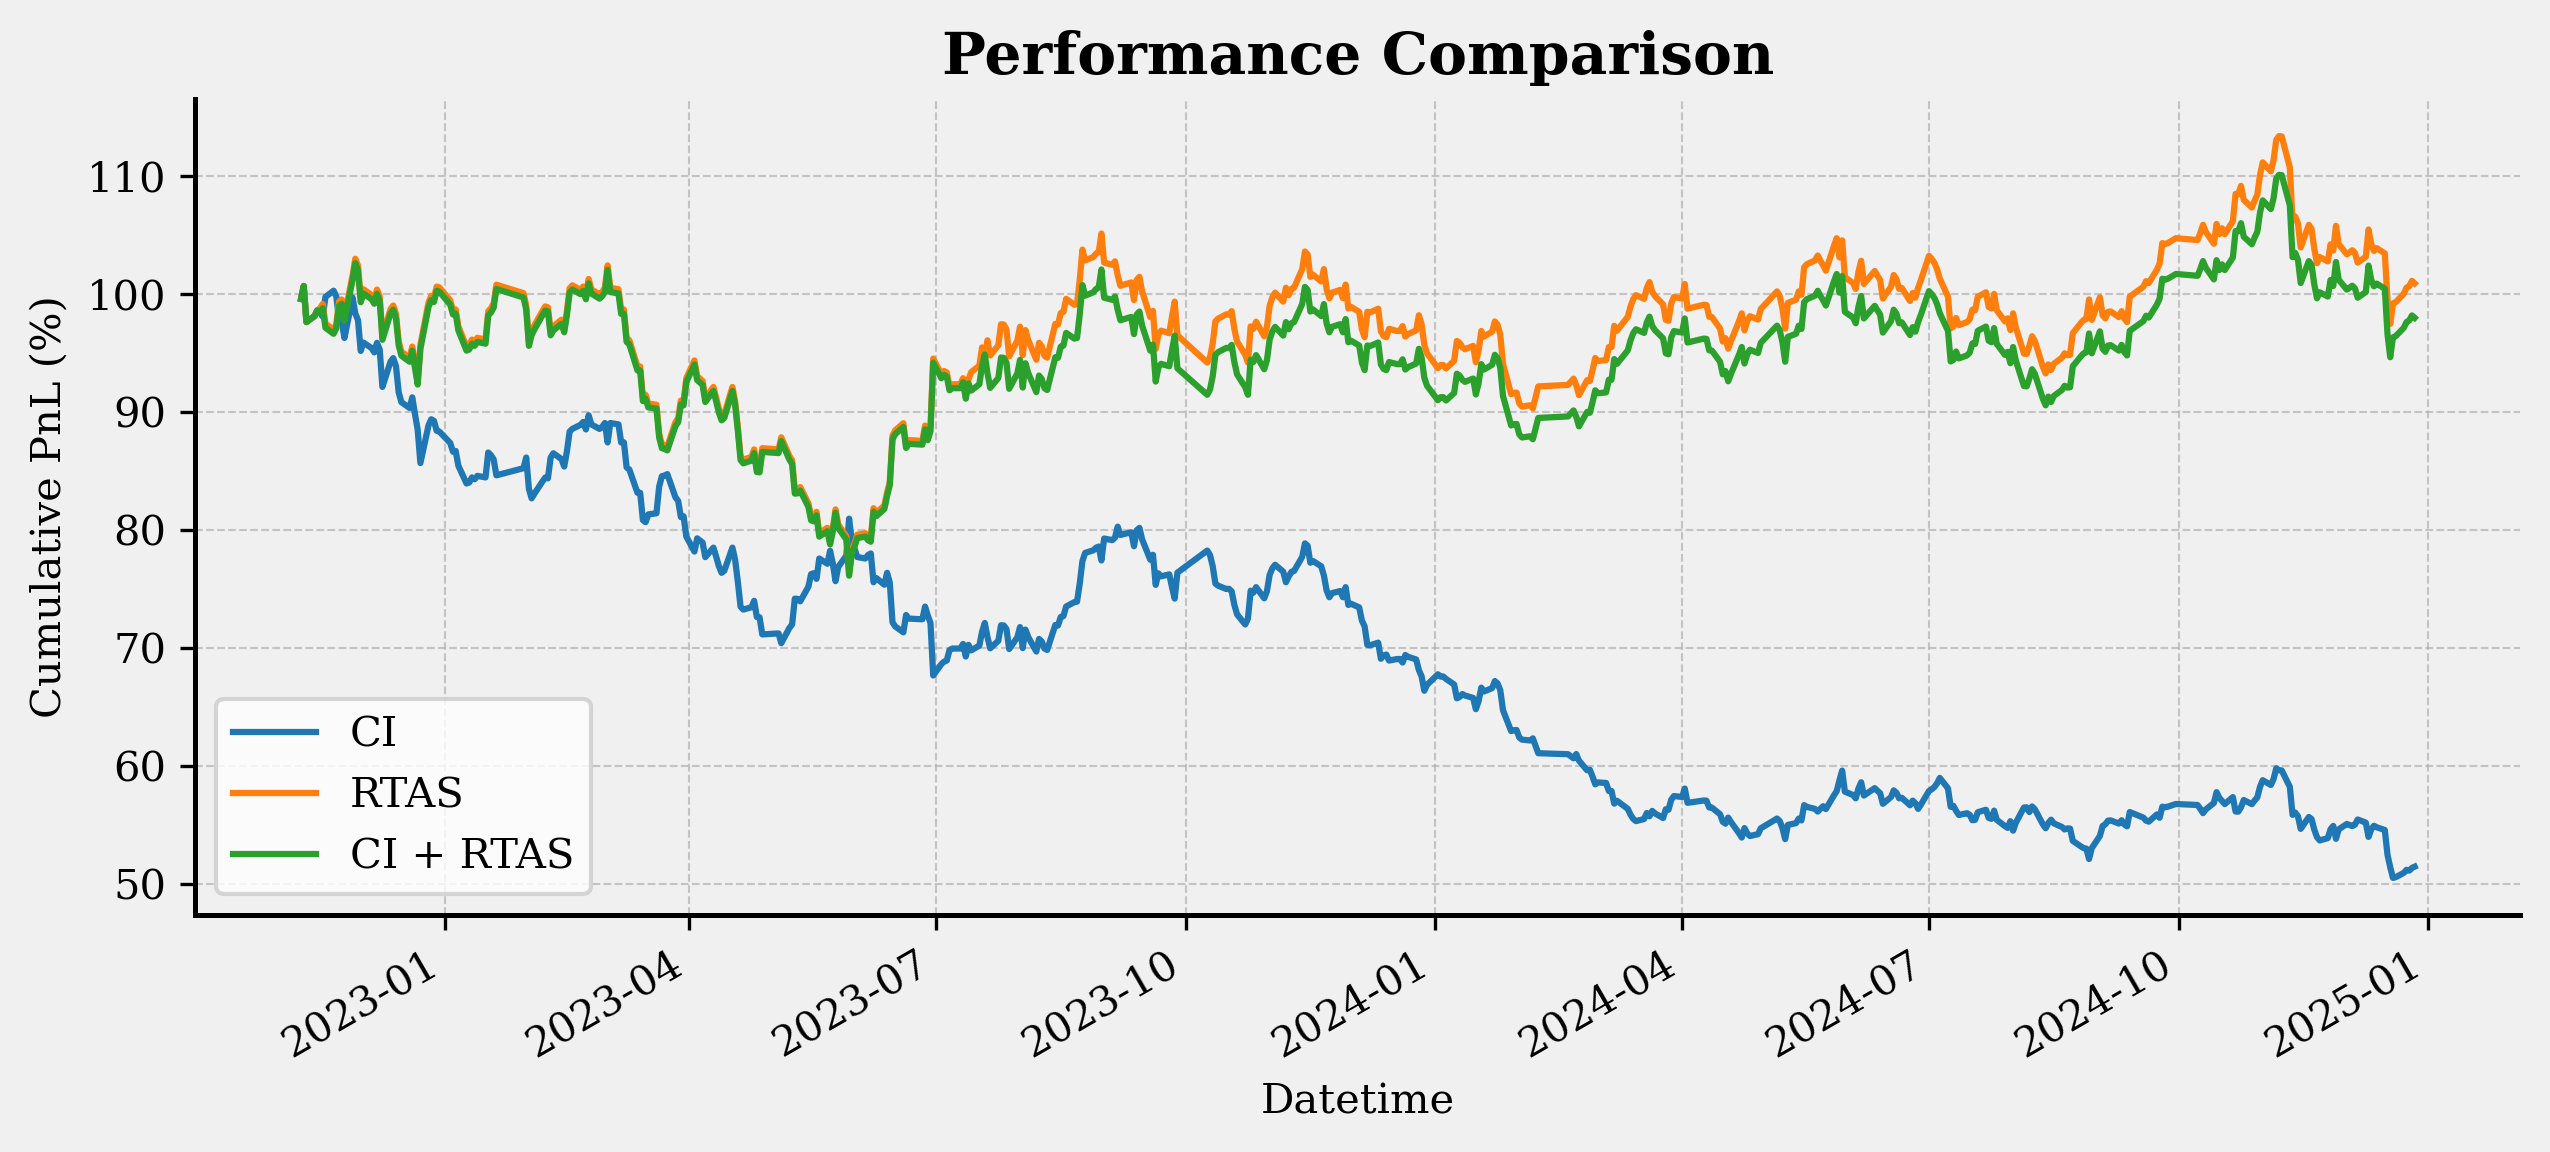

[{'Sharpe Ratio': -1.5761414449665063, 'Sortino Ratio': -2.2365413457685515, 'Max Drawdown': -0.49787089139791485, 'Frequency': 'daily'}, {'Sharpe Ratio': 0.020837566782634577, 'Sortino Ratio': 0.031044625117918393, 'Max Drawdown': -0.2579365079365079, 'Frequency': 'daily'}, {'Sharpe Ratio': -0.048598958572159554, 'Sortino Ratio': -0.07245195587113554, 'Max Drawdown': -0.2579365079365079, 'Frequency': 'daily'}]


In [35]:
for AssetClass in ['FX', 'Commods']:
    print(AssetClass)
    
    trading_metrics = []
    best_model_list = []


    df_total_raw, df_total_log = LoadDataset(AssetClass)
    
    # iterate through every asset_name
    for i in range(df_total_raw.shape[1]):
        try:
            # --------------------------------------------------------
            asset_name = df_total_raw.columns[i]
            print(asset_name)


            # --------------------------------------------------------
            # this creates all the features we might be interested in experimenting with
            df_features = CreateTotalFeatureSet(asset_name, df_total_raw, df_total_log, indicators, sig_windows, max_trunc_level)
            # -------------------------------------------------------
            ResultsDict, df_classification, best_models = TrainModels(df_features, indicators_col_names, sig_col_names, forecast_tau, forecast_threshold=0)
            print()
            
            best_model_list.append(best_models)
            
            # compute PnL on Validation Set
            df_val_pnl = df_classification.dropna().copy()
            for feature_set in ['TI', 'Sig', 'TI_and_Sig']:

                df_val_pnl[feature_set + '_PnL'] = np.power(-1, 1 + df_val_pnl.loc[:, feature_set+'_preds'])*df_val_pnl.forecast_return
                df_val_pnl[feature_set + '_Cum_PnL'] = np.exp(df_val_pnl[feature_set + '_PnL'].cumsum())
            # Visualise
            PlotValidationPnL(df_val_pnl)
            
            trading_metrics.append([compute_performance_metrics(df_val_pnl, pnl_col=col) for col in ['TI_PnL', 'Sig_PnL', 'TI_and_Sig_PnL']])
            print(trading_metrics[-1])
            
        except Exception as e:
            #Handle the error
            print(f"An error occurred: {e}")
            
    with open(f'TradingMetricsList_{AssetClass}.pkl', 'wb') as f:
        pickle.dump(trading_metrics, f)
        
    with open(f'BestModelsList_{AssetClass}.pkl', 'wb') as f:
        pickle.dump(best_model_list, f)
            


# Analyse Trading Metrics

In [29]:
def compute_performance_metrics(df, pnl_col='PnL'):
    # Ensure datetime index is sorted
    df = df.sort_index()

    # Determine frequency in days
    dt = (df.index[1] - df.index[0]).total_seconds()
    periods_per_year = {
        'daily': 252,
        'hourly': 252 * 6.5,  # Assuming 6.5 trading hours per day
        'minute': 252 * 6.5 * 60
    }

    if dt >= 86400:
        freq = 'daily'
    elif dt >= 3600:
        freq = 'hourly'
    else:
        freq = 'minute'

    ann_factor = periods_per_year[freq]

    returns = df[pnl_col]

    # Sharpe Ratio
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(ann_factor)

    # Sortino Ratio
    downside_returns = returns[returns < 0]
    sortino_denom = downside_returns.std()
    sortino_ratio = (returns.mean() / sortino_denom) * np.sqrt(ann_factor) if sortino_denom != 0 else np.nan

    # Max Drawdown (based on cumulative return)
    cum_returns = np.exp(returns.cumsum())
    running_max = cum_returns.cummax()
    drawdown = cum_returns / running_max - 1
    max_drawdown = drawdown.min()

    return {
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Frequency': freq
    }


In [30]:
def CleanMetricsAndSummarise(data):

    # Create DataFrame with 3 columns (one per model)
    df = pd.DataFrame(data, columns=['TI', 'Sig', 'TI_and_Sig'])

    # Drop 'Frequency' from each dictionary before expanding
    for col in df.columns:
        df[col] = df[col].apply(lambda d: {k: v for k, v in d.items() if k != 'Frequency'})

    # Expand into a flat DataFrame
    df_expanded = pd.concat([df[col].apply(pd.Series) for col in df.columns], axis=1, keys=df.columns)

    # Flatten column multi-index
    df_expanded.columns = ['_'.join(col).strip() for col in df_expanded.columns.values]
    
    return df_expanded

In [31]:
def PlotBox(df_expanded):

    # Set global high-DPI and style
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.linewidth'] = 1.2

    for metric in ['Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown']:
        plt.figure(figsize=(8, 3))

        # Extract relevant columns
        data = df_expanded.filter(like=metric)

        # Custom boxplot with clean black-and-white style
        boxprops = dict(linewidth=1.5, color='black')
        whiskerprops = dict(linewidth=1.2, color='black')
        capprops = dict(linewidth=1.2, color='black')
        medianprops = dict(linewidth=2.0, color='black')
        flierprops = dict(marker='o', markerfacecolor='black', markersize=3, linestyle='none')

        data.boxplot(
            boxprops=boxprops,
            whiskerprops=whiskerprops,
            capprops=capprops,
            medianprops=medianprops,
            flierprops=flierprops
        )

        plt.title(f"{metric} Across Feature-Sets: {AssetClass}", fontsize=12)
        plt.ylabel(metric, fontsize=10)
        plt.xticks([1, 2, 3], ['CI', 'RTAS', 'CI + RTAS'], fontsize=9)
        plt.yticks(fontsize=9)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [32]:
import seaborn as sns
def PlotHist(df_expanded):
    # Set up high-res figure
    plt.figure(figsize=(8, 4), dpi=300)
    plt.rcParams['font.family'] = 'serif'

    # Extract and rename the columns (Sharpe Ratios in this example)
    sharpe_data = df_expanded.filter(like='Sharpe Ratio')
    sharpe_data.columns = ['CI', 'RTAS', 'CI + RTAS']

    # Plot each distribution as a line-only histogram (step style)
    for label, color in zip(sharpe_data.columns, ['tab:blue', 'tab:orange', 'tab:green']):
        plt.hist(
            sharpe_data[label],
            bins=20,
            density=True,
            histtype='step',
            linewidth=1.8,
            label=label,
            color=color
        )

    # Add vertical reference line at 0
    plt.axvline(0, color='black', linestyle='--', linewidth=1)

    # Labels and title
    plt.title("Sharpe Ratio Distributions", fontsize=12, weight='bold')
    plt.xlabel("Sharpe Ratio")
    plt.ylabel("Density")
    plt.legend(frameon=False, fontsize=10)
    plt.tight_layout()
    plt.show()

----------------------------------------------------------------------------------------------------
Equities
mean
TI_Sharpe Ratio             0.179890
TI_Sortino Ratio            0.331563
TI_Max Drawdown            -0.180846
Sig_Sharpe Ratio            0.521214
Sig_Sortino Ratio           0.770740
Sig_Max Drawdown           -0.165734
TI_and_Sig_Sharpe Ratio     0.747513
TI_and_Sig_Sortino Ratio    1.032072
TI_and_Sig_Max Drawdown    -0.168458
dtype: float64
median
TI_Sharpe Ratio            -0.070676
TI_Sortino Ratio           -0.093539
TI_Max Drawdown            -0.189632
Sig_Sharpe Ratio            0.397272
Sig_Sortino Ratio           0.484549
Sig_Max Drawdown           -0.142990
TI_and_Sig_Sharpe Ratio     0.831250
TI_and_Sig_Sortino Ratio    1.143152
TI_and_Sig_Max Drawdown    -0.130784
dtype: float64
Number of Positive Sharpe Ratios per Model:
TI_Sharpe Ratio            45.0
Sig_Sharpe Ratio           70.0
TI_and_Sig_Sharpe Ratio    70.0
dtype: float64


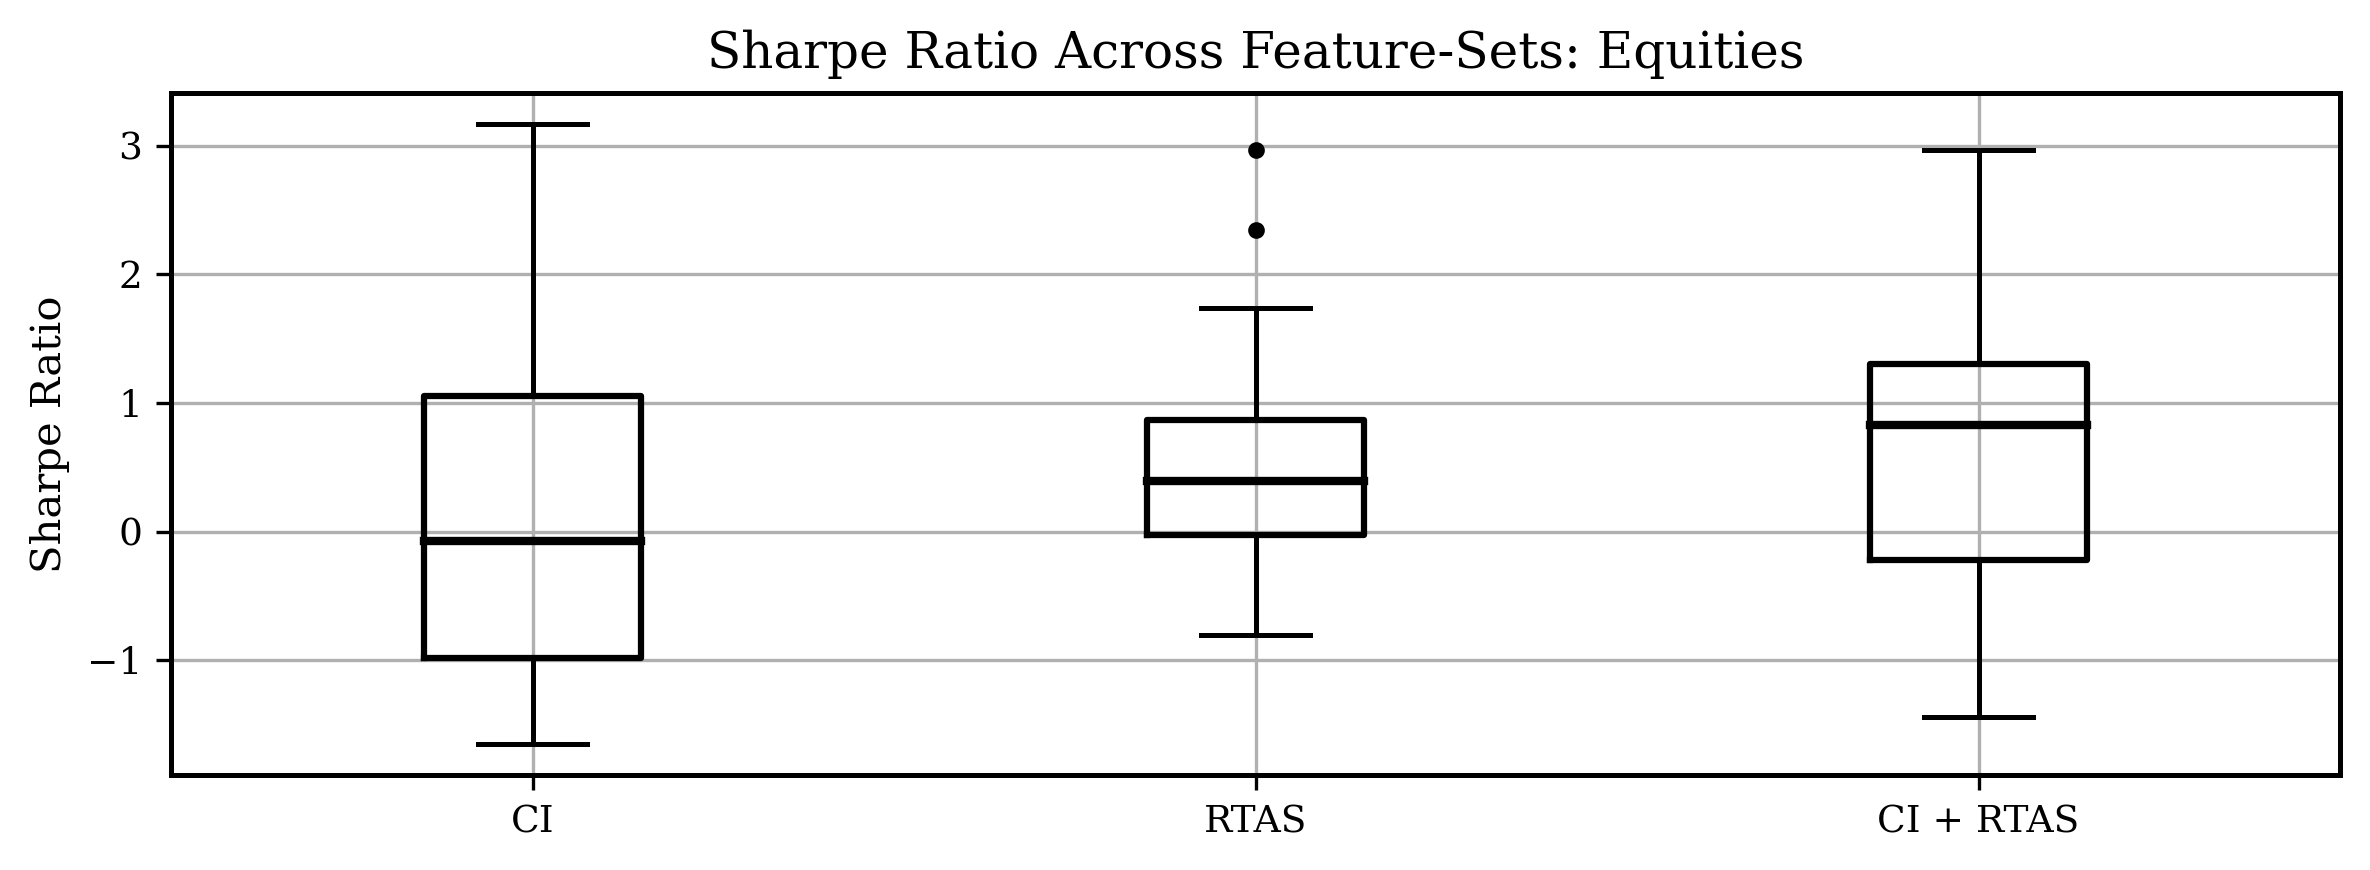

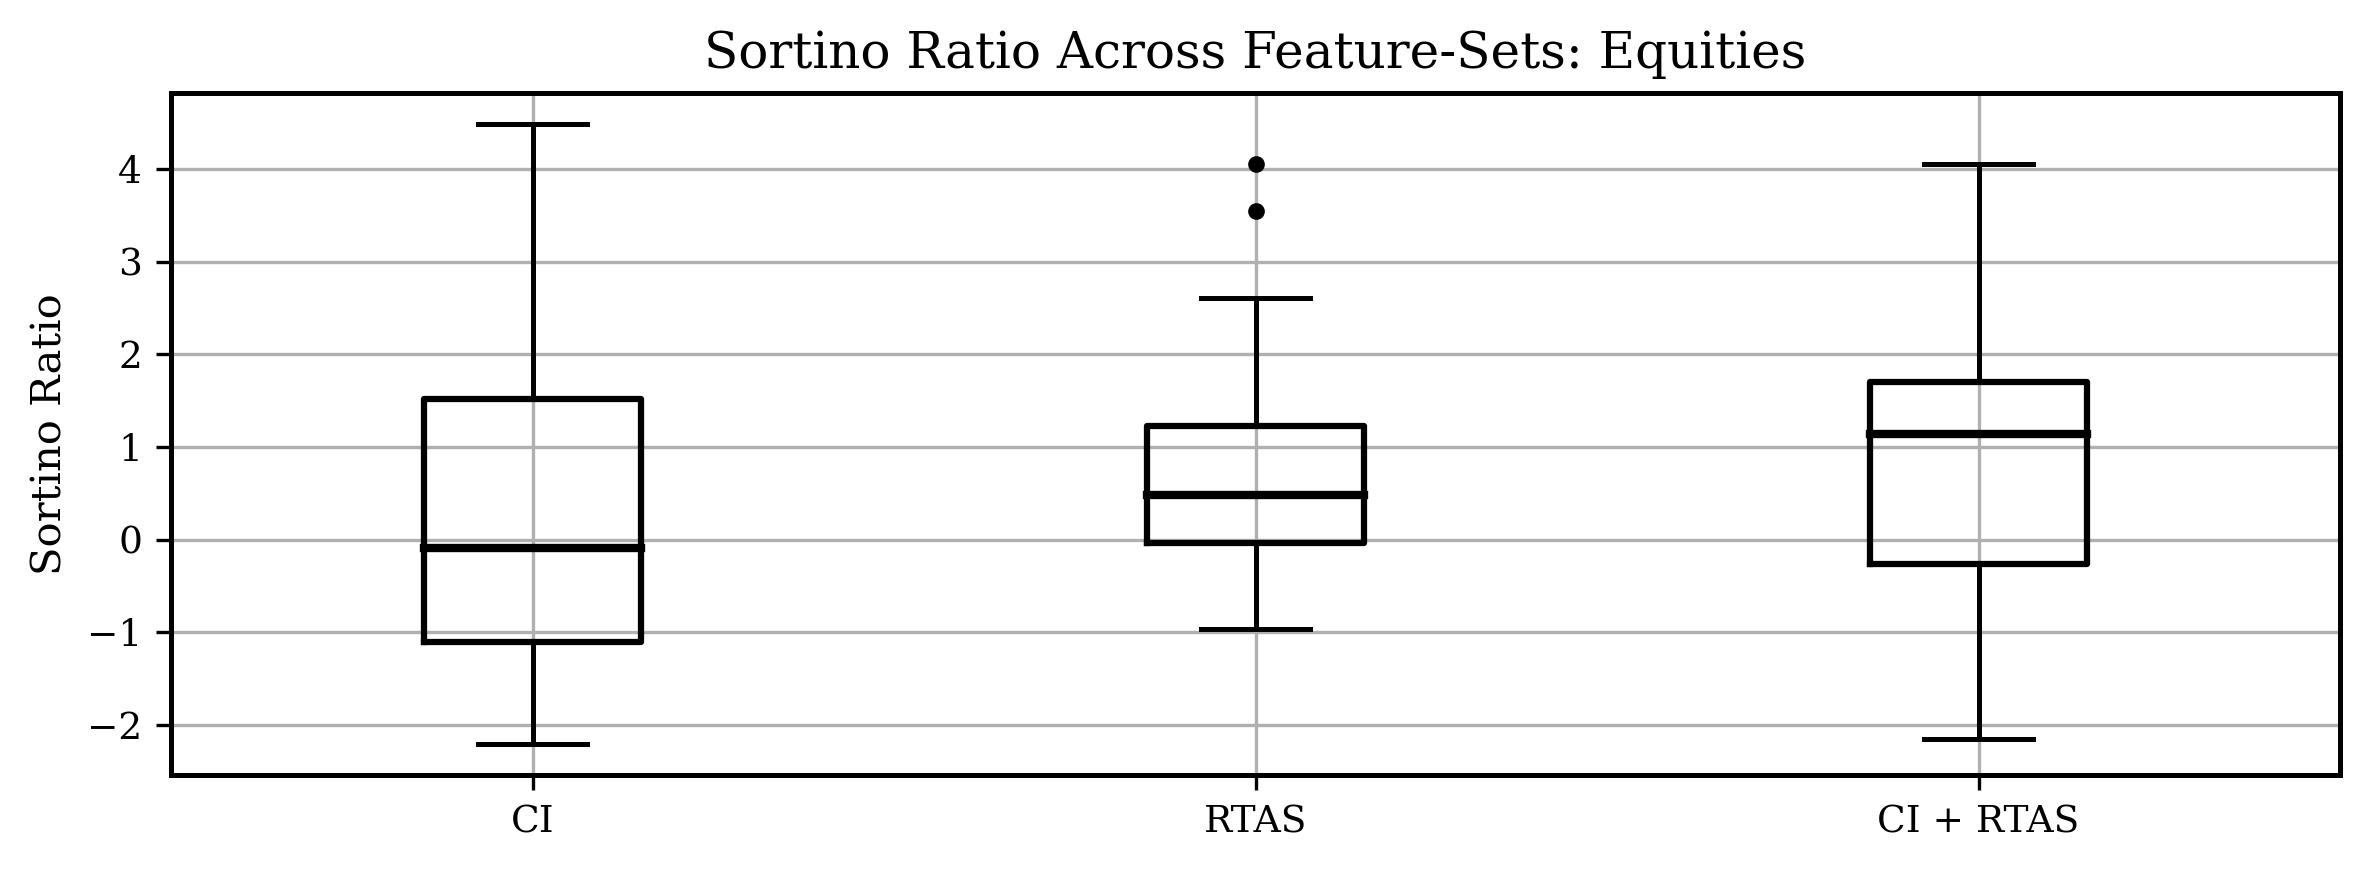

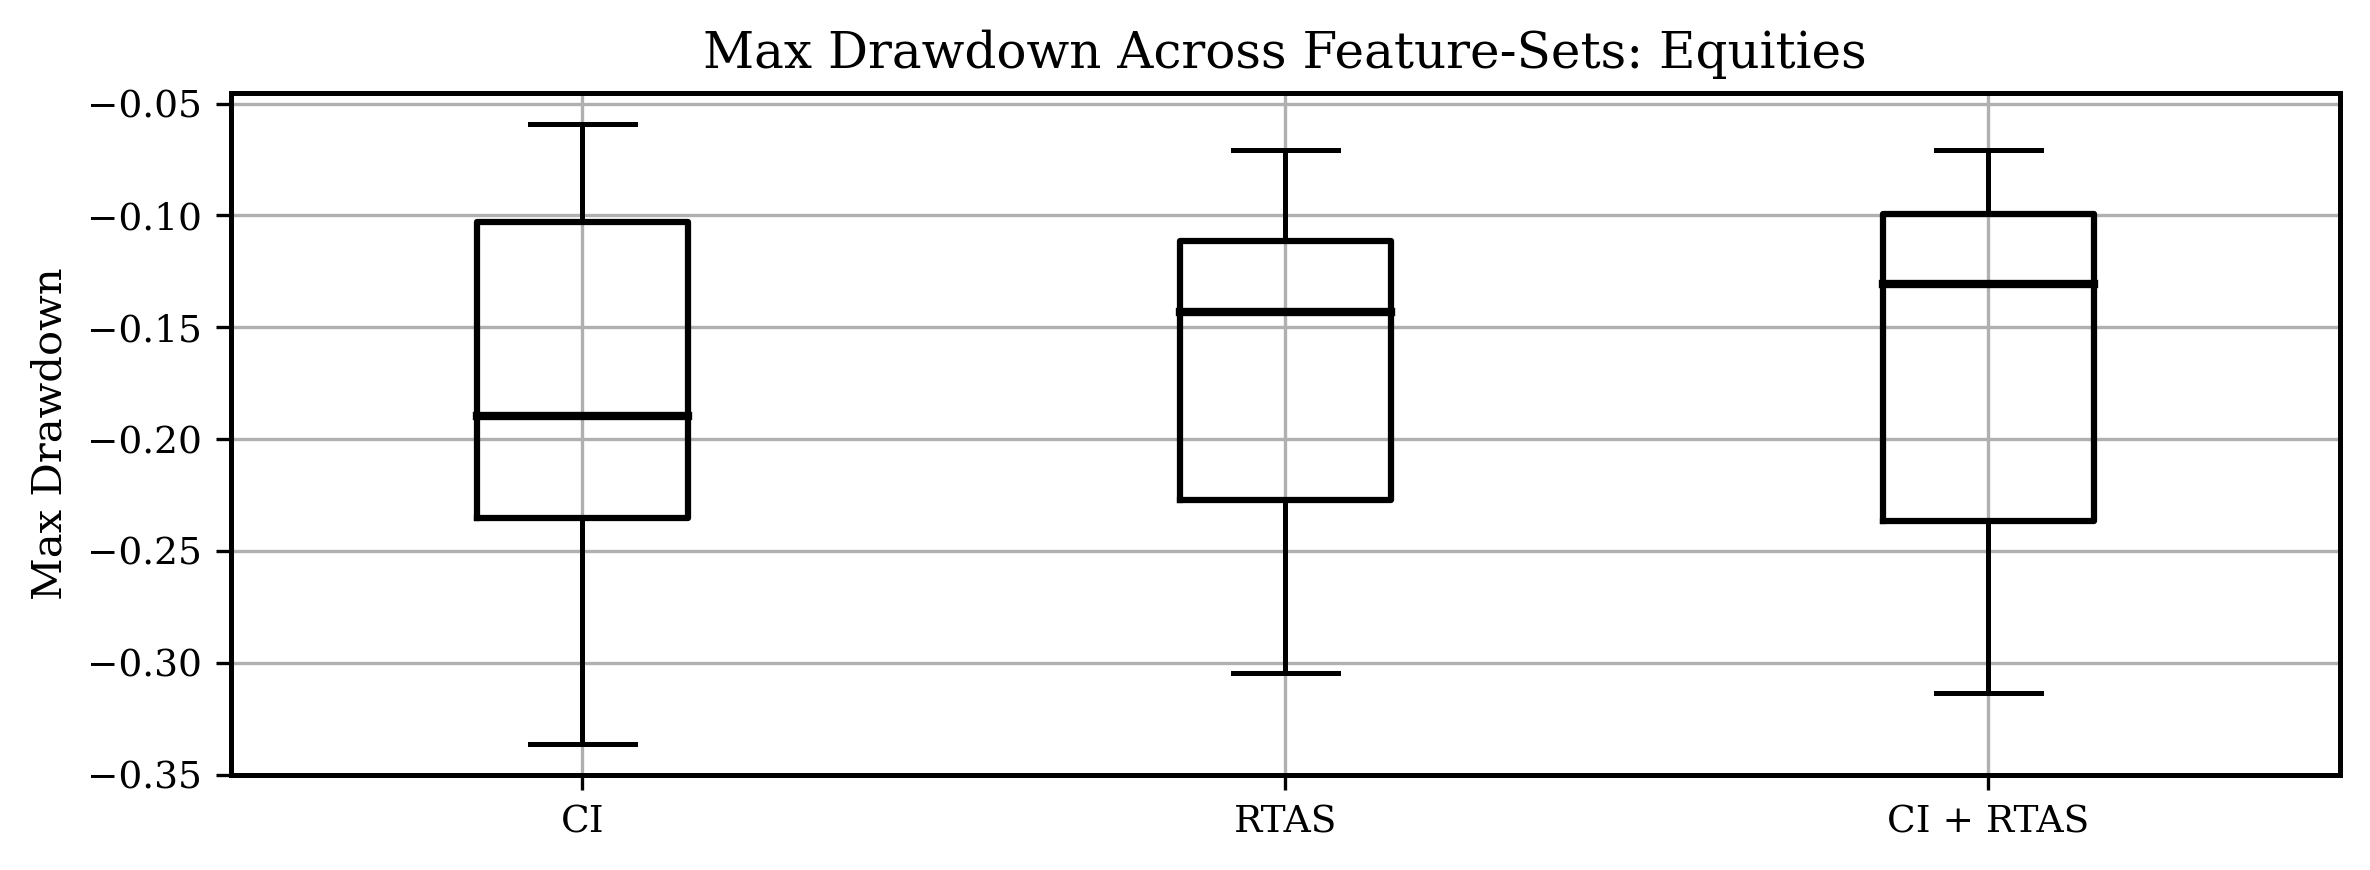

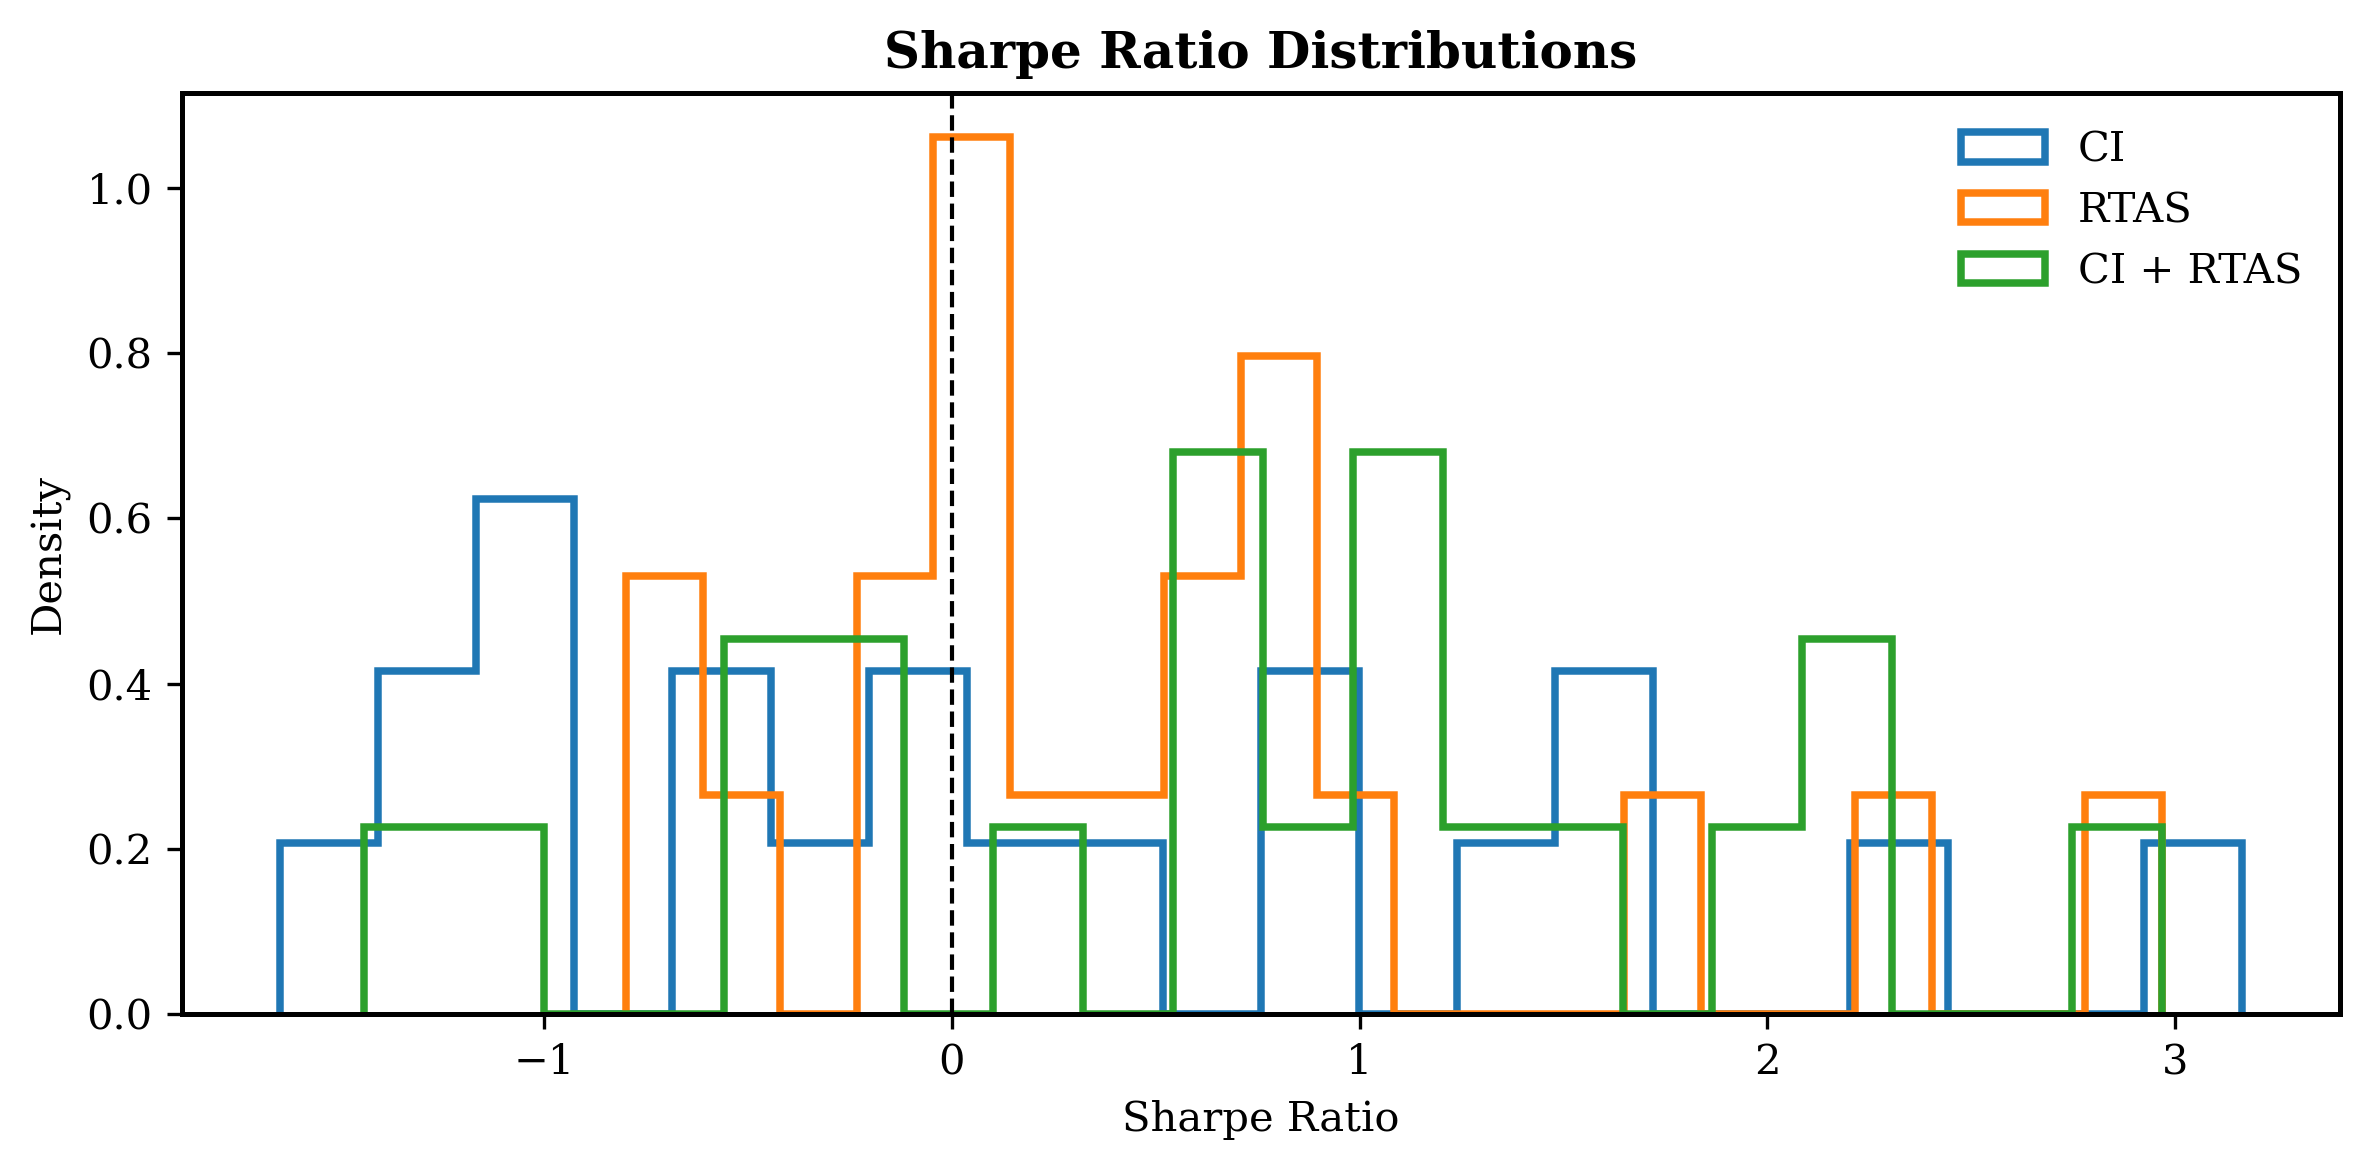

----------------------------------------------------------------------------------------------------
FX
mean
TI_Sharpe Ratio             30.068916
TI_Sortino Ratio            42.780549
TI_Max Drawdown             -0.003129
Sig_Sharpe Ratio            20.424943
Sig_Sortino Ratio           28.292042
Sig_Max Drawdown            -0.003982
TI_and_Sig_Sharpe Ratio     19.219465
TI_and_Sig_Sortino Ratio    26.519831
TI_and_Sig_Max Drawdown     -0.003962
dtype: float64
median
TI_Sharpe Ratio             32.507512
TI_Sortino Ratio            44.983632
TI_Max Drawdown             -0.003006
Sig_Sharpe Ratio            21.531636
Sig_Sortino Ratio           28.368007
Sig_Max Drawdown            -0.003776
TI_and_Sig_Sharpe Ratio     20.654254
TI_and_Sig_Sortino Ratio    29.454803
TI_and_Sig_Max Drawdown     -0.004831
dtype: float64
Number of Positive Sharpe Ratios per Model:
TI_Sharpe Ratio            100.0
Sig_Sharpe Ratio           100.0
TI_and_Sig_Sharpe Ratio    100.0
dtype: float64


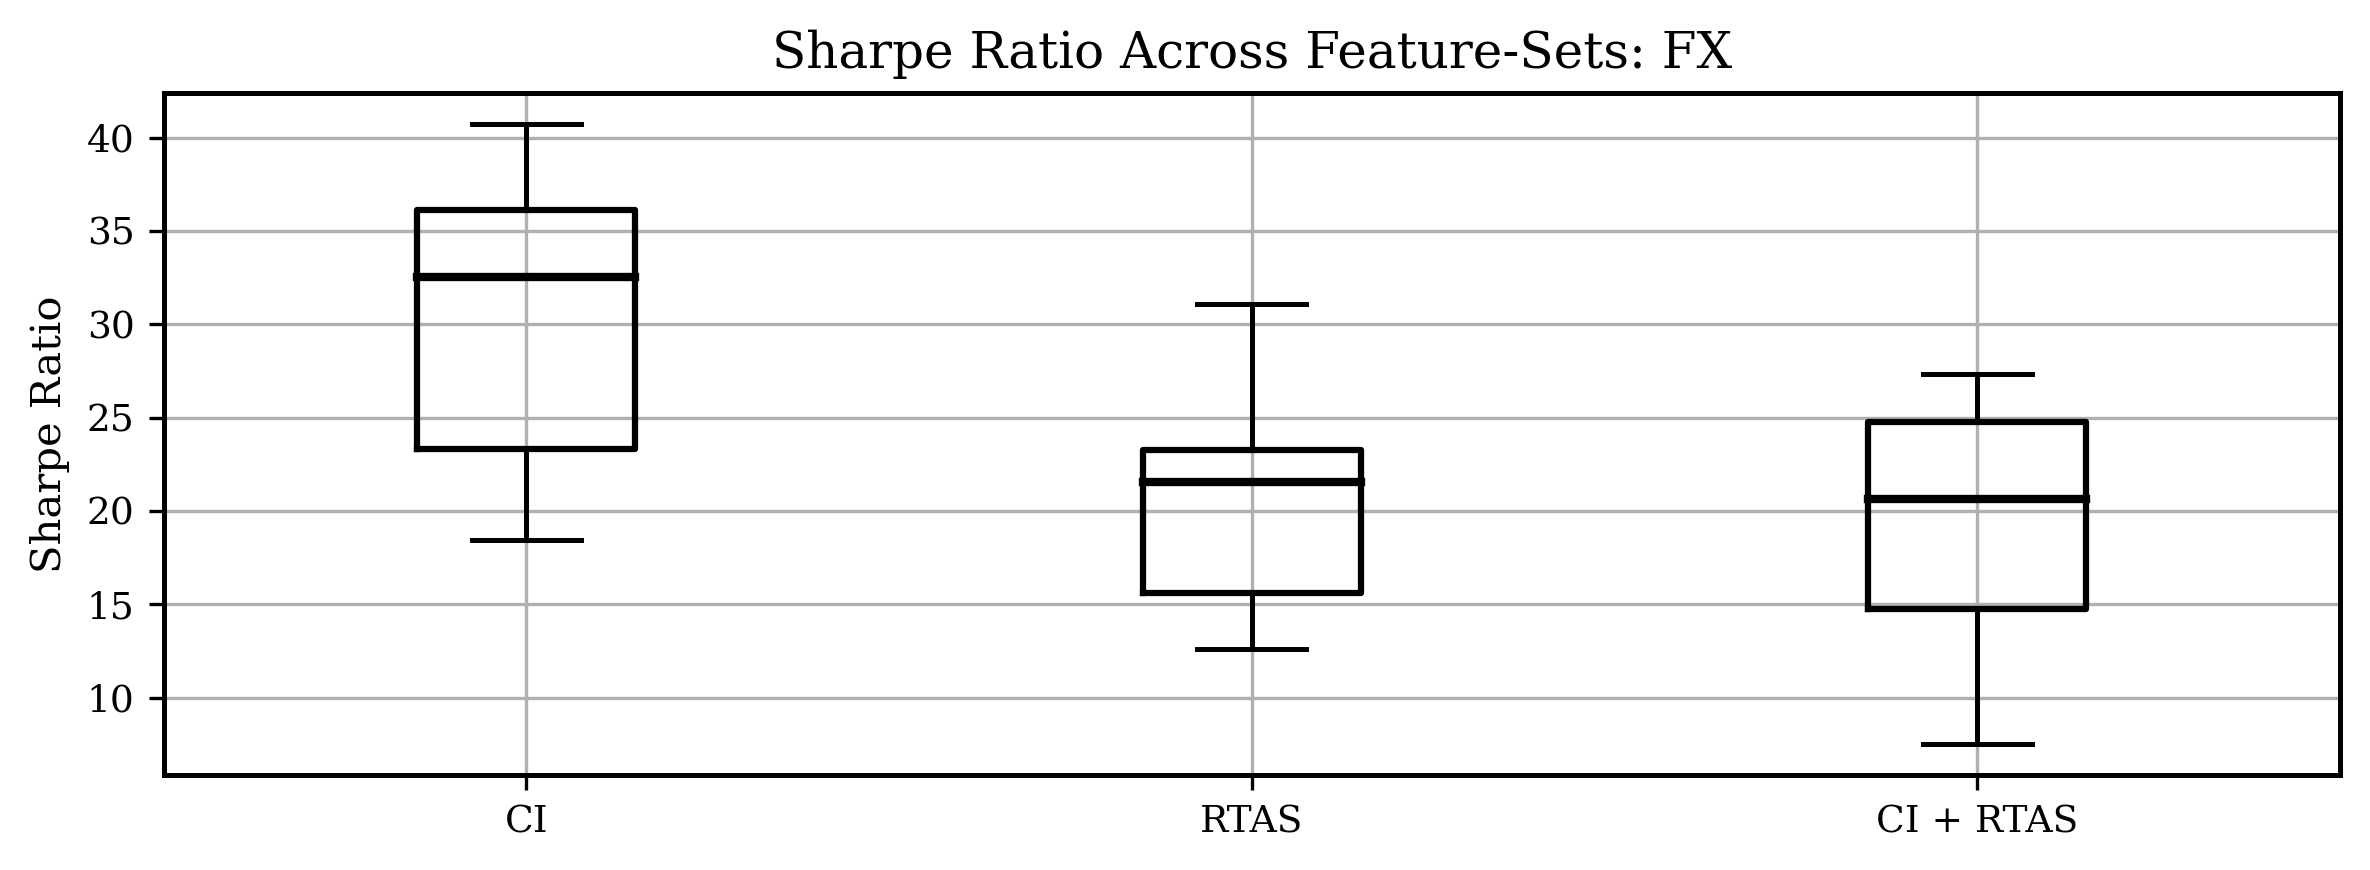

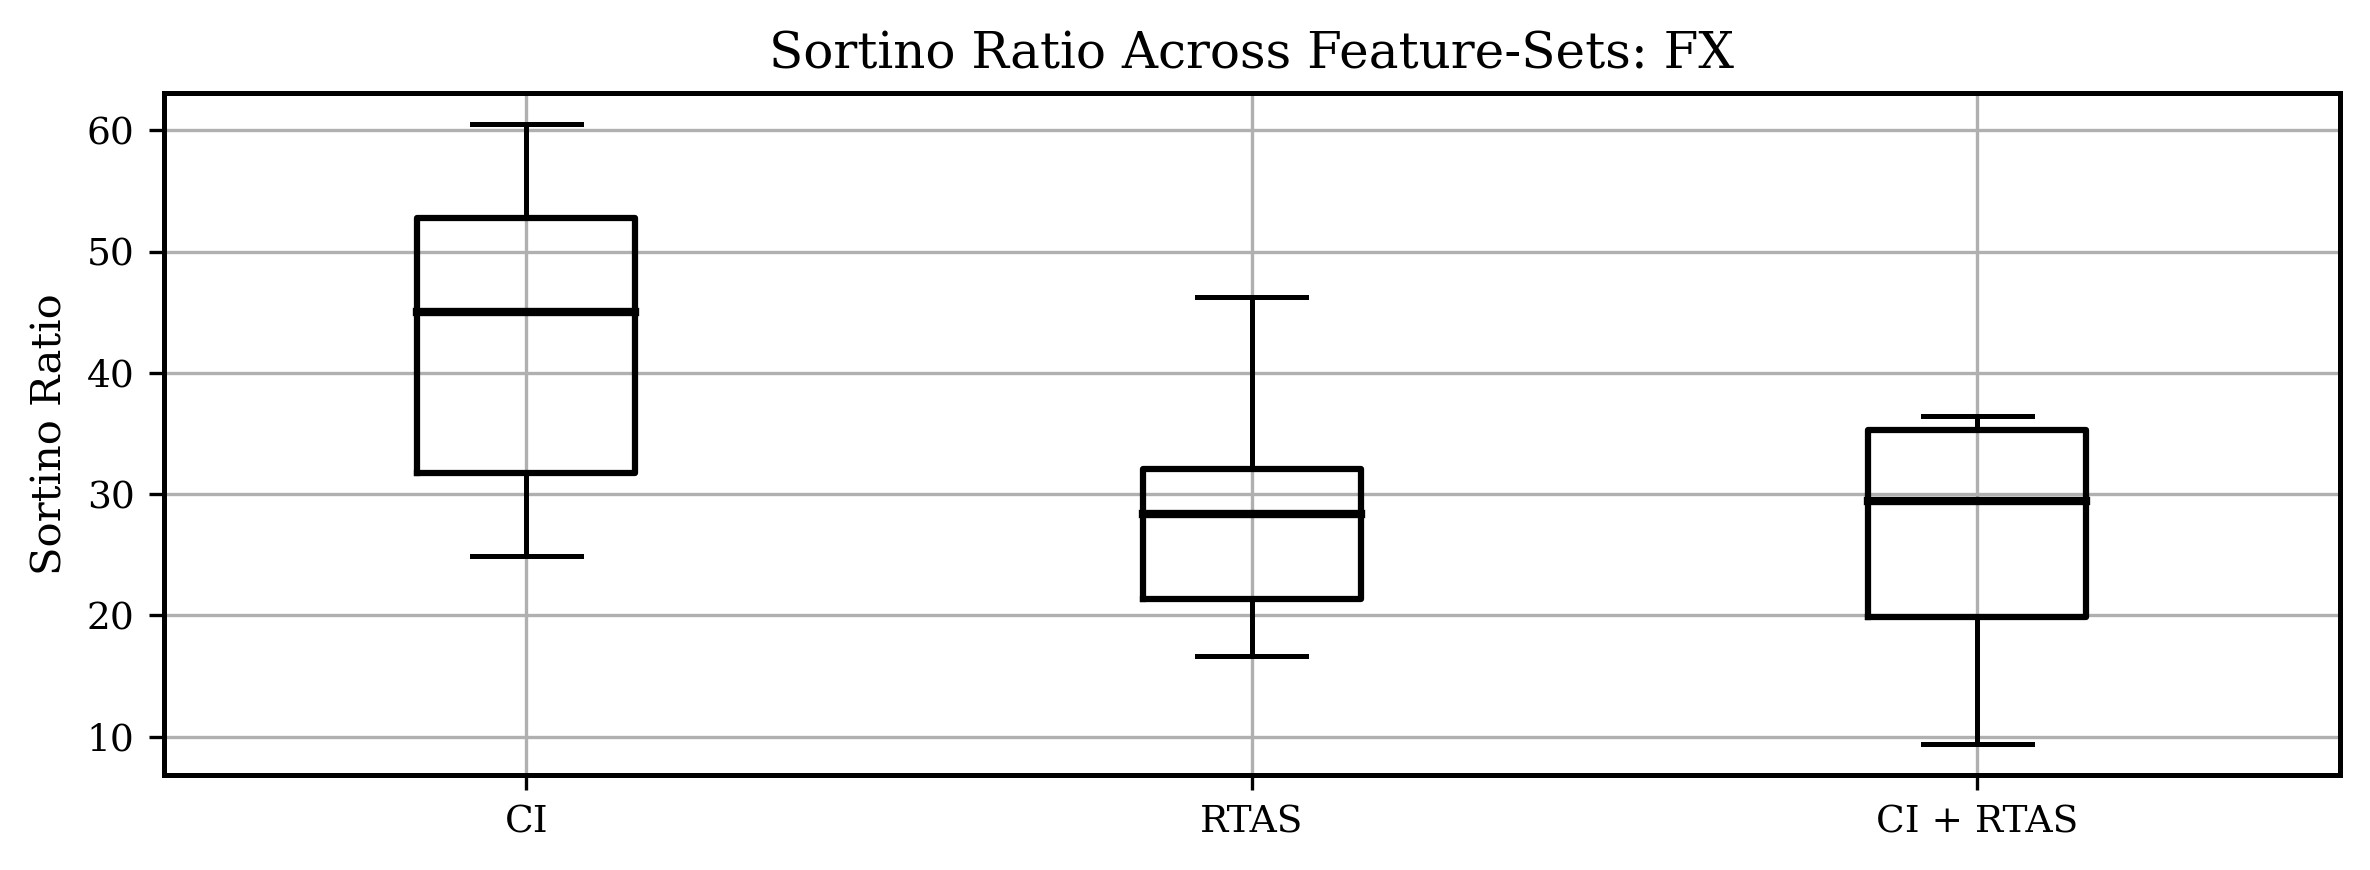

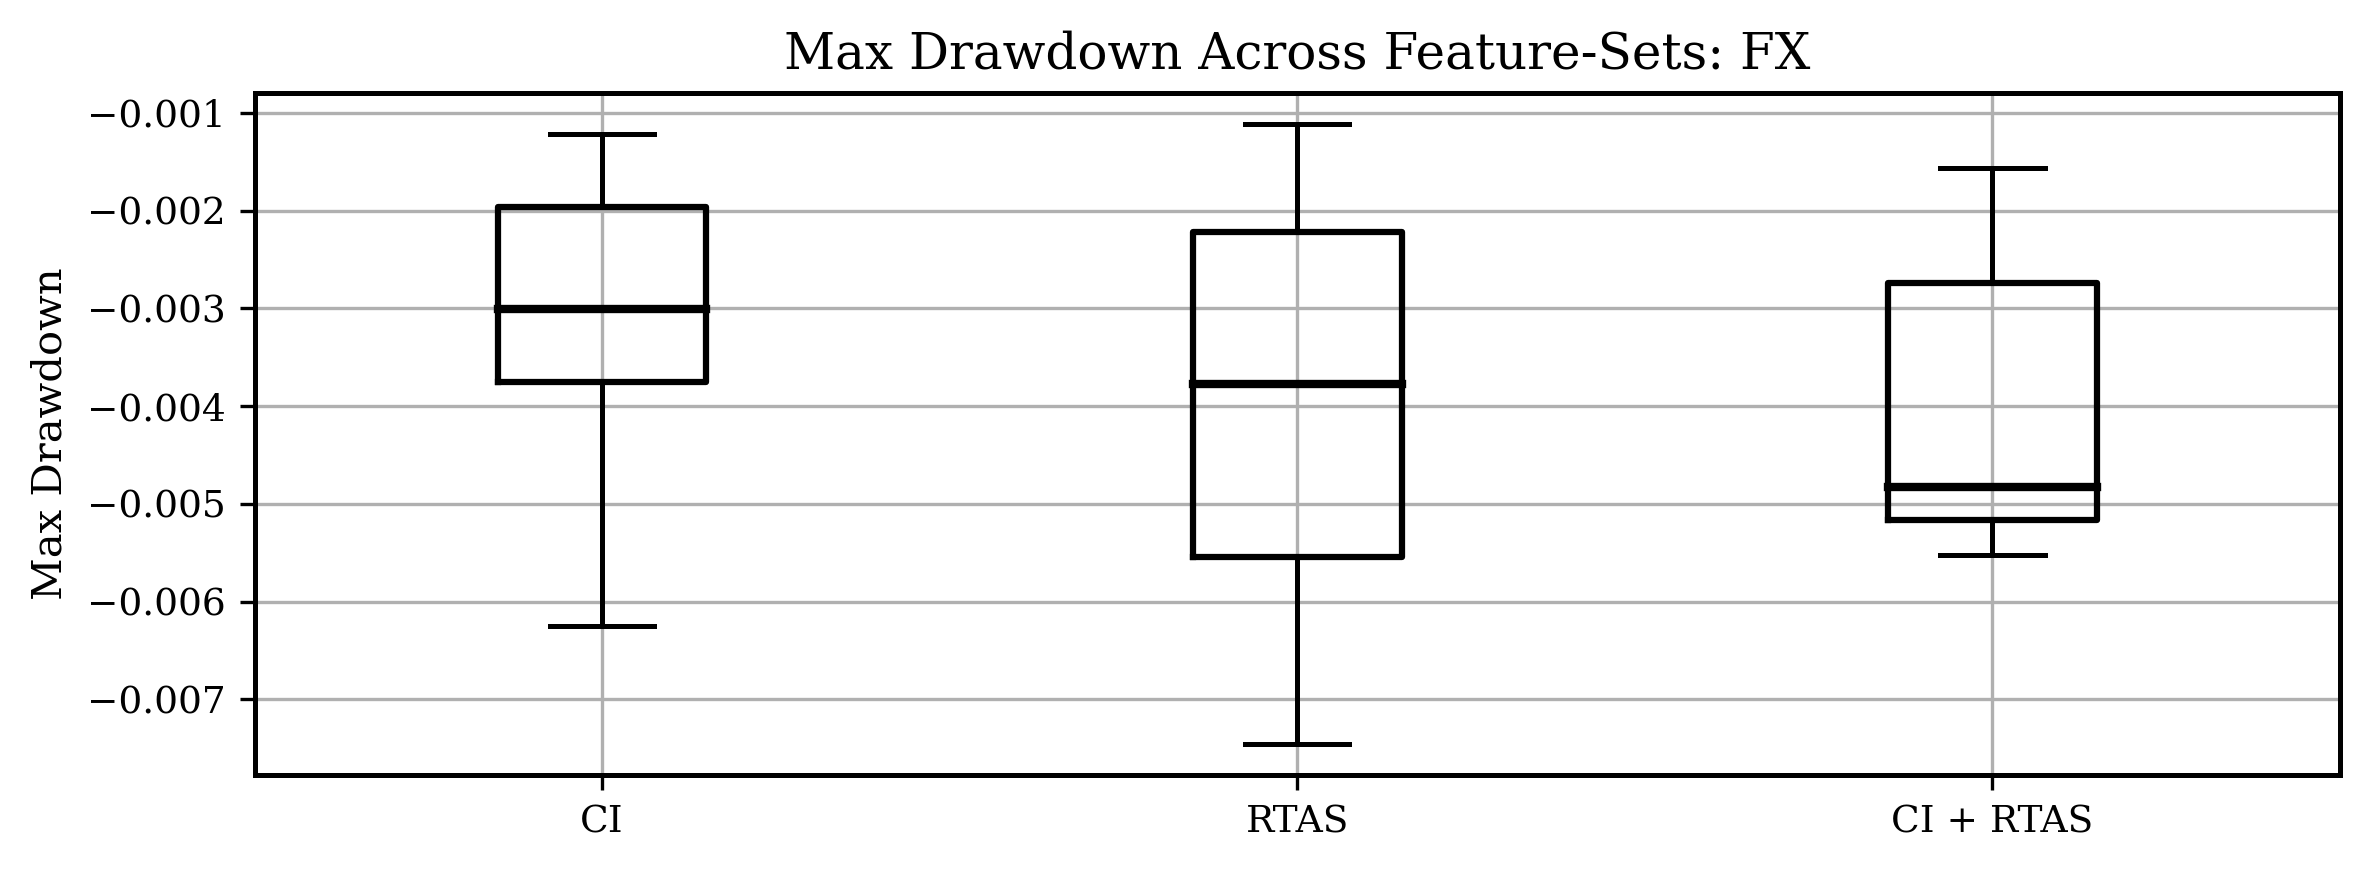

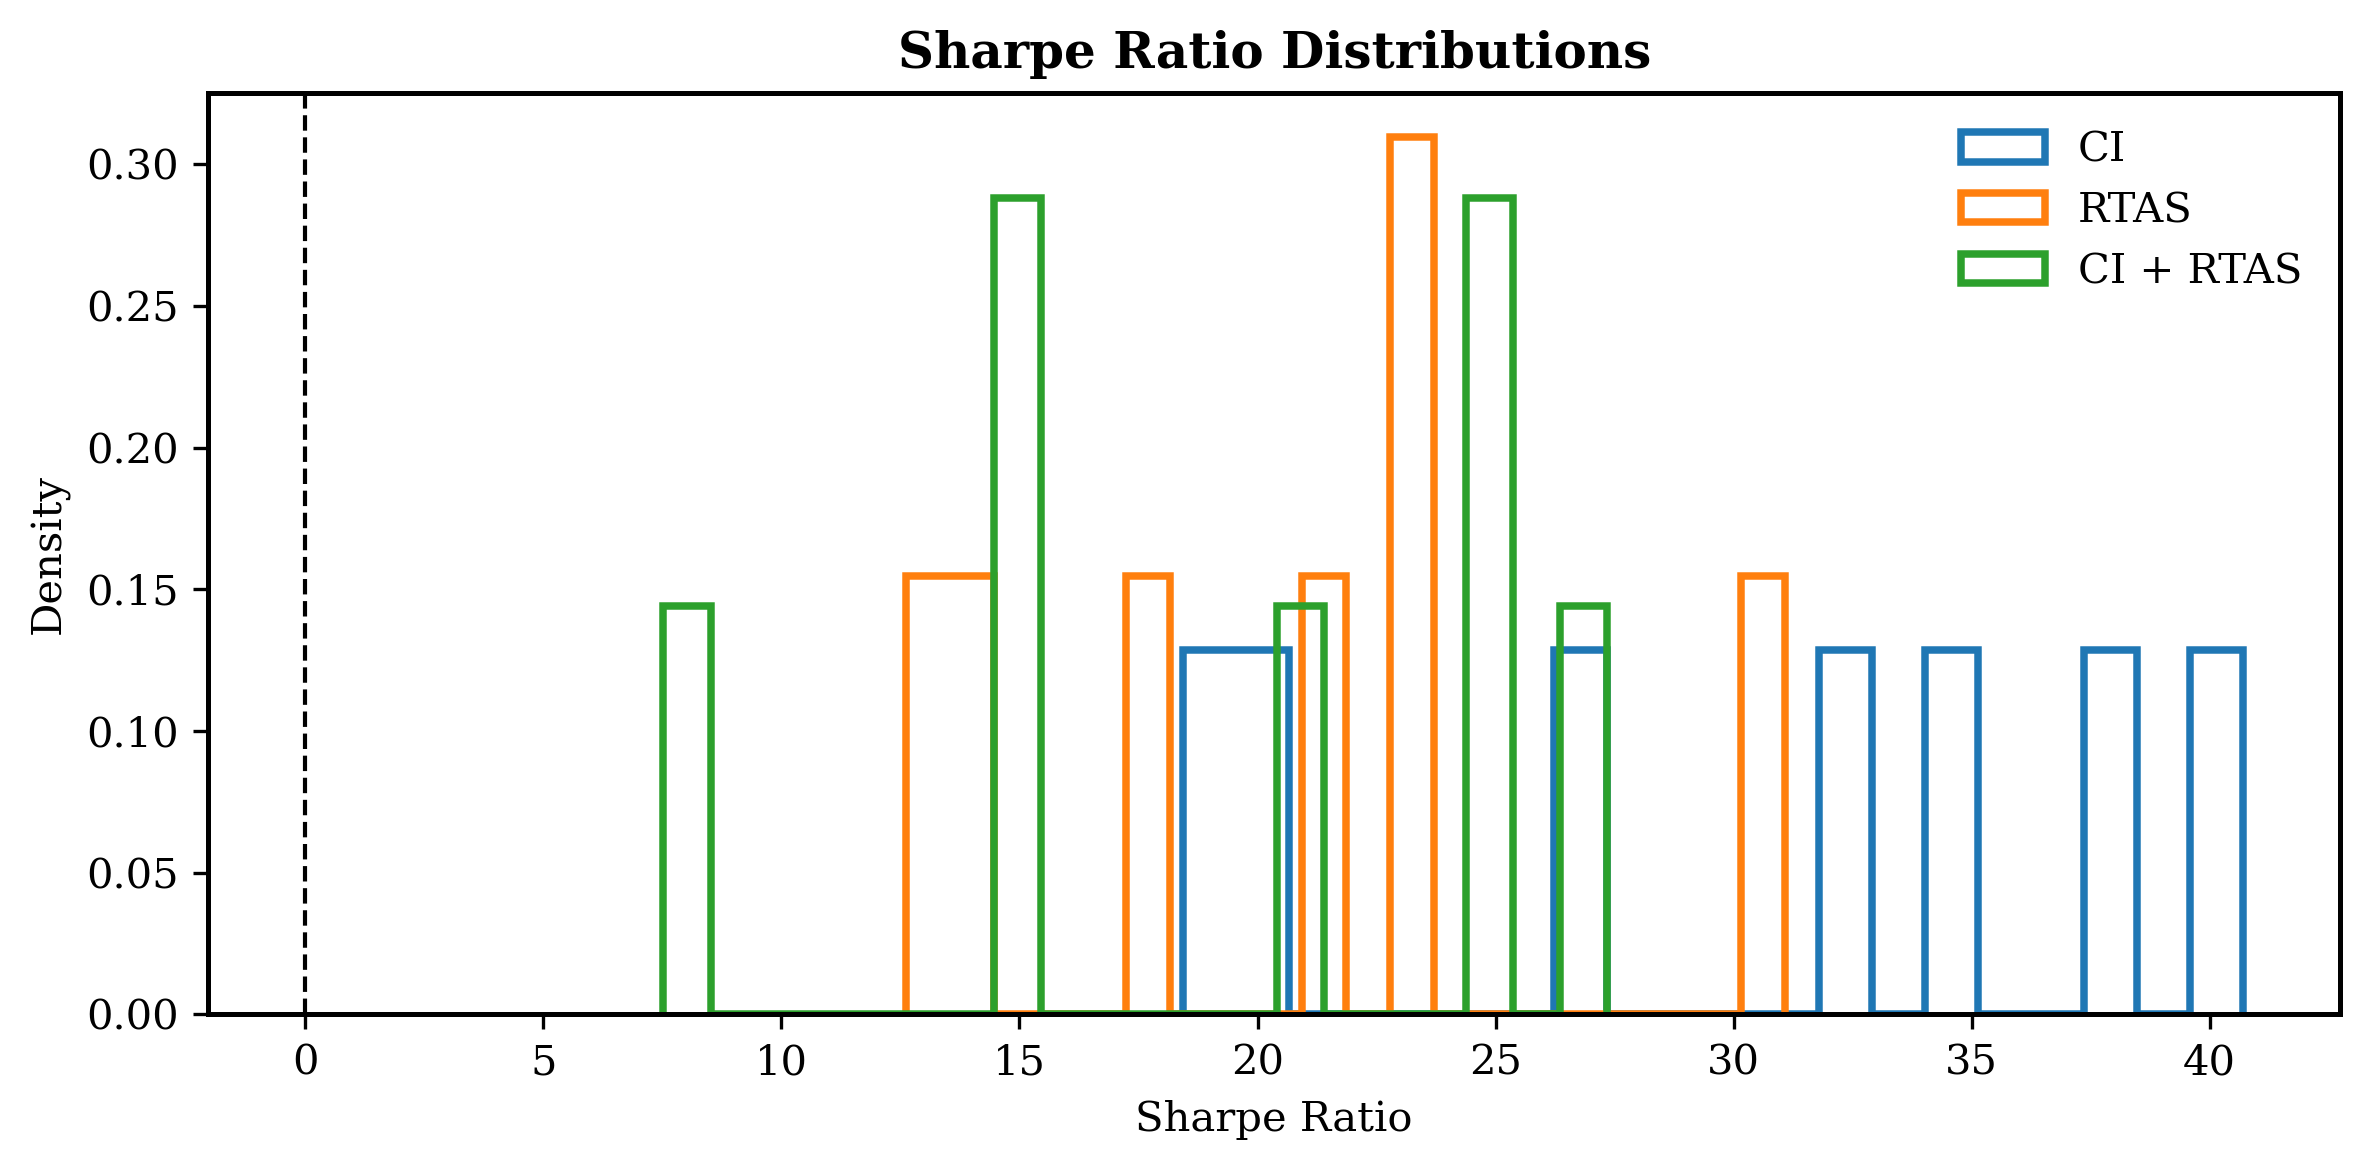

----------------------------------------------------------------------------------------------------
Commods
mean
TI_Sharpe Ratio            -0.203930
TI_Sortino Ratio           -0.229377
TI_Max Drawdown            -0.242304
Sig_Sharpe Ratio            0.095553
Sig_Sortino Ratio           0.196723
Sig_Max Drawdown           -0.221478
TI_and_Sig_Sharpe Ratio     0.186196
TI_and_Sig_Sortino Ratio    0.352159
TI_and_Sig_Max Drawdown    -0.192919
dtype: float64
median
TI_Sharpe Ratio             0.026291
TI_Sortino Ratio            0.037042
TI_Max Drawdown            -0.206907
Sig_Sharpe Ratio            0.020838
Sig_Sortino Ratio           0.031045
Sig_Max Drawdown           -0.202600
TI_and_Sig_Sharpe Ratio     0.074798
TI_and_Sig_Sortino Ratio    0.106624
TI_and_Sig_Max Drawdown    -0.206907
dtype: float64
Number of Positive Sharpe Ratios per Model:
TI_Sharpe Ratio            54.545455
Sig_Sharpe Ratio           54.545455
TI_and_Sig_Sharpe Ratio    54.545455
dtype: float64


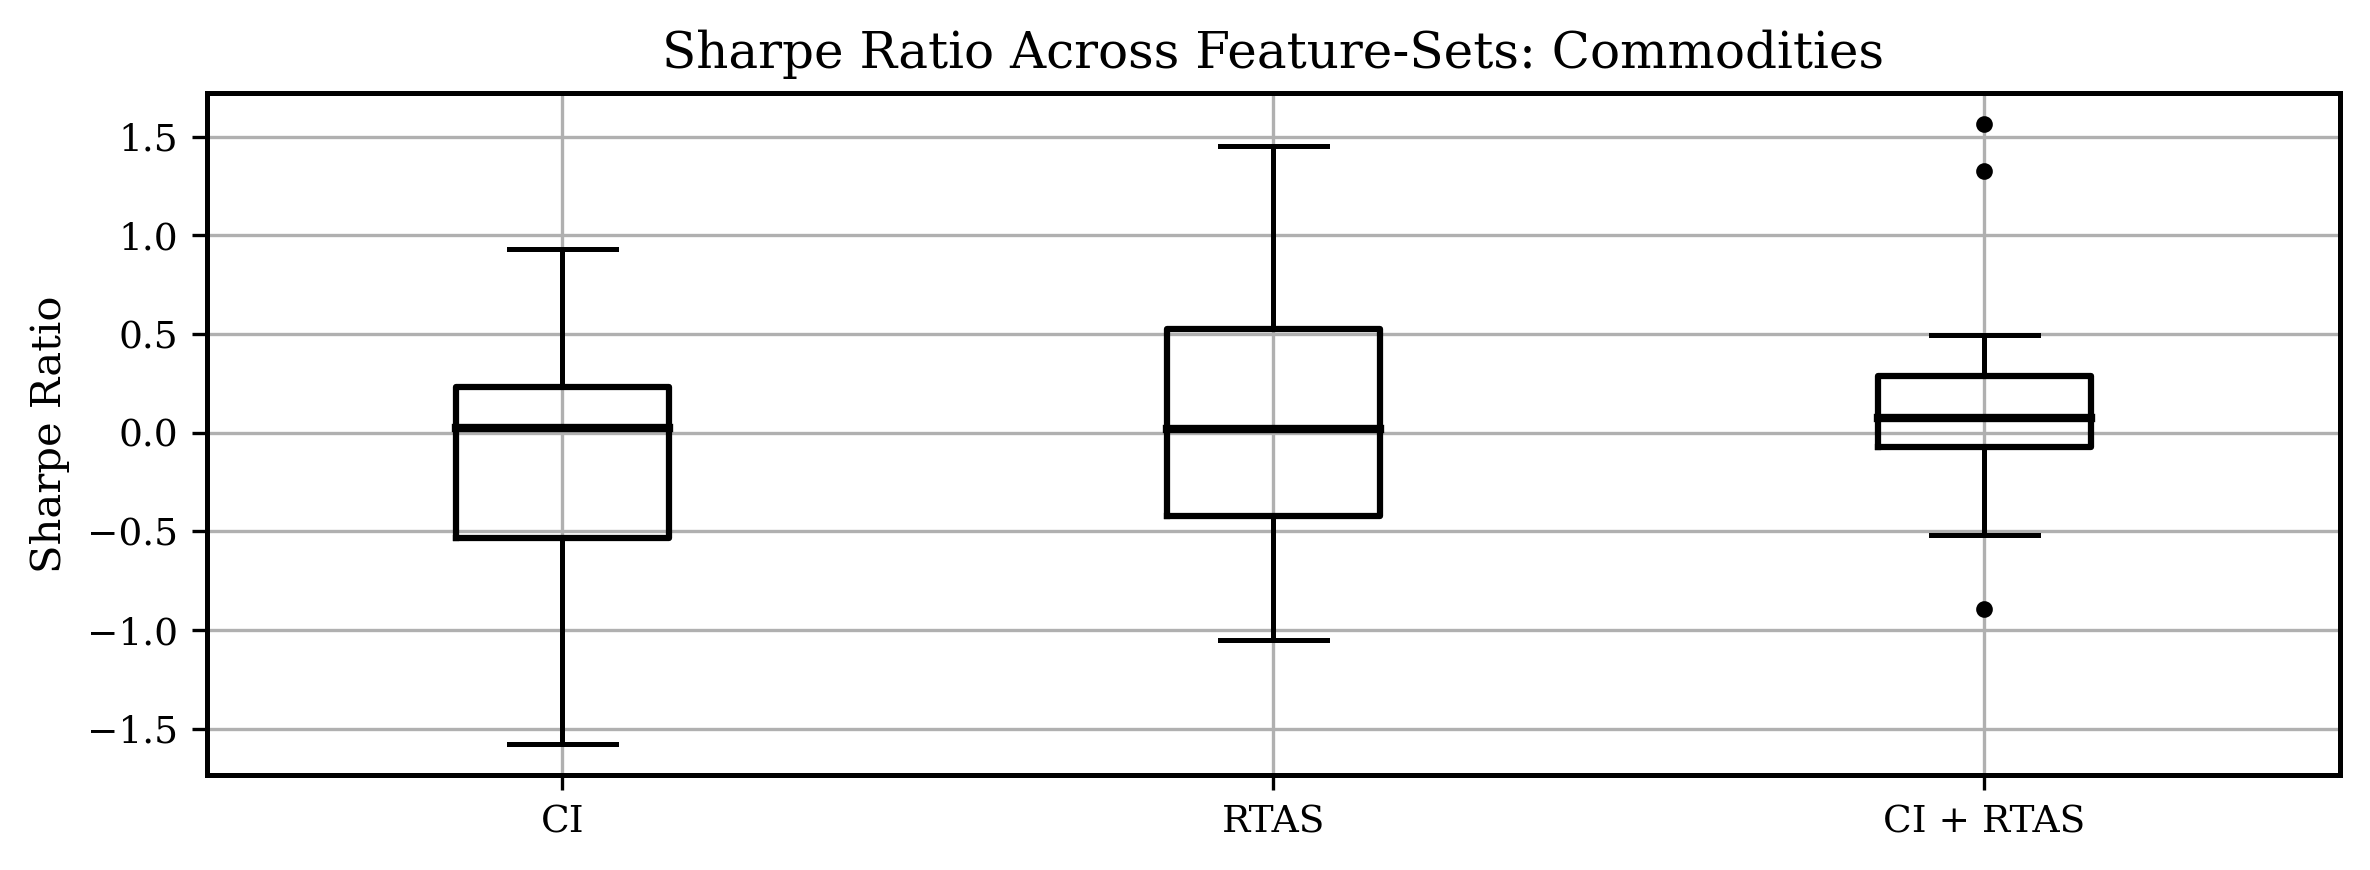

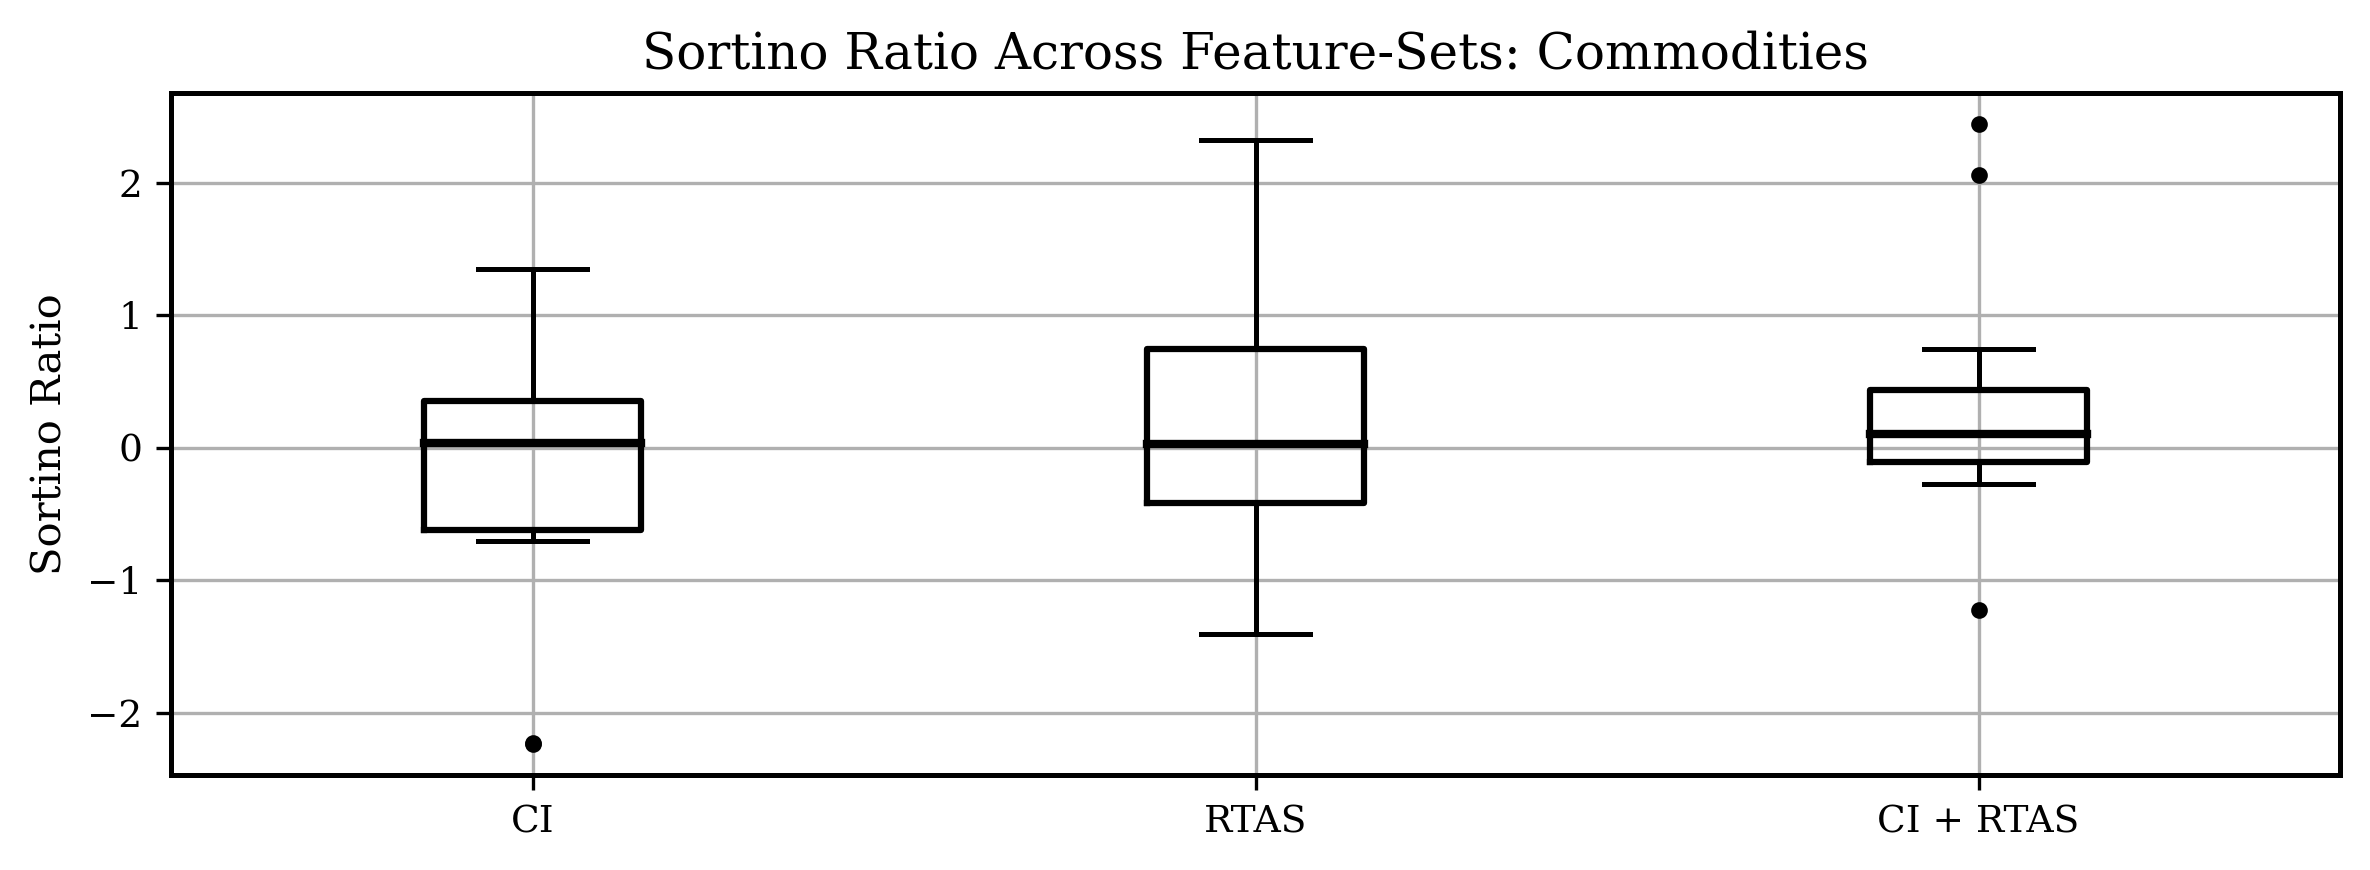

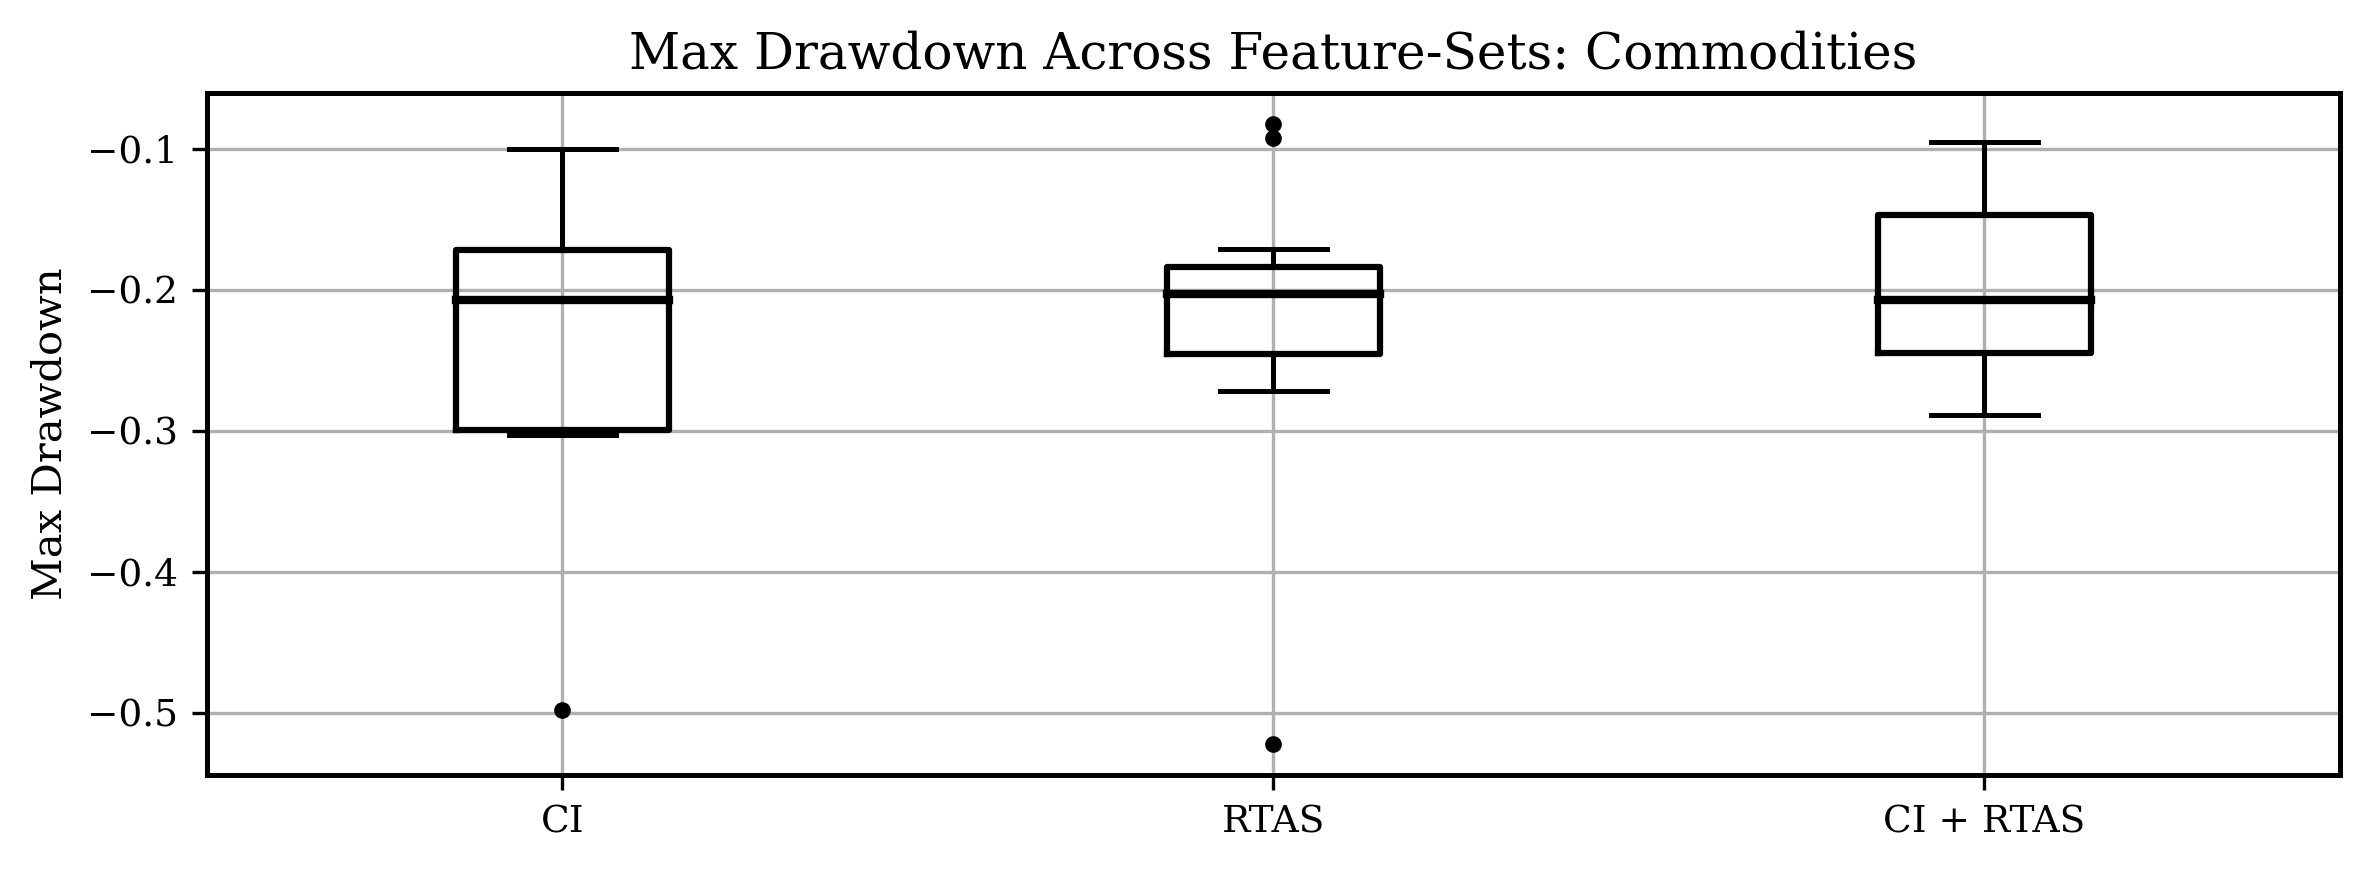

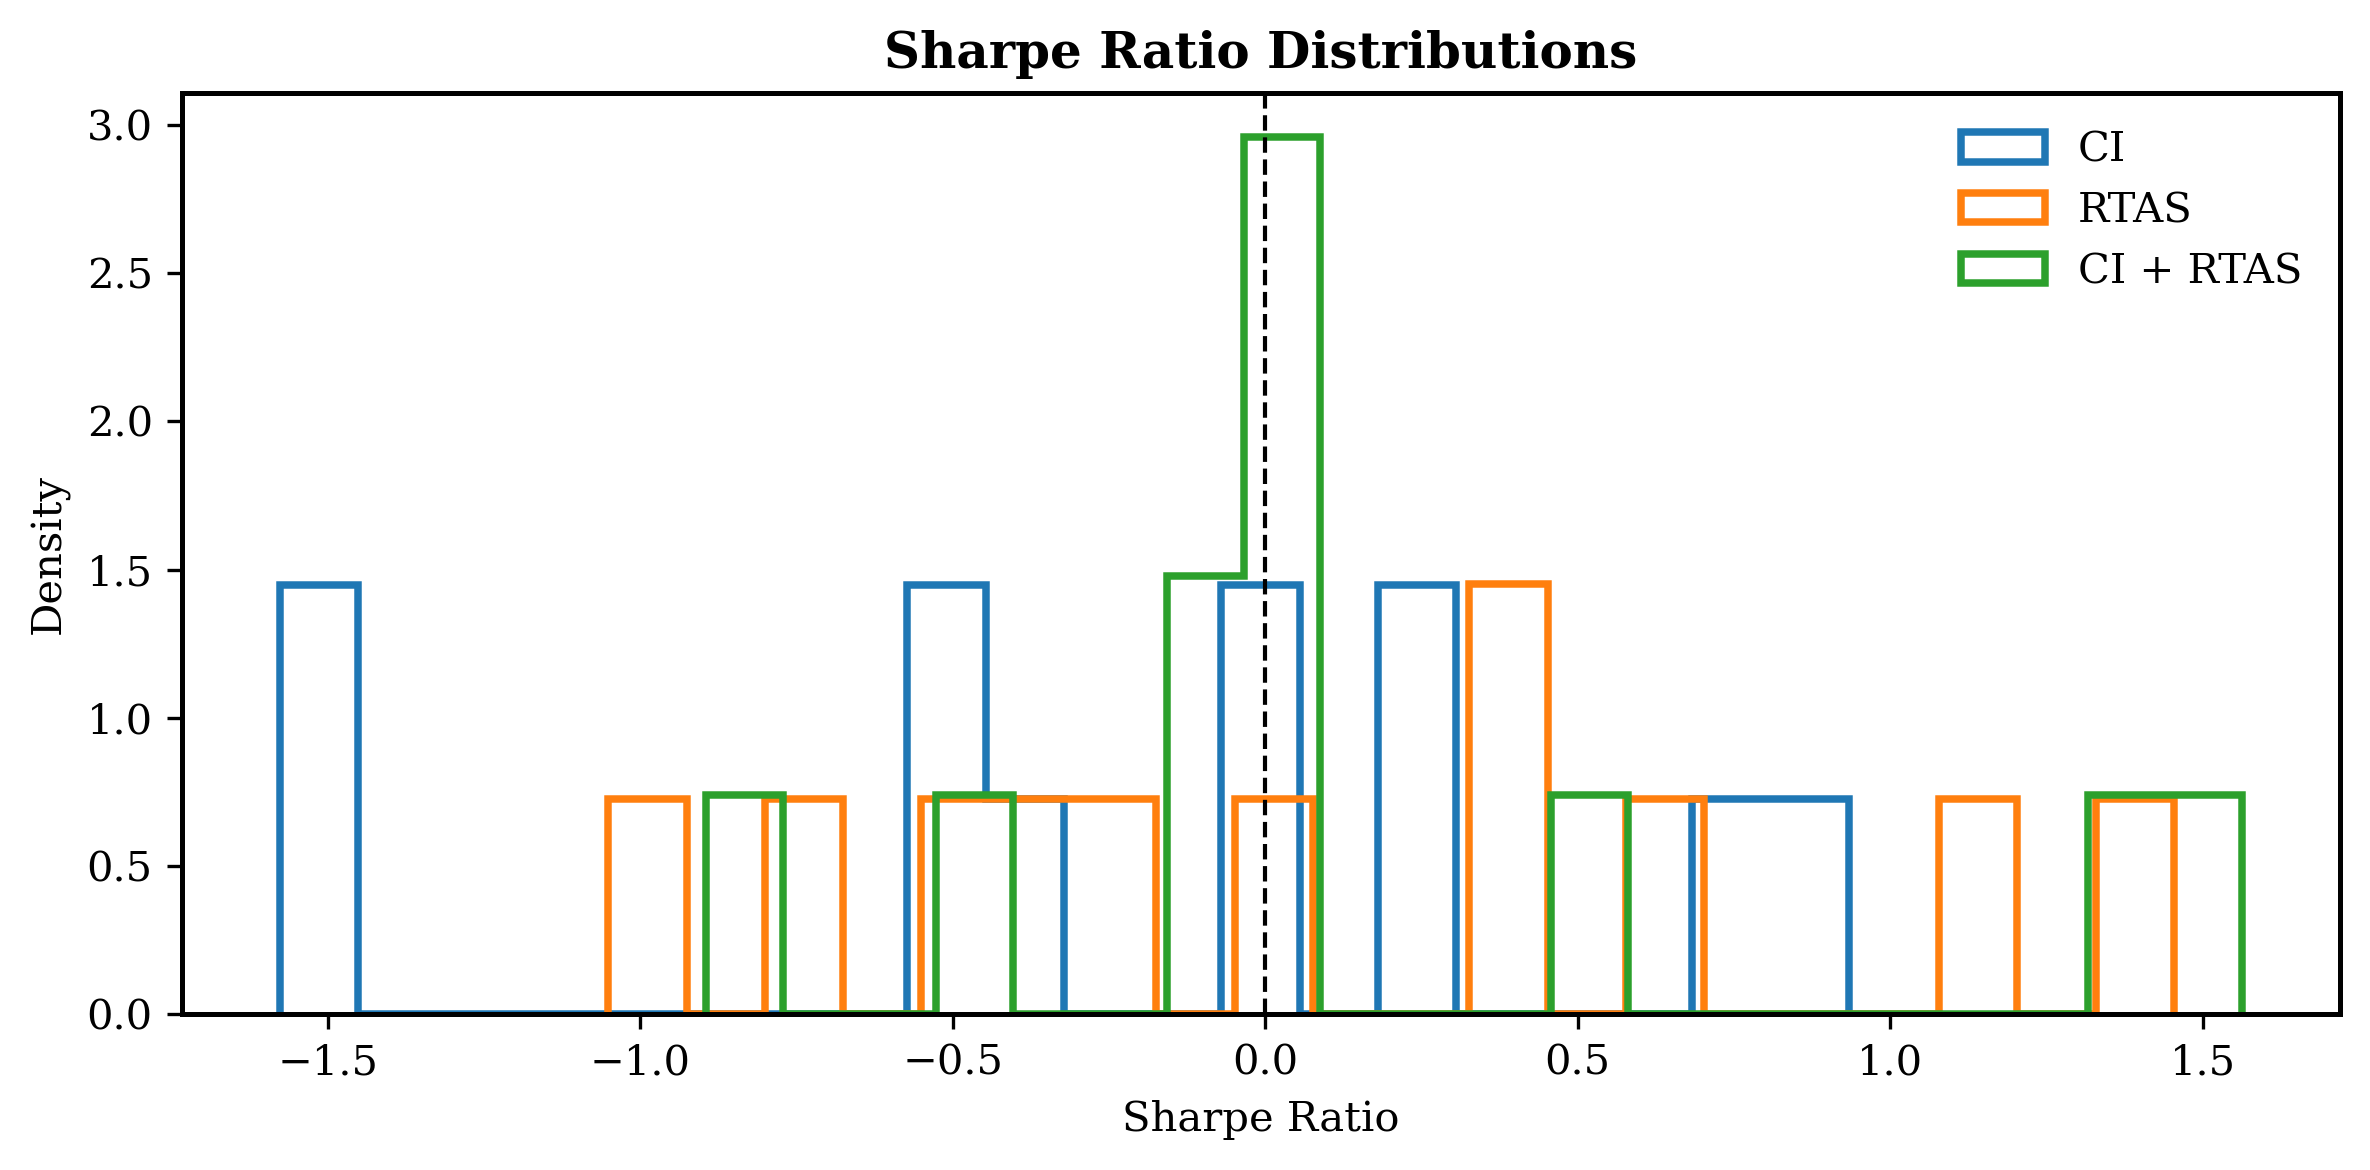

In [33]:
for AssetClass in ['Equities', 'FX', 'Commods']:
    print('-'*100)
    print(AssetClass)

    with open(f'TradingMetricsList_{AssetClass}.pkl', 'rb') as f:
        loaded_list = pickle.load(f)

    df_expanded = CleanMetricsAndSummarise(loaded_list)
    print('mean')
    print(df_expanded.mean(axis=0))
    print('median')
    print(df_expanded.median(axis=0))
    
    # Filter only Sharpe Ratio columns
    sharpe_cols = df_expanded.filter(like='Sharpe Ratio')

    # Count number of positive Sharpe Ratios per column
    positive_sharpe_counts = (sharpe_cols > 0).sum()

    print("Number of Positive Sharpe Ratios per Model:")
    print(positive_sharpe_counts*100/df_expanded.shape[0])
    
    if AssetClass == 'Commods':
        AssetClass = 'Commodities'
    
    PlotBox(df_expanded)
    PlotHist(df_expanded)

FileNotFoundError: [Errno 2] No such file or directory: 'BestModelsList_FX.pkl'

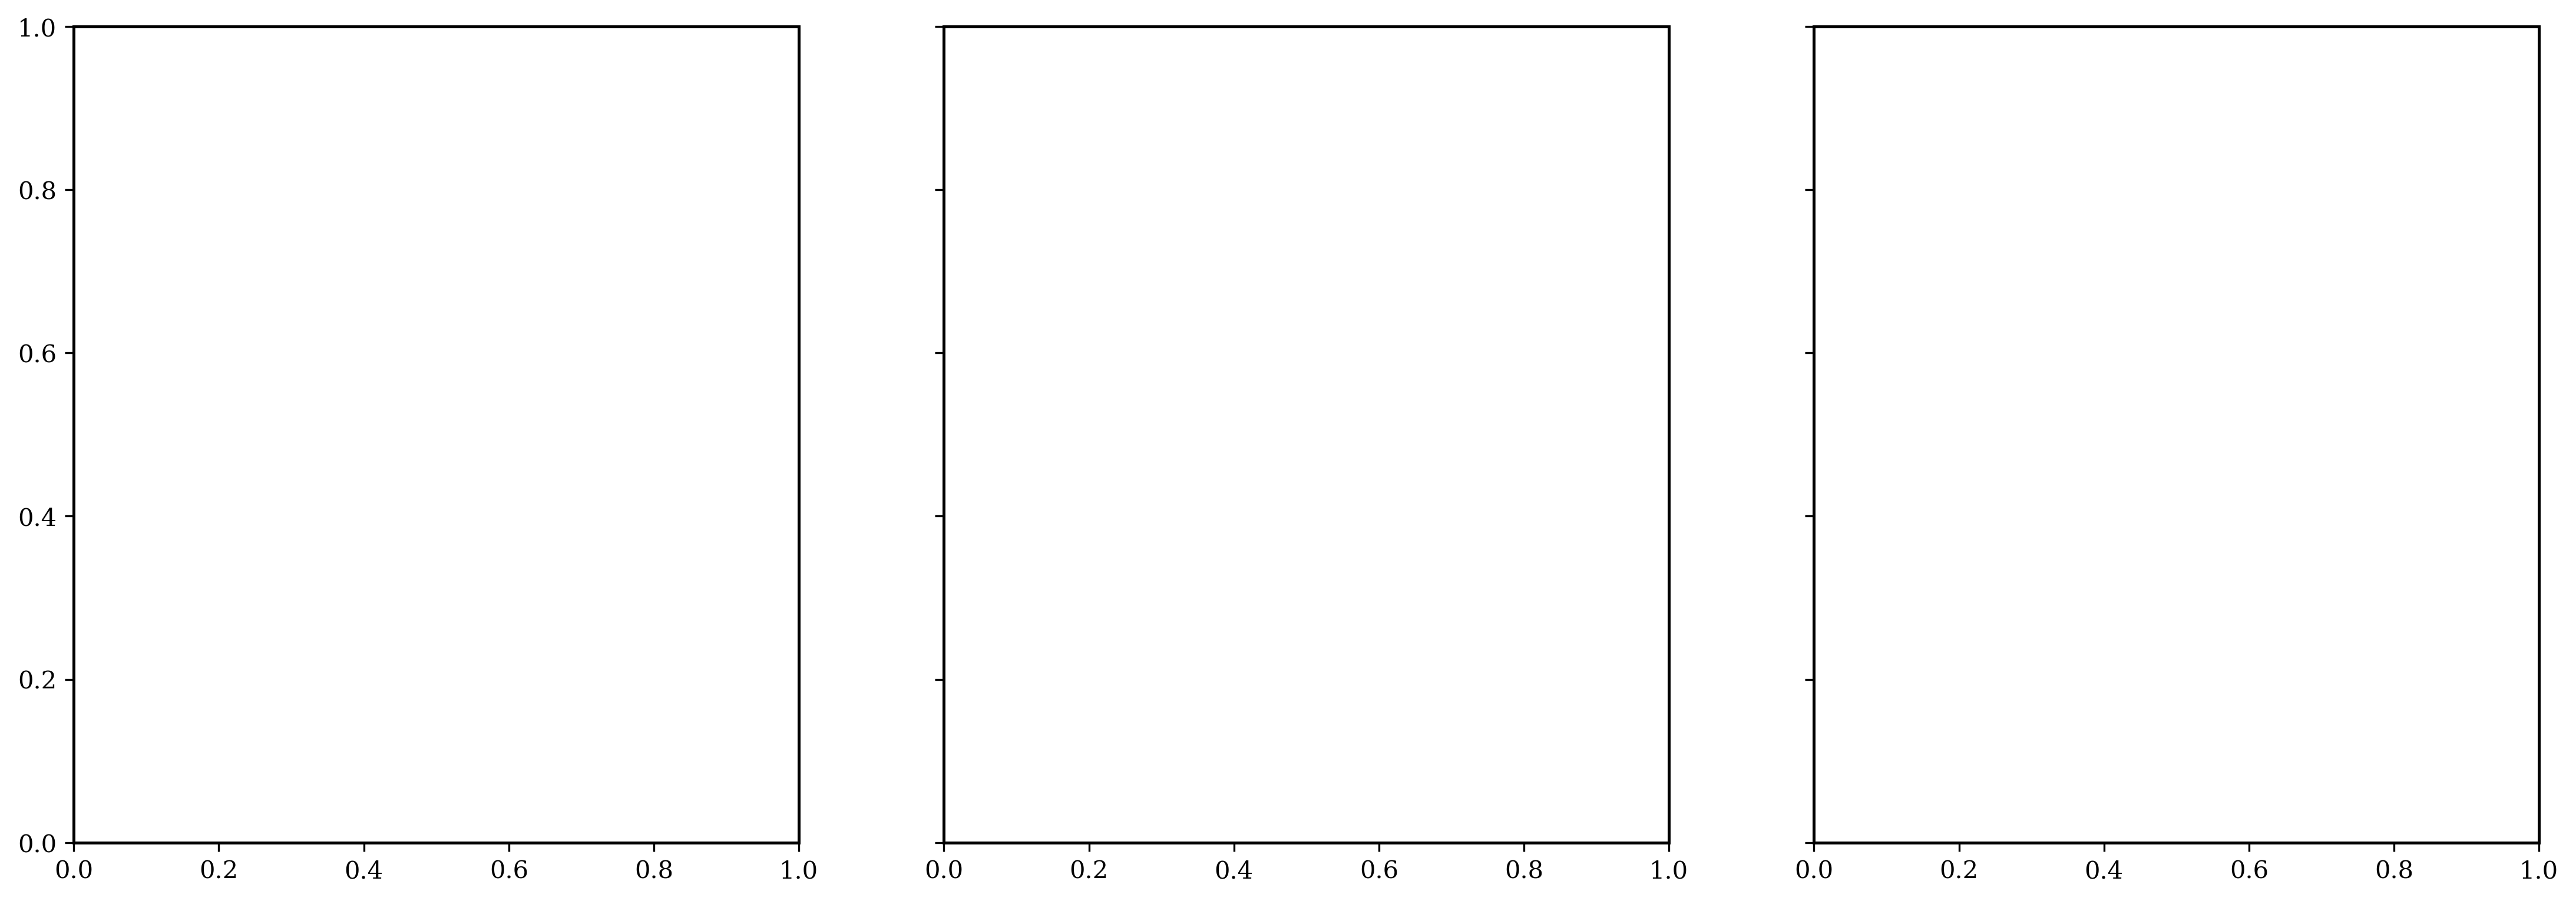

In [34]:
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

# Modified CountModels to take an axis
def CountModels(data, ax, title):
    # Step 1: Count model occurrences per feature set
    counts = defaultdict(lambda: defaultdict(int))
    all_models = set()

    for entry in data:
        for feature_set, (model, _) in entry.items():
            counts[feature_set][model] += 1
            all_models.add(model)

    feature_sets = ['TI', 'Sig', 'TI_and_Sig']
    model_list = sorted(all_models)
    proportions = {model: [] for model in model_list}

    for fs in feature_sets:
        total = sum(counts[fs].values())
        for model in model_list:
            prop = counts[fs][model] / total if total > 0 else 0
            proportions[model].append(prop)

    x = range(len(feature_sets))
    bottom = [0] * len(feature_sets)

    for model in model_list:
        ax.bar(x, proportions[model], bottom=bottom, label=model)
        bottom = [i + j for i, j in zip(bottom, proportions[model])]

    feature_sets = ['CI', 'RTAS', 'CI + RTAS']
    ax.set_xticks(x)
    ax.set_xticklabels(feature_sets, fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Proportion", fontsize=13)
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Main plotting logic
asset_classes = ['FX', 'Equities', 'Commods']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, asset_class in enumerate(asset_classes):
    with open(f'BestModelsList_{asset_class}.pkl', 'rb') as f:
        model_list = pickle.load(f)
        
    CountModels(model_list, ax=axes[i], title=asset_class)

# Get legend handles and labels from all subplots
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, title="Model", loc='lower center', ncol=len(labels), fontsize=12, title_fontsize=13)

fig.suptitle("Model Proportions by Feature Set for Each Asset Class", fontsize=18)

# Adjust layout to make space for legend
plt.tight_layout(rect=[0, 0.1, 1, 0.92])  # Leave space at bottom for legend and top for suptitle
plt.show()

AG


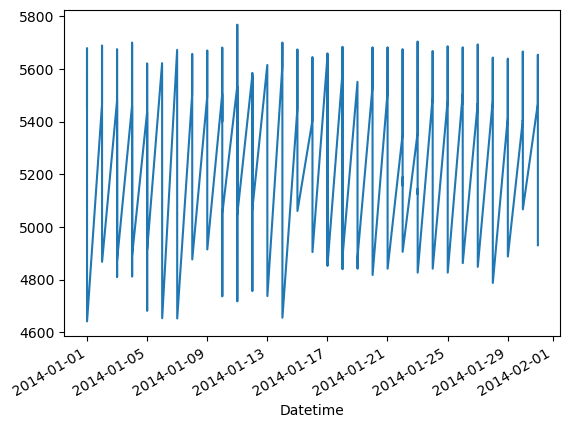

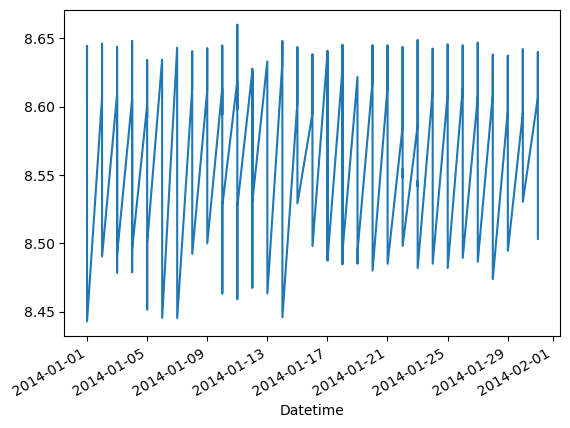

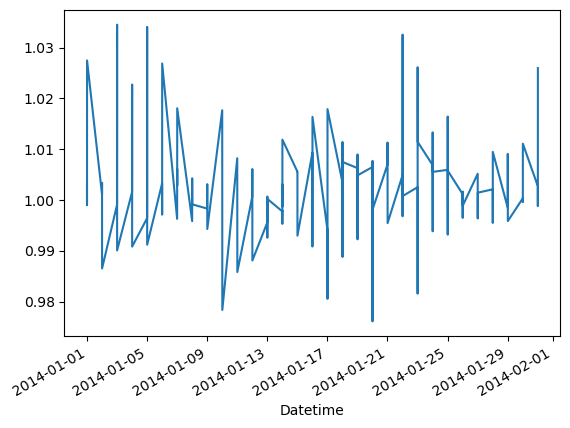

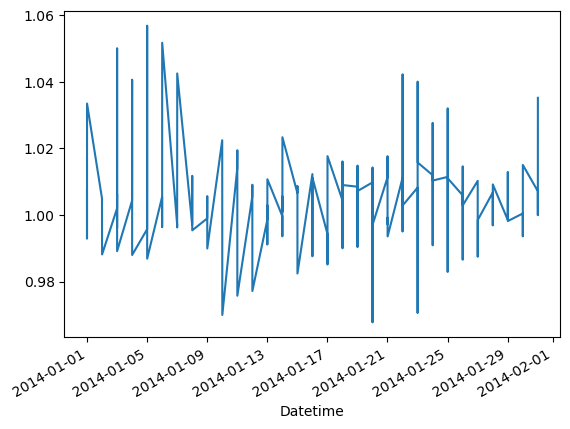

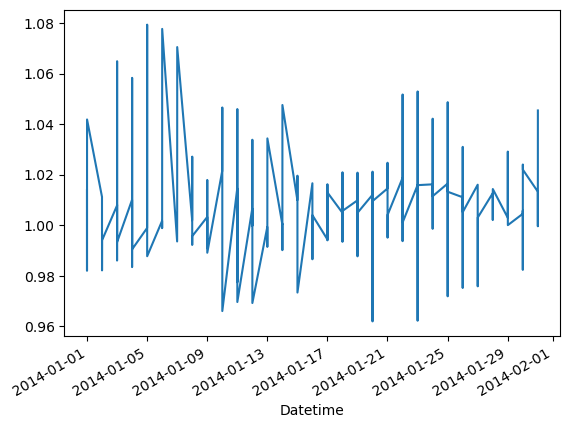

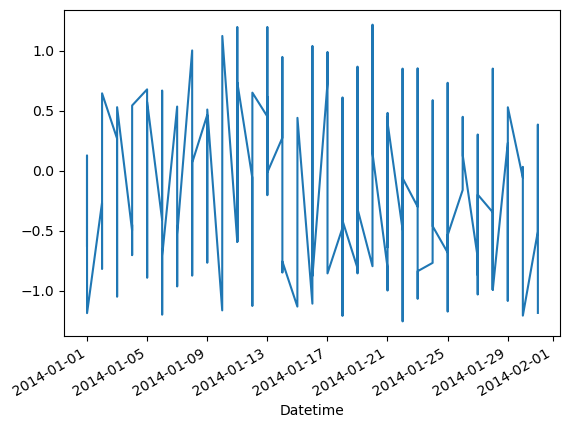

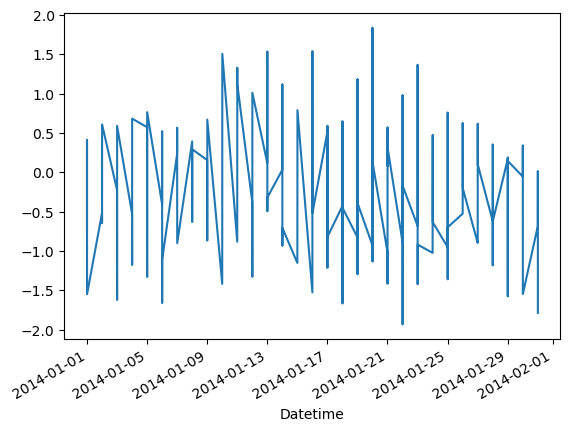

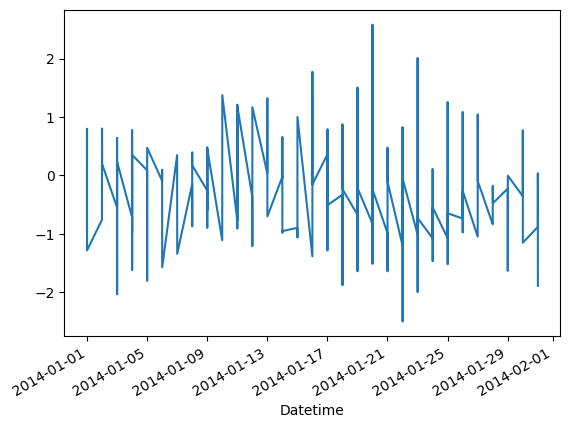

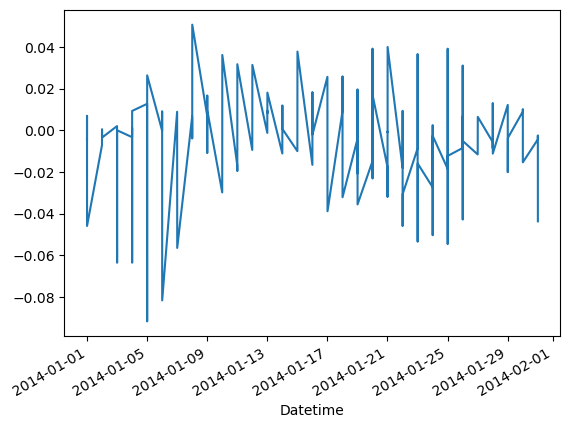

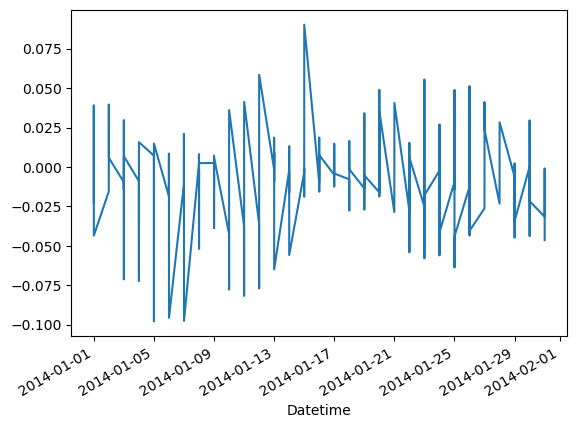

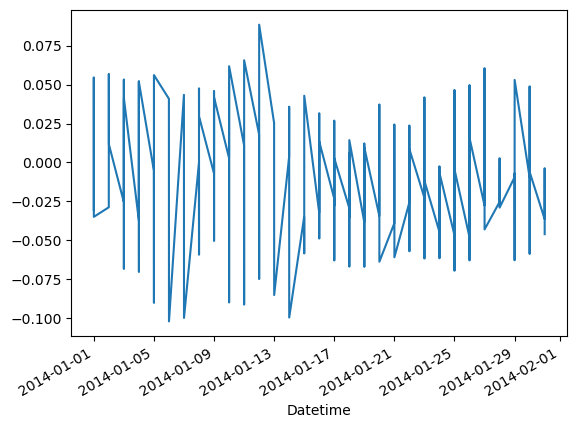

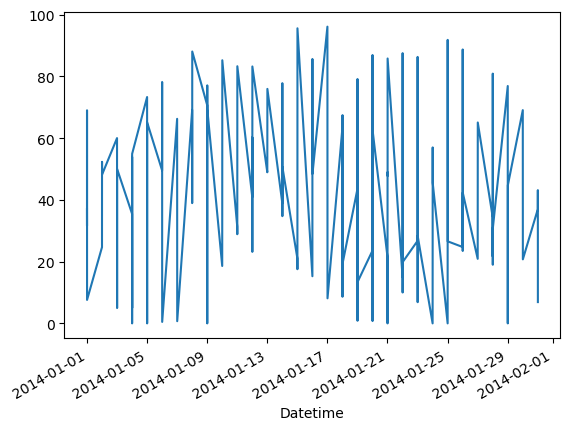

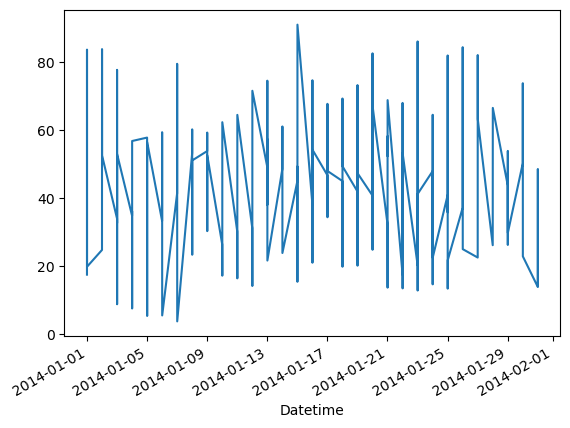

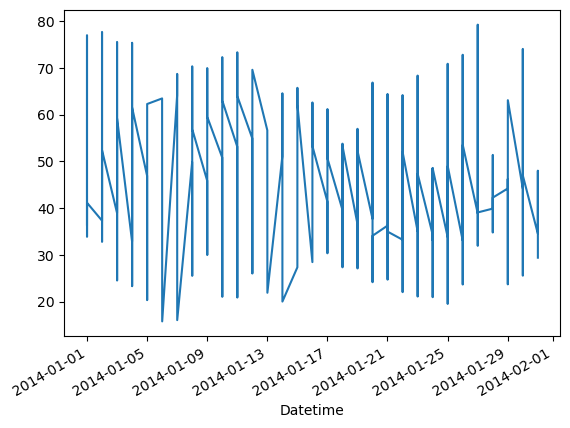

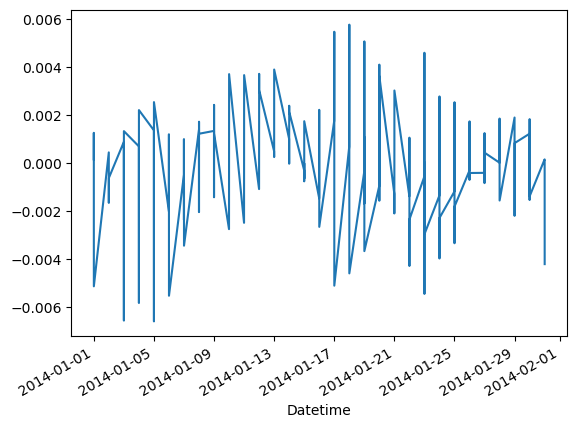

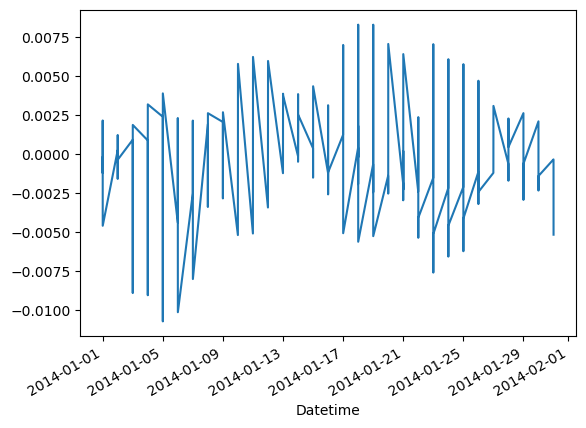

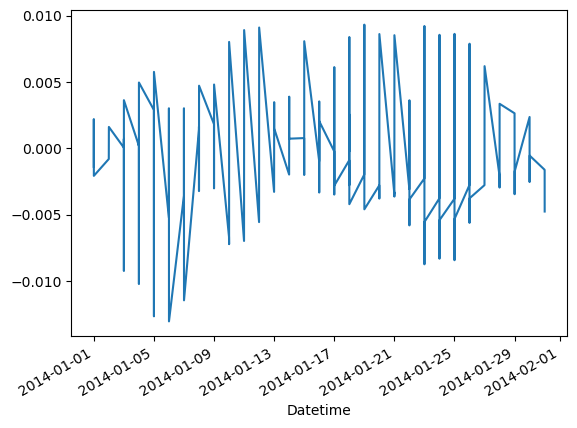

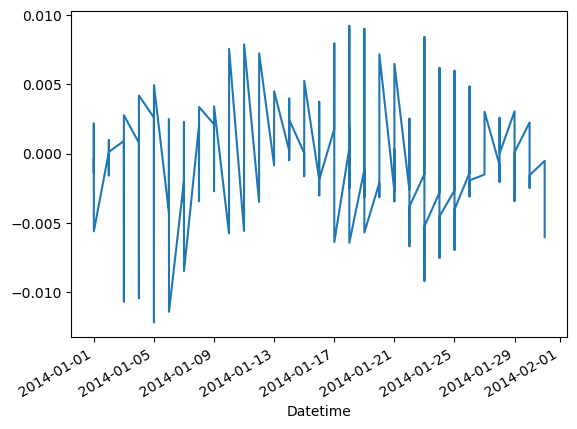

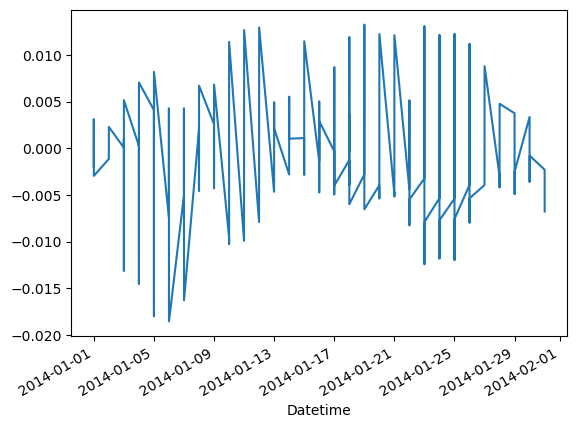

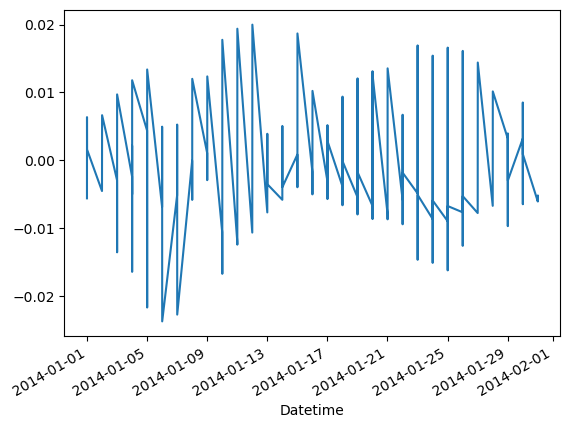

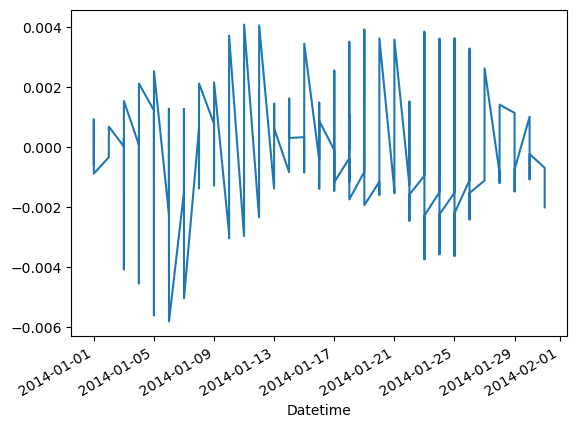

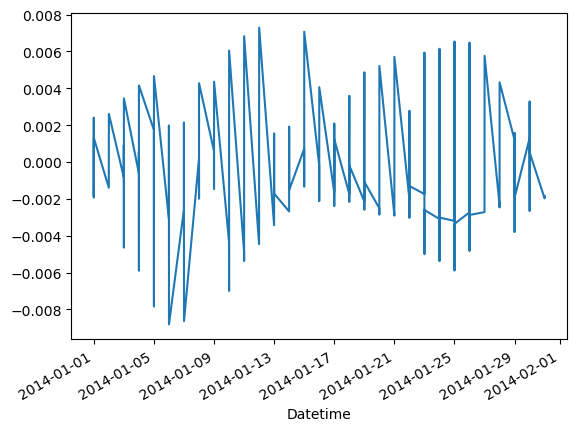

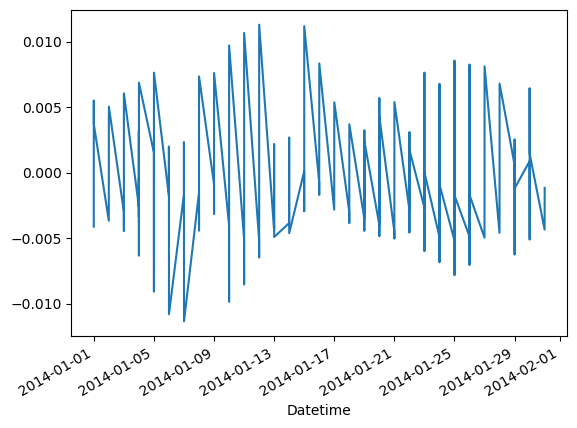

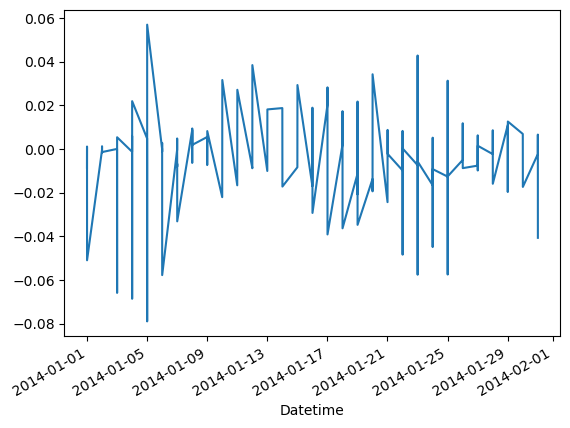

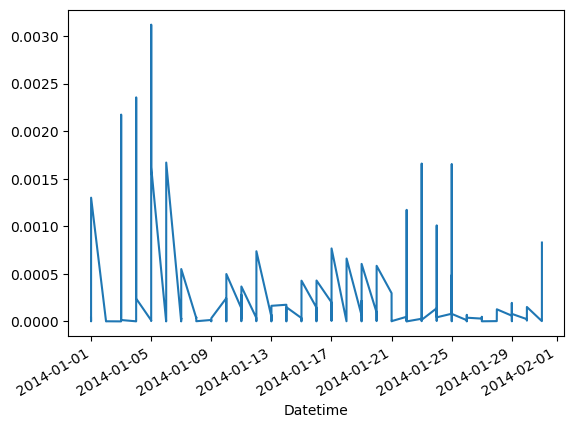

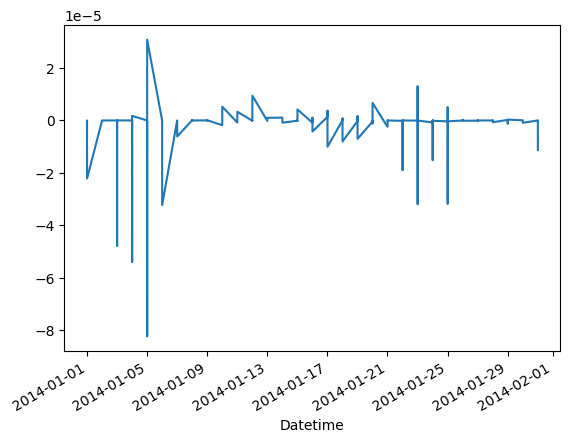

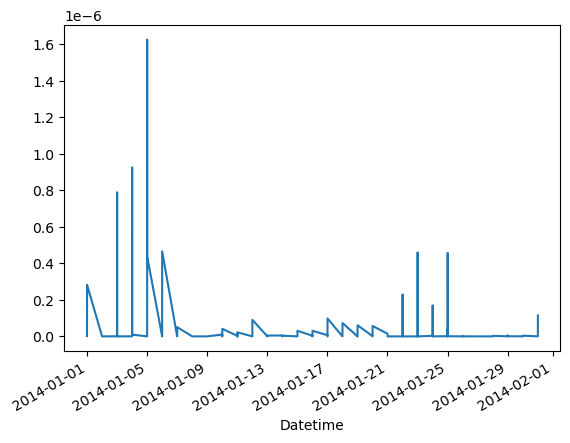

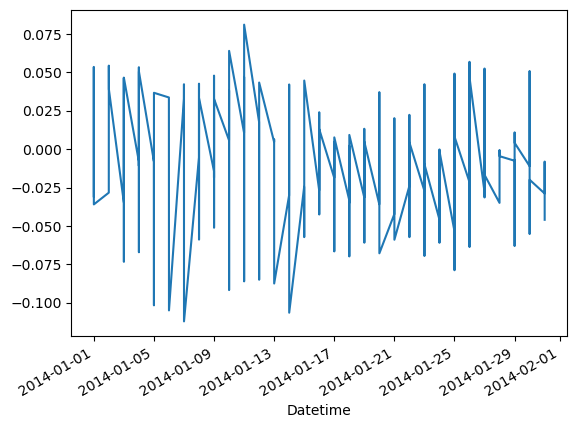

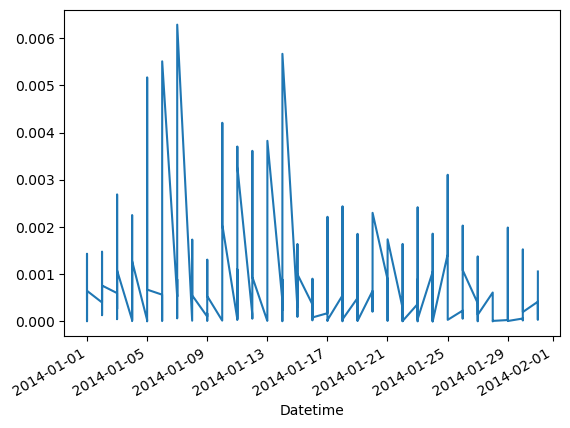

In [20]:
print(asset_name)

for i in range(29):

    df_features.iloc[:200, i].plot()
    plt.show()